# Dataset 1: Melbourne Housing Price Prediction

## Business Objective
Train an ML model to predict the selling price of properties in Melbourne based on characteristics such as distance to CBD, land size, number of bedrooms, building area, and property age.

## Data Source
`Datasets/01_Melbourne_Residential.csv`

## Data Column Description
| Column | Description |
|--------|-------------|
| Suburb | Suburb of the residential property |
| Address | Address of the residential property |
| Rooms | Number of rooms |
| Type | Property type: <br>- br: bedroom(s)<br>- h: house, cottage, villa, semi, terrace<br>- u: unit, duplex<br>- t: townhouse<br>- dev site: development site<br>- o res: other residential |
| Price | Price in dollars |
| Method | Sale method:<br>- S: property sold<br>- SP: property sold prior<br>- PI: property passed in<br>- PN: sold prior not disclosed<br>- SN: sold not disclosed<br>- NB: no bid<br>- VB: vendor bid<br>- W: withdrawn prior to auction<br>- SA: sold after auction<br>- SS: sold after auction price not disclosed<br>- N/A: price or highest bid not available |
| Seller | Name of Real Estate Agent |
| Date | Date sold |
| Distance | Distance of property to CBD in km |
| Postcode | Postal code of the property |
| Bedroom2 | Scraped # of Bedrooms (from different source) |
| Bathroom | Number of Bathrooms |
| Car | Number of parking spots for cars |
| Landsize | Land Size |
| BuildingArea | Building Size |
| YearBuilt | Year in which the property was built |
| CouncilArea | Governing council for the area |
| Latitude | Latitude of the property |
| Longitude | Longitude of the property |
| Region | Region of the property |
| Propertycount | Number of properties that exist in the suburb |


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import folium
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
import os
import mlflow
import io
from PIL import Image
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

## Task 1 - Exploratory Data Analysis on Dataset 1.
- Intense data exploration by looking at data in many different ways.
- All the visualisations address the required analysis concisely and clearly.

### Sub task 1 - Missing values, duplicates, data type

In [2]:
# Set visualization preferences
sns.set_palette("husl")
pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

# Read the dataset
df = pd.read_csv("Datasets/01_Melbourne_Residential.csv")

# Set up MLFlow experiment
mlflow.set_experiment("Melbourne Housing Price Prediction")
mlflow.start_run(run_name="data_preprocessing_pipeline")

<ActiveRun: >

In [3]:
# Display basic information about the dataset
# Log dataset shape as parameters
mlflow.log_param("python_version", os.popen('python --version').read().strip())

mlflow.log_param("initial_rows", df.shape[0])
mlflow.log_param("initial_columns", df.shape[1])

mlflow.log_param("columns", list(df.columns))
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()


Dataset Shape: (13580, 21)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  int64  
 5   Method         13580 non-null  object 
 6   Seller         13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  int64  
 10  Bedroom2       13580 non-null  int64  
 11  Bathroom       13580 non-null  int64  
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  int64  
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitud

Note that latitude and longitude is misspelled

In [4]:
df.head().to_csv("sample_data.csv", index=False)
mlflow.log_artifact("sample_data.csv", "data_samples")
df.head()

Suburb           Address  Rooms Type    Price Method         Seller  \
0  Airport West     154 Halsey Rd      3    t   840000     PI         Nelson   
1   Albert Park    105 Kerferd Rd      2    h  1275000      S  hockingstuart   
2   Albert Park  85 Richardson St      2    h  1455000      S        Thomson   
3    Alphington        6 Smith St      4    h  2000000      S          Brace   
4    Alphington   5/6 Yarralea St      3    h  1110000      S         Jellis   

       Date  Distance  Postcode  Bedroom2  Bathroom  Car  Landsize  \
0  3/9/2023      13.5      3042         3         2  1.0       303   
1  3/9/2023       3.3      3206         2         1  0.0       120   
2  3/9/2023       3.3      3206         2         1  0.0       159   
3  3/9/2023       6.4      3078         3         2  4.0       853   
4  3/9/2023       6.4      3078         3         2  2.0       208   

   BuildingArea  YearBuilt    CouncilArea  Lattitude  Longtitude  \
0         225.0     2016.0  Moonee Valley   -37.7180    144.8780   
1          82.0     1900.0   Port Phillip   -37.8459    144.9555   
2           NaN        NaN   Port Phillip   -37.8450    144.9538   
3         263.0     1930.0        Darebin   -37.7707    145.0318   
4           NaN     2013.0          Yarra   -37.7854    145.0325   

                  Region  Propertycount  
0   Western Metropolitan           3464  
1  Southern Metropolitan           3280  
2  Southern Metropolitan           3280  
3  Northern Metropolitan           2211  
4  Northern Metropolitan           2211

In [5]:
# Calculate and log missing values information
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_summary = pd.DataFrame(
    {"Missing Values": missing_values, "Percentage": missing_percentage}
).sort_values("Percentage", ascending=False)

print("\nMissing Values Summary:")
print(missing_summary)

# Log missing values statistics
for column in df.columns:
    mlflow.log_metric(f"missing_pct_{column}", missing_percentage[column])

# Log overall missing data metrics
mlflow.log_metric("total_missing_values", missing_values.sum())
mlflow.log_metric("avg_missing_percentage", missing_percentage.mean())

# Save and log the missing values summary
missing_summary.to_csv("missing_values_summary.csv")
mlflow.log_artifact("missing_values_summary.csv", "data_quality")


Missing Values Summary:
               Missing Values  Percentage
BuildingArea             6450   47.496318
YearBuilt                5375   39.580265
CouncilArea              1369   10.081001
Car                        62    0.456554
Suburb                      0    0.000000
Bathroom                    0    0.000000
Region                      0    0.000000
Longtitude                  0    0.000000
Lattitude                   0    0.000000
Landsize                    0    0.000000
Bedroom2                    0    0.000000
Address                     0    0.000000
Postcode                    0    0.000000
Distance                    0    0.000000
Date                        0    0.000000
Seller                      0    0.000000
Method                      0    0.000000
Price                       0    0.000000
Type                        0    0.000000
Rooms                       0    0.000000
Propertycount               0    0.000000


#### Missing Value Analysis

The dataset exhibits significant patterns of missing values that require careful consideration during our analysis and modeling phase. Most notably, BuildingArea and YearBuilt show substantial missing data, with approximately 47.5% and 39.6% of values missing respectively. This high percentage of missing values could significantly impact our ability to make accurate predictions and requires thoughtful handling.

The BuildingArea variable, with nearly half of its values missing, presents the biggest challenge. This could indicate either data collection issues or that this information wasn't readily available for many properties. Given that building area is typically a crucial factor in determining property values, this missing data could potentially affect our model's performance.

YearBuilt, with about 40% missing values, represents another significant gap in our dataset. The age of a property often correlates strongly with its value and condition, making this another important feature that needs careful consideration during the data preprocessing stage.

CouncilArea shows a more moderate level of missing values at approximately 10%. While this is less severe than the previous two variables, it still requires attention, as council areas can be indicative of neighborhood characteristics and local regulations that influence property values.

The Car variable shows minimal missing data (less than 0.5%), which should be relatively straightforward to handle. Notably, Suburb and Bathroom have no missing values, which is advantageous as these are likely important predictors in our analysis.

#### Recommended Actions:
1. Consider advanced imputation techniques for BuildingArea and YearBuilt
2. Investigate if missing values follow any particular patterns
3. Evaluate the impact of excluding vs imputing these missing values on model performance
4. Document any assumptions made during the handling of missing values

In [6]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


In [7]:
# Display basic statistics
print("\nBasic Statistics:")
display(df.describe())


Basic Statistics:


Rooms         Price      Distance      Postcode      Bedroom2  \
count  13580.000000  1.358000e+04  13580.000000  13580.000000  13580.000000   
mean       2.937997  1.075684e+06     10.137776   3105.301915      2.914728   
std        0.955748  6.393107e+05      5.868725     90.676964      0.965921   
min        1.000000  8.500000e+04      0.000000   3000.000000      0.000000   
25%        2.000000  6.500000e+05      6.100000   3044.000000      2.000000   
50%        3.000000  9.030000e+05      9.200000   3084.000000      3.000000   
75%        3.000000  1.330000e+06     13.000000   3148.000000      3.000000   
max       10.000000  9.000000e+06     48.100000   3977.000000     20.000000   

           Bathroom           Car       Landsize  BuildingArea    YearBuilt  \
count  13580.000000  13518.000000   13580.000000   7130.000000  8205.000000   
mean       1.534242      1.610075     558.416127    151.967650  1964.684217   
std        0.691712      0.962634    3990.669241    541.014538    37.273762   
min        0.000000      0.000000       0.000000      0.000000  1196.000000   
25%        1.000000      1.000000     177.000000     93.000000  1940.000000   
50%        1.000000      2.000000     440.000000    126.000000  1970.000000   
75%        2.000000      2.000000     651.000000    174.000000  1999.000000   
max        8.000000     10.000000  433014.000000  44515.000000  2018.000000   

          Lattitude    Longtitude  Propertycount  
count  13580.000000  13580.000000   13580.000000  
mean     -37.809203    144.995216    7454.417378  
std        0.079260      0.103916    4378.581772  
min      -38.182550    144.431810     249.000000  
25%      -37.856822    144.929600    4380.000000  
50%      -37.802355    145.000100    6555.000000  
75%      -37.756400    145.058305   10331.000000  
max      -37.408530    145.526350   21650.000000

#### Statistical Analysis of Key Features

Several noteworthy observations emerge from this descriptive statistical summary that warrant attention:

##### Price Distribution and Range
* The mean house price is approximately 1.075M, with a substantial standard deviation of 639K
* There's a significant spread between minimum (85K) and maximum (9M) prices, indicating potential outliers
* The median price ($903K) being lower than the mean suggests a right-skewed distribution, typical of property markets

##### Property Characteristics Anomalies
* BuildingArea shows some extreme values, with a maximum of 44,515 square meters, which seems unusually large and may need investigation
* Landsize displays even more extreme variation, ranging from 0 to 433,014 square meters
* Bedroom2 has a maximum of 20 rooms, which could be either an error or represent apartment buildings rather than single-family homes
* Some properties show 0 bedrooms and bathrooms, which requires verification as this seems implausible for residential properties

##### Geographical Insights
* Properties span approximately 80km north-south (Lattitude: -38.18 to -37.40)
* The Postcode range (3000-3977) confirms this is Melbourne data
* Distance from CBD ranges from 0 to 48.1 km, with a mean of 10.1 km

##### Age of Properties
* Construction dates span from 1196 to 2018
* The 1196 minimum year is clearly erroneous and needs addressing
* The median construction year is 1970, indicating a significant portion of older properties

These observations suggest the need for:
1. Outlier investigation and potential treatment
2. Data validation, particularly for impossible values
3. Consideration of data transformations for heavily skewed variables
4. Separate analysis of different property types (houses vs. apartments)


### Sub task 2 - Distribution and Outliers
We'll analyze the distributions of numerical features and identify outliers to inform our preprocessing strategy.

In [8]:
# Define helper function for visualization
def plot_distribution_and_boxplot(df, column):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Distribution plot
    sns.histplot(data=df, x=column, kde=True, ax=ax1)
    ax1.set_title(f'Distribution of {column}')


    # Box plot
    sns.boxplot(data=df, y=column, ax=ax2)
    ax2.set_title(f'Box Plot of {column}')

    plt.tight_layout()
    plt.show()

#### Price Distribution Analysis
Let's first examine the distribution of our target variable (Price).

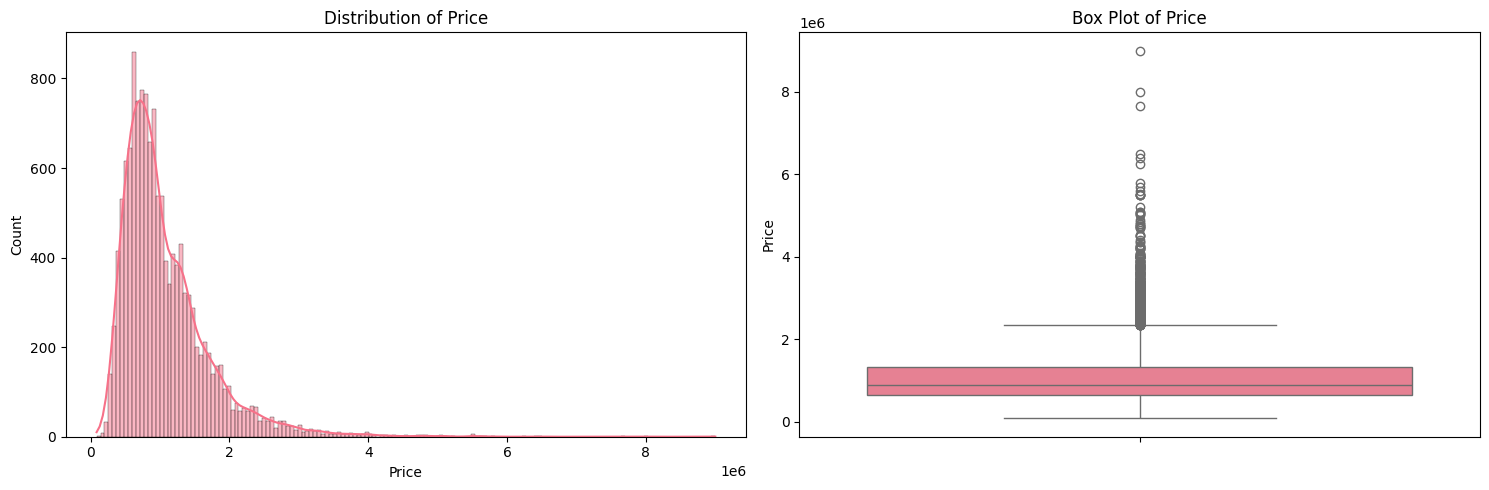


Price Statistics:


count    1.358000e+04
mean     1.075684e+06
std      6.393107e+05
min      8.500000e+04
25%      6.500000e+05
50%      9.030000e+05
75%      1.330000e+06
max      9.000000e+06
Name: Price, dtype: float64

In [9]:
# Analyze price distribution
plot_distribution_and_boxplot(df, 'Price')

# Display basic statistics for price
price_stats = df['Price'].describe()
print("\nPrice Statistics:")
display(price_stats)

# Log price statistics
for stat_name, stat_value in price_stats.items():
    mlflow.log_metric(f"price_{stat_name.lower().replace('%', '')}", stat_value)

# Log skewness of price
mlflow.log_metric("price_skewness", df["Price"].skew())


#### Price Distribution Analysis

The analysis of property prices reveals several key characteristics:

##### Distribution Pattern
- The data exhibits a clear right-skewed (positively skewed) distribution
- A single prominent peak (unimodal) is observed, indicating a central tendency in pricing
- The majority of property prices are concentrated between $0-2M, suggesting this as the typical price range in the Melbourne market

##### Outlier Assessment
- The box plot reveals numerous outliers, particularly in the higher price range
- Properties priced above approximately $2.2M are flagged as statistical outliers
- These high-value outliers likely represent luxury properties or properties with unique characteristics

##### Implications for Modeling
1. The right-skewed nature of the price distribution suggests that a log transformation might be beneficial for:
   - Normalizing the distribution
   - Reducing the impact of extreme values
   - Improving model performance
2. The presence of outliers requires careful consideration during preprocessing:
   - Whether to keep, cap, or remove extreme values
   - How to handle these properties in our modeling approach

This distribution pattern is typical of real estate markets, where there are many properties in the middle price range and a decreasing number of properties as prices increase.


#### Property Size Features
Analyzing the distribution of size-related features: Rooms, BuildingArea, and Landsize.


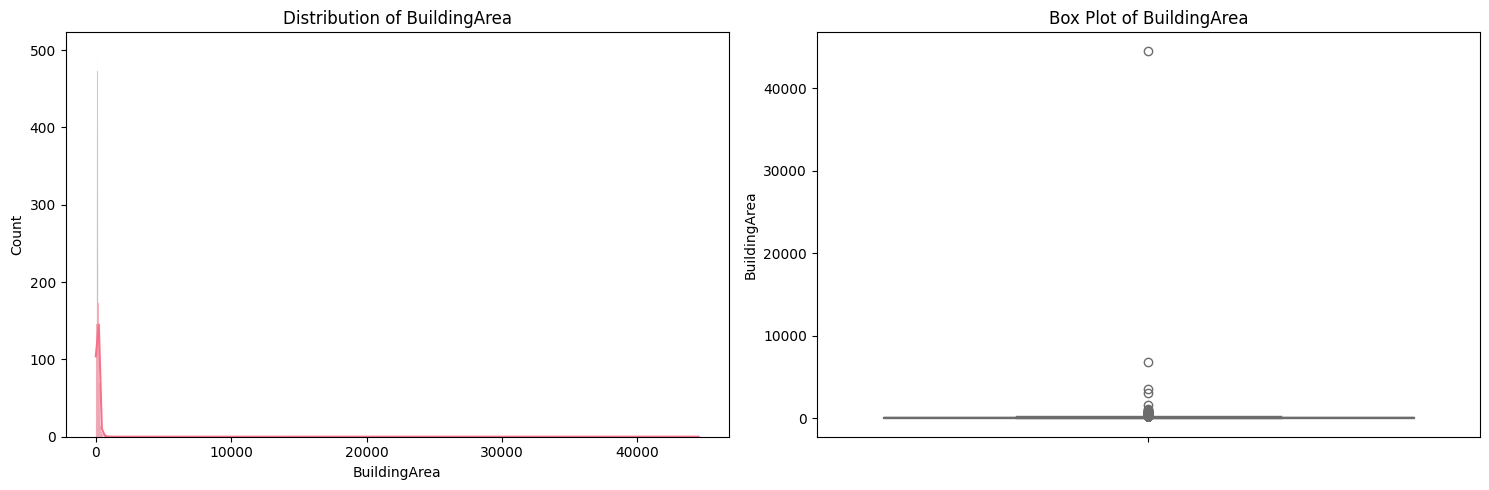

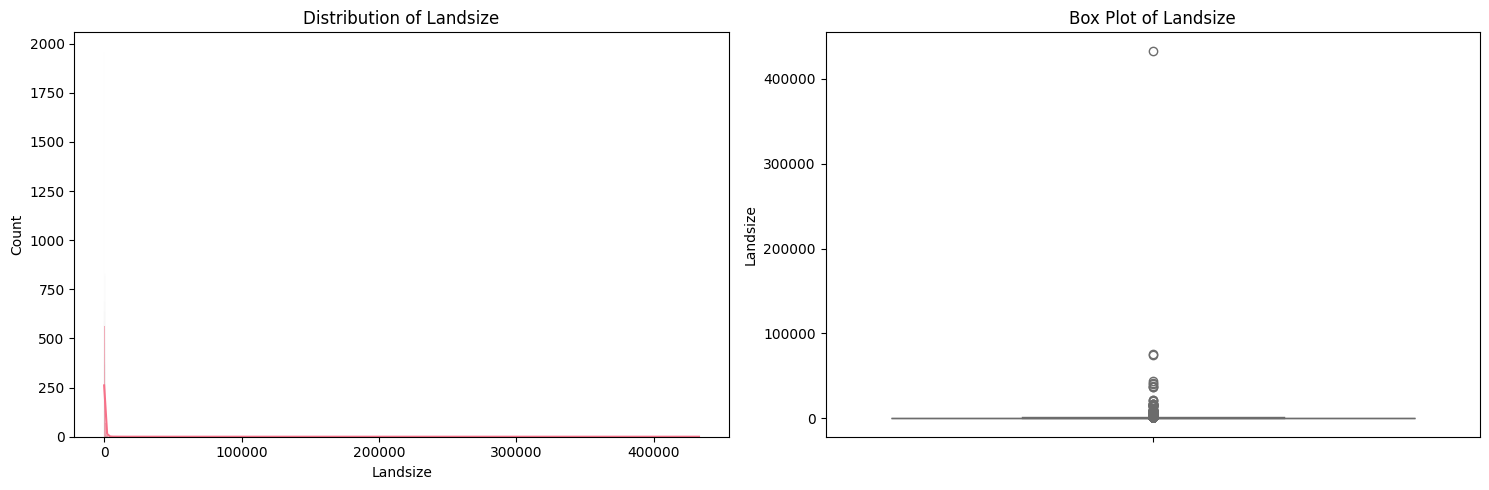

In [10]:
# Analyze property size features
size_features = ['BuildingArea', 'Landsize']
for feature in size_features:
    plot_distribution_and_boxplot(df, feature)
    feature_stats = df[feature].describe()
    for stat_name, stat_value in feature_stats.items():
        mlflow.log_metric(f"{feature.lower()}_{stat_name.lower().replace('%', '')}", stat_value)
    # Log skewness
    mlflow.log_metric(f"{feature.lower()}_skewness", df[feature].skew())

#### Property Size Features Analysis

The analysis of BuildingArea and Landsize reveals extreme distributional characteristics that require careful attention:

##### Common Patterns in Both Features
- Both distributions exhibit severe right skewness, even more pronounced than the price distribution
- The majority of properties cluster in the lower range, creating a dense concentration near zero
- The presence of extreme outliers significantly distorts the scale of both distributions

##### BuildingArea Insights
- Most properties have building areas concentrated below 500 square meters
- Several extreme outliers extend beyond 10,000 square meters
- These extreme values (>44,500 sq.m) are likely data errors or represent non-residential properties
- The severe skewness suggests the need for logarithmic transformation

##### Landsize Observations
- Similar to BuildingArea, most properties have relatively small land sizes
- The presence of properties with land sizes over 400,000 square meters (40 hectares) is highly suspicious
- Such extreme values could represent:
  - Data entry errors
  - Agricultural or development properties incorrectly classified as residential
  - Merged or incorrectly recorded lot sizes

##### Recommendations for Data Preprocessing
1. **Outlier Treatment**
   - Establish reasonable upper bounds for both features
   - Remove or cap extreme values that are clearly erroneous
   - Consider domain knowledge to set appropriate thresholds

2. **Data Transformation**
   - Apply log transformation to normalize distributions
   - Consider binning into categories for very large values

3. **Data Validation**
   - Cross-reference extreme values with property types
   - Verify if extremely large properties are correctly classified as residential

These findings suggest that careful preprocessing of size-related features will be crucial for developing a reliable model.


#### Property Amenities
Examining the distribution of amenity-related features: Bedroom2, Bathroom, and Car spaces.

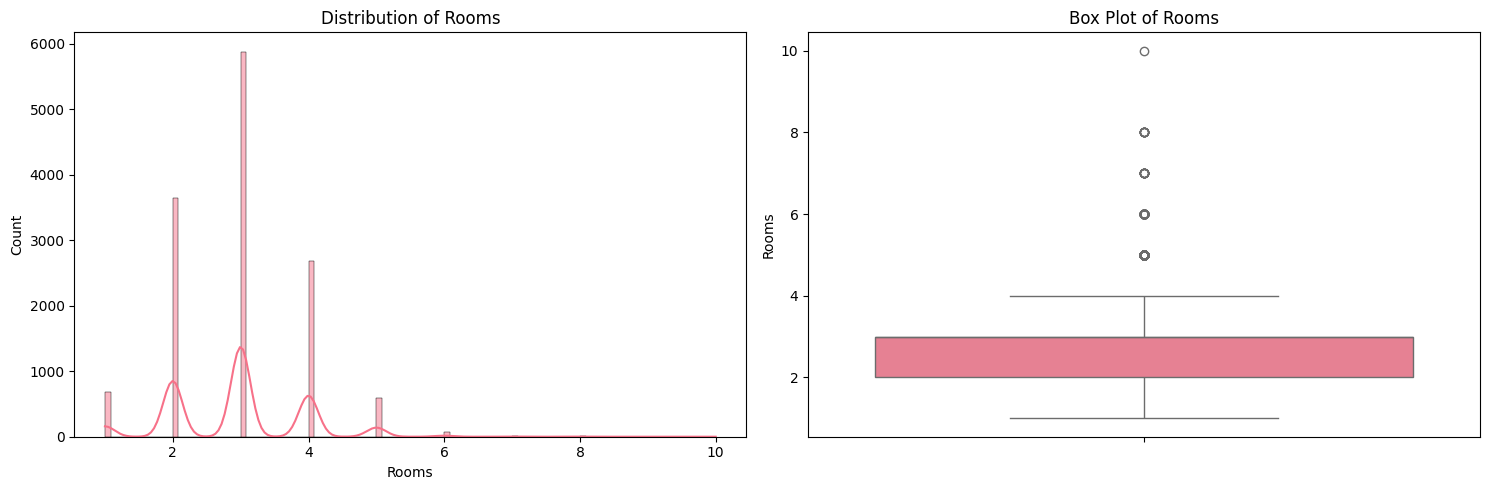

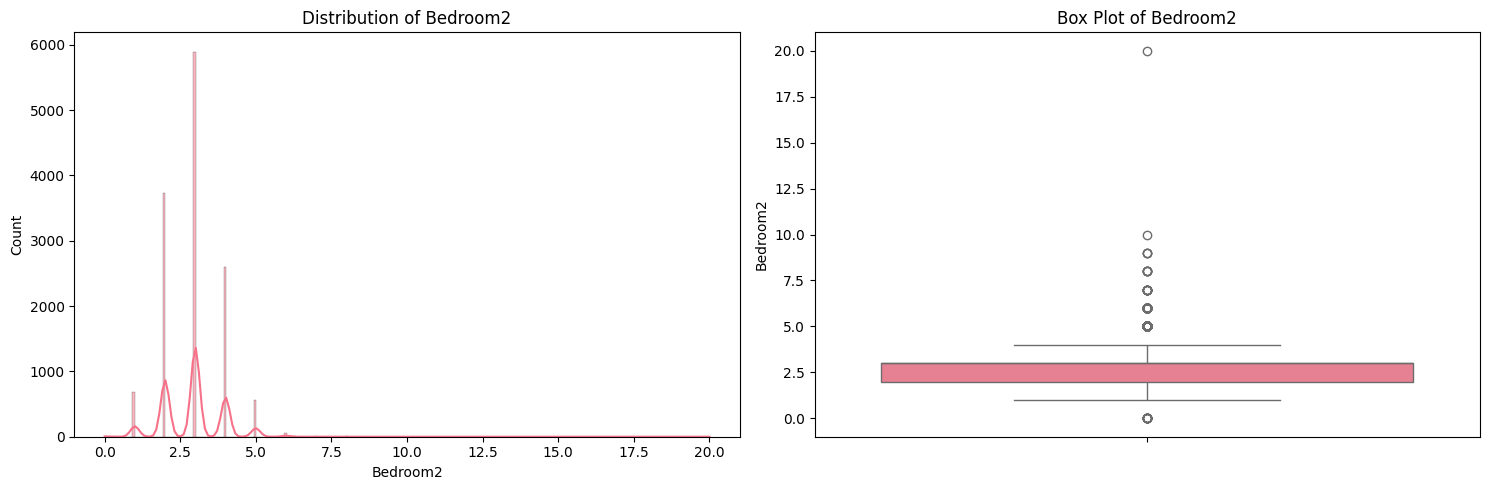

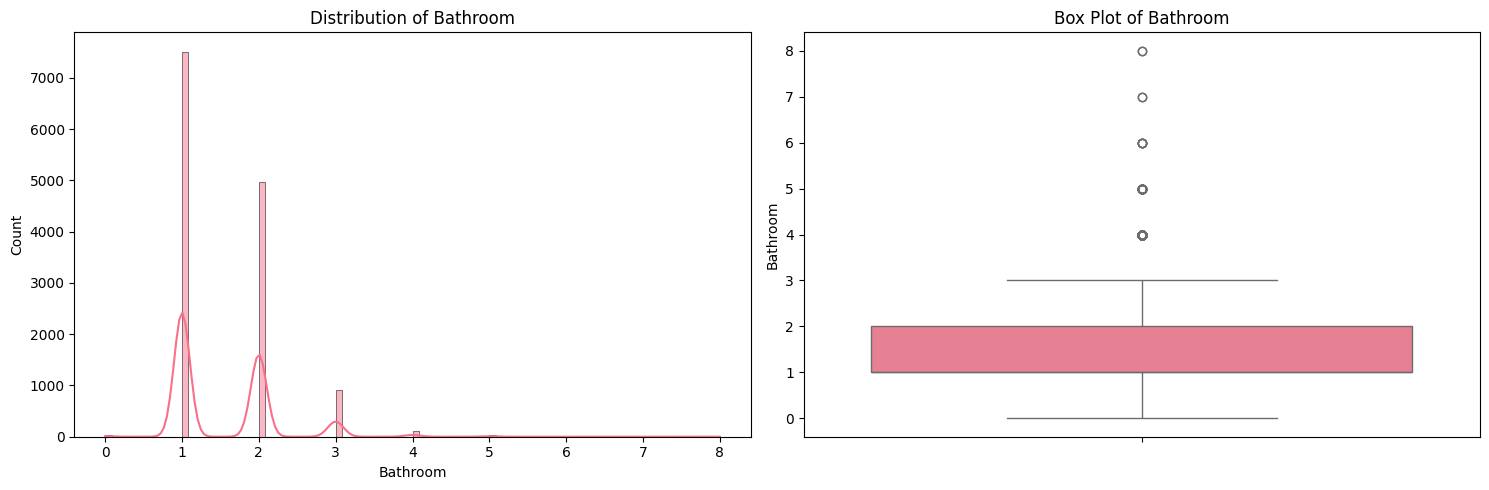

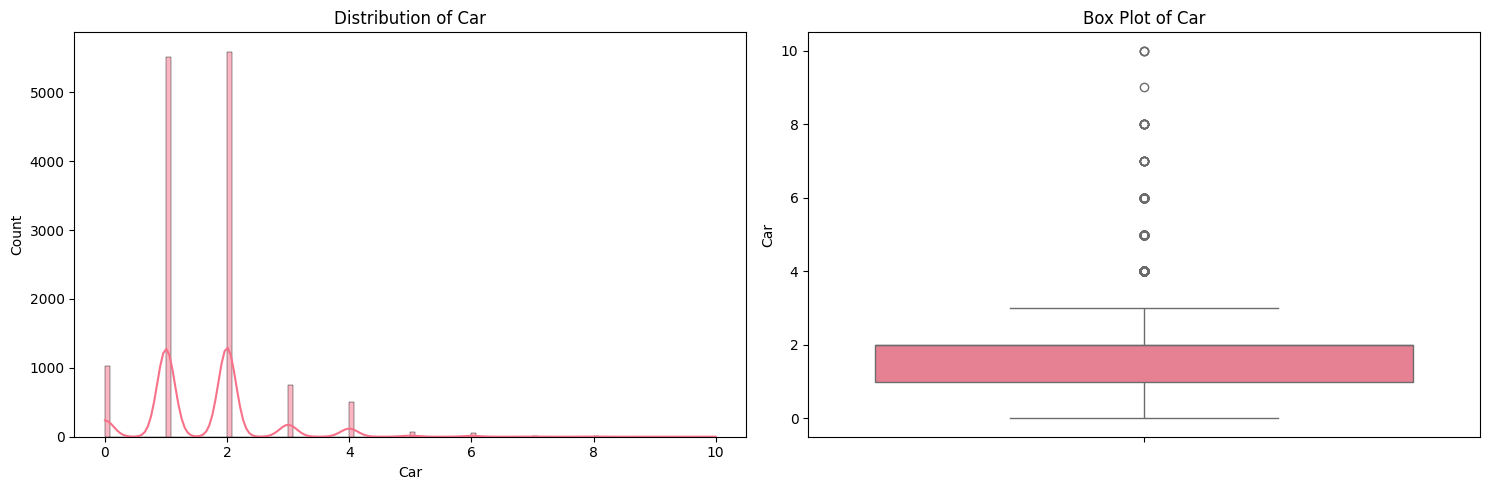

In [11]:
# Analyze amenity features
amenity_features = ['Rooms', 'Bedroom2', 'Bathroom', 'Car']
for feature in amenity_features:
    plot_distribution_and_boxplot(df, feature)
    feature_stats = df[feature].describe()
    for stat_name, stat_value in feature_stats.items():
        mlflow.log_metric(f"{feature.lower()}_{stat_name.lower().replace('%', '')}", stat_value)
    # Log skewness
    mlflow.log_metric(f"{feature.lower()}_skewness", df[feature].skew())

#### Property Amenities Analysis

The analysis of rooms, bedrooms, bathrooms, and car spaces reveals consistent patterns across these amenity features:

#### Distribution Characteristics
- All features show moderate right skewness, less severe than price or property size metrics
- Discrete numerical distributions are observed, as expected for countable features
- Most properties cluster around typical residential values, with clear outliers at higher counts

#### Feature-Specific Observations
1. **Rooms & Bedroom2**
   - Strong correlation between total rooms and bedrooms, as expected
   - Most properties have 2-4 rooms/bedrooms
   - Some properties show unusually high counts (>10), requiring verification
   - Zero-value bedrooms require investigation as they may be data errors

2. **Bathrooms**
   - Majority of properties have 1-2 bathrooms
   - Properties with >4 bathrooms are statistical outliers
   - Distribution aligns with typical residential property characteristics

3. **Car Spaces**
   - Most properties accommodate 1-2 cars
   - Properties with >4 car spaces are outliers
   - Zero car spaces might indicate inner-city properties or missing data

#### Outlier Considerations
- Properties with extremely high counts in any category warrant investigation
- These could represent:
  - Apartment buildings or multi-family dwellings
  - Data entry errors
  - Special-purpose properties (e.g., boarding houses)

#### Next Steps
1. Investigate properties with extreme values (>90th percentile) in each category
2. Cross-validate Rooms against Bedroom2 for consistency
3. Consider creating categorical bins for extreme values
4. Verify zero-value entries, especially for bedrooms and bathrooms

The relatively well-behaved nature of these distributions suggests they may require less dramatic transformation than price or size features.


#### Location Features
Analyzing the distribution of location-related features: Distance and YearBuilt.

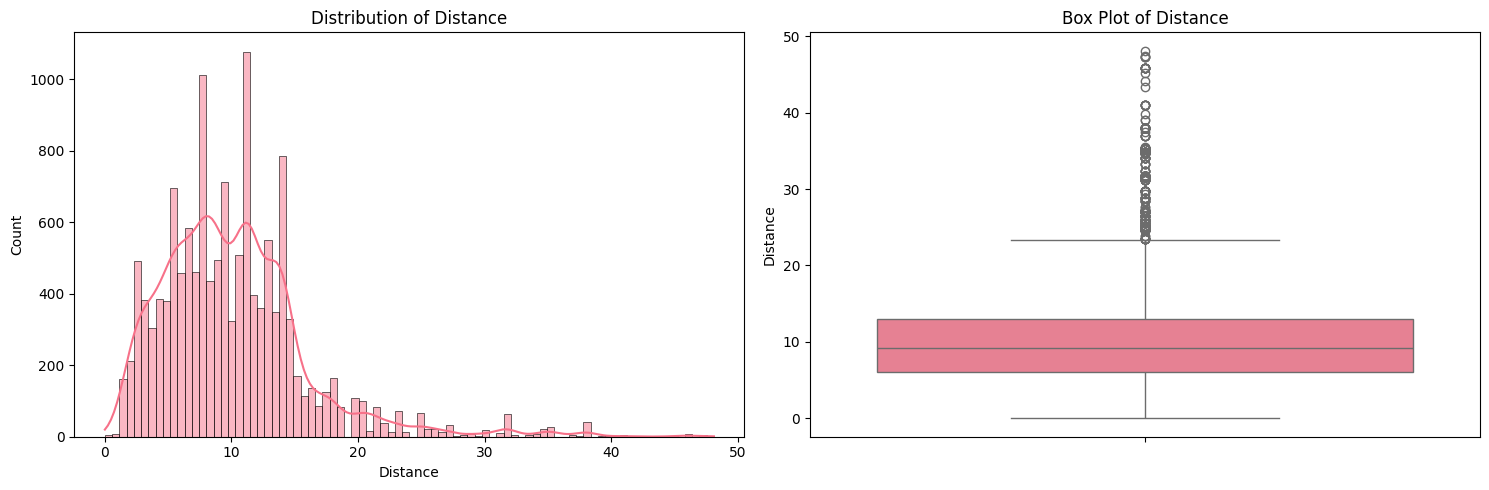

In [12]:
# Analyze location features
plot_distribution_and_boxplot(df, 'Distance')
distance_stats = df["Distance"].describe()
for stat_name, stat_value in distance_stats.items():
    mlflow.log_metric(f"distance_{stat_name.lower().replace('%', '')}", stat_value)
mlflow.log_metric("distance_skewness", df["Distance"].skew())

#### Distance from CBD Analysis

The distribution of properties' distance from Melbourne's CBD presents interesting patterns that differ from our previous analyses:

##### Distribution Characteristics
- Exhibits mild right skewness, notably less pronounced than other features
- More symmetrical than price, property size, or amenity distributions
- Shows a relatively smooth, continuous distribution

##### Key Observations
- Most properties are concentrated within 5-15 km from the CBD
- The median distance appears to be around 10 km
- The distribution tapers off gradually, with fewer properties as distance increases
- Outliers exist beyond approximately 30 km, but they appear more natural and less extreme than outliers in other features

##### Geographic Implications
- Suggests a dense urban core with gradually decreasing property density moving outward
- The mild skewness indicates a fairly balanced spatial distribution of properties
- Outliers likely represent legitimate suburban or peripheral properties rather than data errors

##### Modeling Considerations
- May not require transformation due to its relatively normal distribution
- Distance could be a more reliable predictor due to its well-behaved distribution
- Consider creating distance bands/zones for categorical analysis
- Could be valuable for market segmentation (inner city, middle ring, outer suburbs)

This feature's more balanced distribution suggests it might be directly usable in modeling without significant transformation.


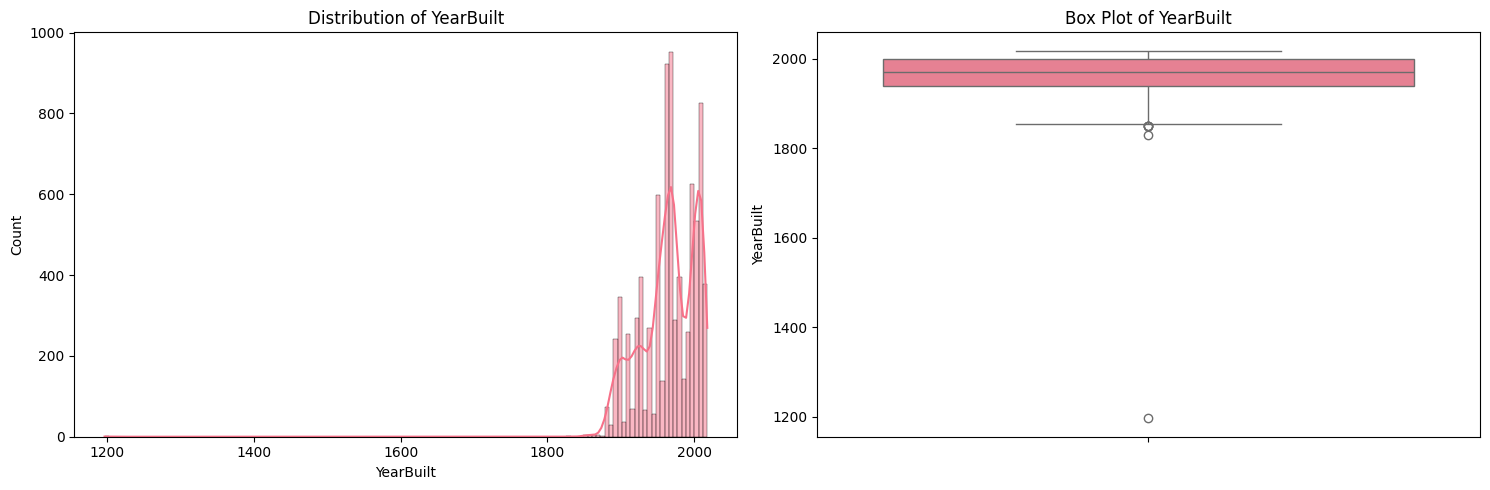

In [13]:
plot_distribution_and_boxplot(df, 'YearBuilt')
yearbuilt_stats = df["YearBuilt"].describe()
for stat_name, stat_value in yearbuilt_stats.items():
    mlflow.log_metric(f"yearbuilt_{stat_name.lower().replace('%', '')}", stat_value)
mlflow.log_metric("yearbuilt_skewness", df["YearBuilt"].skew())

#### Year Built Analysis

The analysis of construction years reveals a unique distribution pattern, distinctly different from our other features:

##### Distribution Characteristics
- Shows clear left skewness, the only feature in our dataset with this characteristic
- Primary concentration of properties built between 1960-2015
- Dense clustering in the post-1970 period
- Significant outlier presence in the extremely low (old) range

##### Anomaly Detection
- A highly suspicious outlier appears around 1196
- This is clearly erroneous as:
  - Melbourne was not settled by Europeans until the 1830s
  - The oldest surviving buildings in Melbourne date to the mid-1800s
  - Construction techniques and materials from 1196 would not have survived
  
##### Distribution Insights
- Median construction year appears to be around 1970
- Modern properties (post-2000) form a significant portion
- Gradual tapering towards newer constructions (2015+)
- Historical properties (pre-1900) represent a small but notable segment

##### Recommendations
1. **Data Cleaning**
   - Remove or correct the 1196 outlier
   - Establish a reasonable minimum year (perhaps 1840)
   - Validate any properties listed before 1850

2. **Feature Engineering Possibilities**
   - Create age bands/categories
   - Calculate property age from construction year
   - Consider decade-based grouping

This feature will require careful cleaning before modeling, but could provide valuable insights into property values based on age and historical significance.


In [14]:

def calculate_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]

    return {
        "Column": column,
        "Outliers Count": len(outliers),
        "Outliers Percentage": (len(outliers) / len(df)) * 100,
        "Min": outliers.min() if len(outliers) > 0 else None,
        "Max": outliers.max() if len(outliers) > 0 else None,
    }

numerical_columns = [
    "Price", "Rooms", "Distance", "Bedroom2", "Bathroom", 
    "Car", "Landsize", "BuildingArea", "YearBuilt",
]

outliers_summary = pd.DataFrame(
    [calculate_outliers(df, col) for col in numerical_columns]
)

display(outliers_summary)

# Log outliers information
for _, row in outliers_summary.iterrows():
    column = row['Column']
    mlflow.log_metric(f"{column.lower()}_outliers_count", row['Outliers Count'])
    mlflow.log_metric(f"{column.lower()}_outliers_percentage", row['Outliers Percentage'])

# Save and log the outliers summary
outliers_summary.to_csv("outliers_summary.csv", index=False)
mlflow.log_artifact("outliers_summary.csv")

Column  Outliers Count  Outliers Percentage        Min        Max
0         Price             612             4.506627  2352500.0  9000000.0
1         Rooms             682             5.022091        5.0       10.0
2      Distance             411             3.026510       23.5       48.1
3      Bedroom2             655             4.823270        0.0       20.0
4      Bathroom             143             1.053019        4.0        8.0
5           Car             644             4.742268        4.0       10.0
6      Landsize             368             2.709867     1364.0   433014.0
7  BuildingArea             353             2.599411      296.0    44515.0
8     YearBuilt               6             0.044183     1196.0     1850.0

#### Outliers Summary Analysis

A comprehensive analysis of outliers across all numerical features reveals varying patterns of extreme values:

##### High Outlier Percentage Features (>4%)
1. **Rooms (5.02%)**
   - Properties with 5-10 rooms marked as outliers
   - May represent large family homes or multi-unit properties

2. **Price (4.51%)**
   - Properties valued between $2.35M-$9M
   - Represents luxury segment of the market

3. **Bedroom2 (4.82%)**
   - Range from 0 (suspicious) to 20 bedrooms
   - High values likely represent apartment buildings

4. **Car (4.74%)**
   - Properties with 4-10 parking spaces
   - Could indicate multi-unit developments or luxury properties

##### Moderate Outlier Percentage Features (2-4%)
1. **Distance (3.03%)**
   - Properties 23.5-48.1 km from CBD
   - Represents outer suburban locations

2. **Landsize (2.71%)**
   - Extreme range: 1,364-433,014 square meters
   - Upper values likely incorrect or non-residential

3. **BuildingArea (2.60%)**
   - Range: 296-44,515 square meters
   - Upper values require verification

##### Low Outlier Percentage Features (<2%)
1. **Bathroom (1.05%)**
   - 4-8 bathrooms
   - Consistent with luxury properties

2. **YearBuilt (0.04%)**
   - Only 6 outliers identified
   - Includes clearly erroneous 1196 value
   - Pre-1850 values require verification

##### Recommendations for Treatment
1. **Critical Investigation Required**
   - YearBuilt outliers (pre-1850)
   - Extreme BuildingArea values
   - Zero-bedroom properties
   - Properties with 433,014 m² landsize

2. **Domain-Knowledge Validation**
   - Properties with >5 rooms
   - Properties with >4 car spaces
   - High-value properties ($2.35M+)

3. **Systematic Approach**
   - Document all outlier treatments
   - Consider impact on model performance
   - Maintain separate outlier-treated dataset version

In [15]:
# Calculate and display skewness
skewness = df[numerical_columns].skew()
print("\nSkewness Analysis:")
display(pd.DataFrame({'Skewness': skewness}))
# Log skewness values
for col, skew_value in skewness.items():
    mlflow.log_metric(f"{col.lower()}_skewness", skew_value)


Skewness Analysis:


Skewness
Price          2.239624
Rooms          0.376478
Distance       1.676937
Bedroom2       0.774082
Bathroom       1.377406
Car            1.369676
Landsize      95.237400
BuildingArea  77.691541
YearBuilt     -1.541279

The skewness values across our features reveal varying degrees of distributional asymmetry, which has important implications for data preprocessing and modeling:

##### Extreme Skewness (>10)
1. **Landsize (95.24)**
   - Extremely right-skewed
   - Indicates severe concentration of smaller properties
   - Suggests mandatory transformation needed
   
2. **BuildingArea (77.69)**
   - Similarly extreme right skew
   - Confirms our visual analysis
   - Requires significant transformation

##### Moderate Positive Skewness (1-3)
1. **Price (2.24)**
   - Typical right skew for property prices
   - Suggests log transformation would be beneficial

2. **Distance (1.68)**
   - Moderate right skew
   - May benefit from mild transformation

3. **Bathroom (1.38) & Car (1.37)**
   - Similar moderate right skew
   - Less concerning for discrete count variables

##### Mild Positive Skewness (<1)
1. **Bedroom2 (0.77)**
   - Slight right skew
   - Acceptable for count data

2. **Rooms (0.38)**
   - Nearly symmetrical
   - May not require transformation

##### Negative Skewness
1. **YearBuilt (-1.54)**
   - Moderate left skew
   - Only feature with negative skewness
   - Consider reflection before transformation if needed

##### Preprocessing Recommendations
1. **Priority Transformations**
   - Log transform: Landsize, BuildingArea
   - Consider log transform: Price
   - Possible Box-Cox: Distance

2. **Minimal Processing**
   - Rooms and Bedroom2 may be used as-is
   - Consider binning for Bathroom and Car

3. **Special Handling**
   - YearBuilt might benefit from age calculation
   - Consider categorical binning by decades

These skewness values will guide our feature transformation strategy during the preprocessing phase.


Number of categories for Type 3
Number of categories for Method 5
Number of categories for Seller 268
Number of categories for CouncilArea 34
Number of categories for Region 8


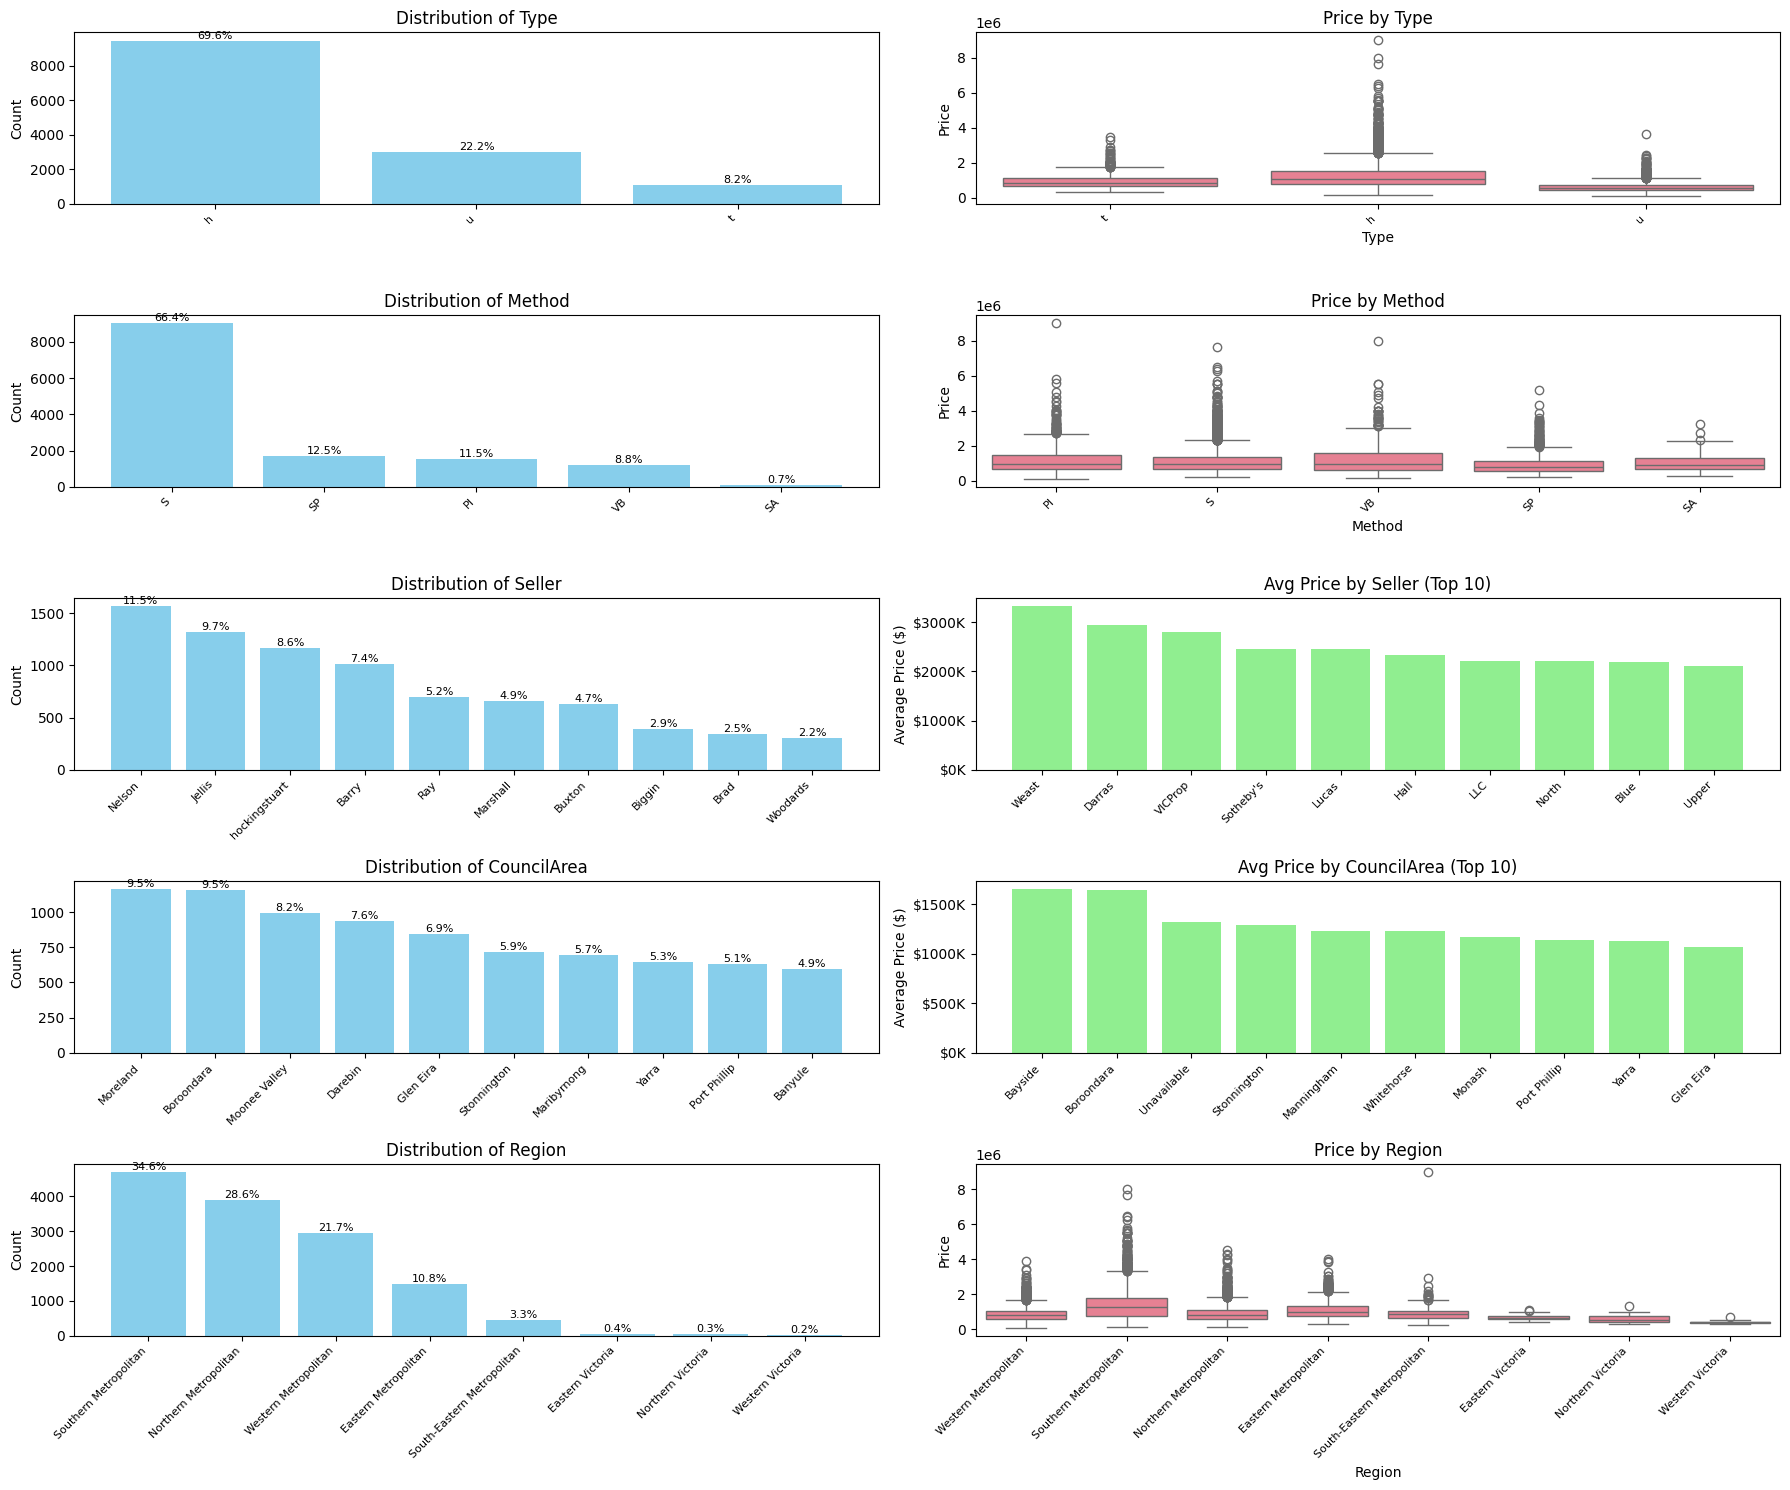

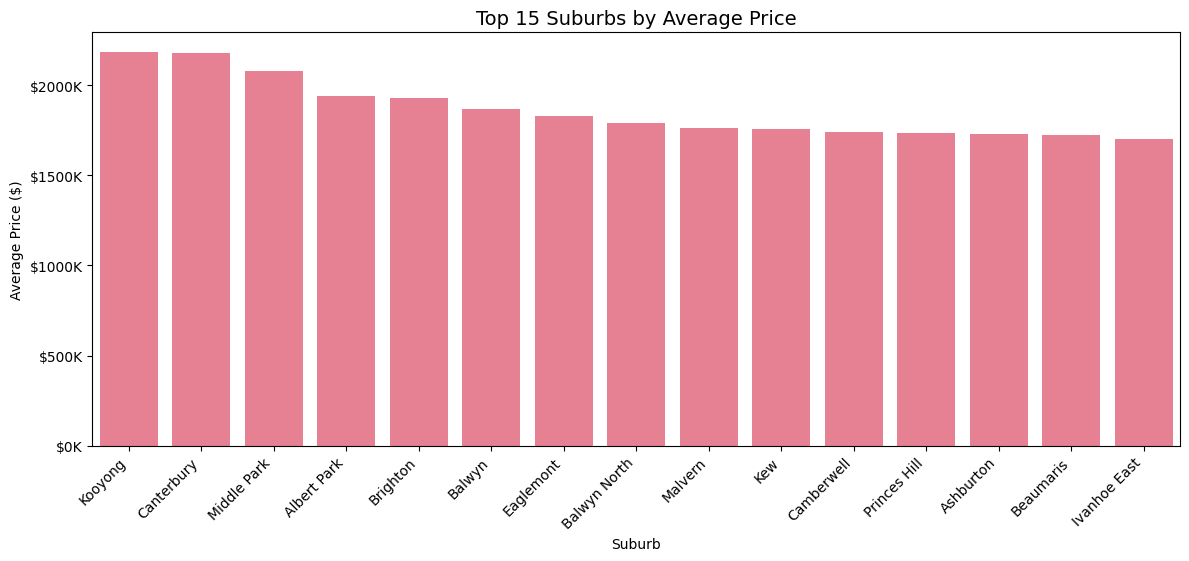

In [16]:
def plot_categorical_distributions(df, categorical_cols, figsize=(18, 15)):
    """
    Create a compact visualization of categorical variables showing:
    1. Distribution of categories (count)
    2. Average price by category
    3. Box plot of price distribution by category (for variables with few categories)
    """
    # Calculate number of rows needed (2 plots per categorical variable)
    n_cols = 2
    n_rows = len(categorical_cols)

    fig = plt.figure(figsize=figsize)
    
    for i, col in enumerate(categorical_cols):
        # Get value counts and calculate percentages
        print(f"Number of categories for {col}", len(df[col].unique()))
        # Log number of categories
        mlflow.log_param(f"{col.lower()}_unique_categories", len(df[col].unique()))
        
        value_counts = df[col].value_counts().head(10)  # Top 10 categories
        total = len(df[~df[col].isna()])
        percentages = (value_counts / total * 100).round(1)
        
        # Add count plot
        ax1 = fig.add_subplot(n_rows, n_cols, i*2+1)
        bars = ax1.bar(
            value_counts.index, 
            value_counts.values, 
            color='skyblue'
        )
        ax1.set_title(f'Distribution of {col}', fontsize=12)
        ax1.set_ylabel('Count')
        
        # Add percentage labels on bars
        for bar, percentage in zip(bars, percentages):
            height = bar.get_height()
            ax1.text(
                bar.get_x() + bar.get_width()/2.,
                height,
                f'{percentage}%',
                ha='center', 
                va='bottom',
                fontsize=8
            )
        
        # Rotate x-axis labels if needed
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=8)
        
        # Add price relationship plot
        ax2 = fig.add_subplot(n_rows, n_cols, i*2+2)
        
        # For variables with few categories, use boxplot
        if df[col].nunique() <= 10:
            sns.boxplot(x=col, y='Price', data=df, ax=ax2)
            ax2.set_title(f'Price by {col}', fontsize=12)
            plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=8)
            
            # Log average price by category
            for category, avg_price in df.groupby(col)['Price'].mean().items():
                mlflow.log_metric(f"avg_price_by_{col.lower()}_{category}", avg_price)
        # For variables with many categories, use bar plot of average prices
        else:
            # Calculate average price by category
            avg_price = df.groupby(col)['Price'].mean().sort_values(ascending=False).head(10)
            ax2.bar(avg_price.index, avg_price.values, color='lightgreen')
            ax2.set_title(f'Avg Price by {col} (Top 10)', fontsize=12)
            ax2.set_ylabel('Average Price ($)')
            plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=8)
            
            # Format y-axis as currency
            ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${int(x/1000)}K'))
        
    
    plt.tight_layout()
    
    # Save and log the figure
    fig_path = "categorical_distributions.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)
    
    plt.show()

categorical_cols = ['Type', 'Method', 'Seller', 'CouncilArea', 'Region']
plot_categorical_distributions(df, categorical_cols)

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 2)
top_suburbs_by_price = df.groupby('Suburb')['Price'].mean().sort_values(ascending=False).head(15)
sns.barplot(x=top_suburbs_by_price.index, y=top_suburbs_by_price.values)
plt.title('Top 15 Suburbs by Average Price', fontsize=14)
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${int(x/1000)}K'))

plt.tight_layout()

# Save and log the figure
fig_path = "top_suburbs_by_price.png"
plt.savefig(fig_path)
mlflow.log_artifact(fig_path)

plt.show()

# Log top 5 suburbs by price
for suburb, price in top_suburbs_by_price.head(5).items():
    mlflow.log_metric(f"top_suburb_price_{suburb}", price)


#### Premium Property Analysis: Top Suburbs, Agencies, and Council Areas

The analysis of average property prices across different categorical variables reveals clear patterns in Melbourne's premium real estate market:

##### Top 10 Suburbs by Average Price

The most expensive suburbs in Melbourne show a clear geographical clustering:

| Suburb | Average Price | Key Characteristics |
|--------|---------------|---------------------|
| Kooyong | 2,185,000 | Prestigious eastern suburb, exclusive tennis club |
| Canterbury | 2,180,241 | Heritage homes, tree-lined streets, excellent schools |
| Middle Park | 2,082,529 | Beachside location, period homes, proximity to CBD |
| Albert Park | 1,941,355 | Lake frontage, Victorian architecture, sports precinct |
| Brighton | 1,930,158 | Bayside location, Brighton Beach bathing boxes |
| Balwyn | 1,869,879 | Eastern suburb known for large blocks and quality schools |
| Eaglemont | 1,831,696 | Elevated views, architectural significance, leafy streets |
| Balwyn North | 1,793,405 | Family-oriented, large homes, Chinese buyer interest |
| Malvern | 1,764,993 | Period homes, boutique shopping, cafe culture |
| Kew | 1,758,435 | Established gardens, heritage properties, river proximity |

**Key Insights:**
- Eastern and Bayside suburbs dominate the premium market
- All top suburbs average over 1.75 million
- Many feature period architecture and heritage significance
- Proximity to amenities (beaches, parks, CBD) is a common factor
- School zones appear to be a significant price driver


### Sub task 3 - Consistency
In this section, we'll analyze the consistency between related features and identify logical inconsistencies in the data.

#### Rooms

In [17]:
# 2. Check for logical constraints on bathrooms and bedrooms
print("\nProperties with zero bathrooms:")
zero_bathrooms = df[df['Bathroom'] == 0]
print(f"Count: {len(zero_bathrooms)} ({len(zero_bathrooms)/len(df)*100:.2f}%)")
display(zero_bathrooms[["Rooms", "Type", "Price", "Bedroom2", "Bathroom", "Landsize", "BuildingArea"]].head(10))
mlflow.log_text(zero_bathrooms[["Rooms", "Type", "Price", "Bedroom2", "Bathroom", "Landsize", "BuildingArea"]].head(10).to_string(),
                "zero_bathrooms_sample.txt")


print("\nProperties with zero bedrooms:")
zero_bedrooms = df[df['Bedroom2'] == 0]
print(f"Count: {len(zero_bedrooms)} ({len(zero_bedrooms)/len(df)*100:.2f}%)")
display(zero_bedrooms[["Rooms", "Type", "Price", "Bedroom2", "Bathroom", "Landsize", "BuildingArea"]].head(10))
mlflow.log_text(zero_bedrooms[["Rooms", "Type", "Price", "Bedroom2", "Bathroom", "Landsize", "BuildingArea"]].head(10).to_string(), 
                "zero_bedrooms_sample.txt")



Properties with zero bathrooms:
Count: 34 (0.25%)


Rooms Type    Price  Bedroom2  Bathroom  Landsize  BuildingArea
158       4    h  1004000         3         0       650           NaN
679       1    u   760500         2         0       438           NaN
762       3    h  1900000         3         0         0           NaN
868       2    u   410000         2         0         0           NaN
937       3    t  1067000         3         0         0           NaN
1560      2    u   740000         2         0         0           NaN
1655      2    h   845000         2         0       207           NaN
2843      2    u   350000         2         0         0           NaN
4343      3    h  1150000         3         0       502           NaN
4770      2    u   700000         2         0         0           NaN


Properties with zero bedrooms:
Count: 16 (0.12%)


Rooms Type    Price  Bedroom2  Bathroom  Landsize  BuildingArea
555       3    t   830000         0         2       292         141.0
626       4    h  2400000         0         2      1252         201.0
871       3    h   585000         0         1       605         103.0
1362      3    h  1355000         0         1       818           NaN
2751      4    h  1026000         0         3       534           NaN
3083      2    u   535000         0         1         0          63.0
5079      3    h   702000         0         0       600           NaN
5317      4    h   678500         0         1       606           NaN
8995      3    h   700000         0         0       456           NaN
9164      3    h  1030000         0         1       224           NaN

##### Analysis of Zero-Value Amenities

Our investigation into properties with zero-value amenities revealed some unusual cases that require attention:

- **34 properties (0.25%)** are listed with zero bathrooms
- **16 properties (0.12%)** are listed with zero bedrooms

These zero-value entries are highly suspicious for residential properties and likely represent data quality issues rather than actual property characteristics. While the percentages are small, these anomalies could have several explanations:

1. **Data Entry Errors**: Simple mistakes during data collection or recording
2. **Missing Data Encoded as Zero**: Instead of using NaN to represent missing information
3. **Non-Residential Properties**: Commercial or development sites incorrectly included in the dataset
4. **Incomplete Properties**: Properties under construction or requiring renovation
5. **Studio Apartments**: In the case of zero bedrooms, these might be studio apartments where the bedroom is not separated from the living area

##### Implications for Analysis:

These zero-value entries could disproportionately affect our model if not properly addressed, especially when calculating averages or training regression models where these values would be treated as legitimate data points.

##### Recommended Actions:

1. **Cross-reference with property type**: Check if these zero-value properties correlate with specific property types (e.g., development sites)
2. **Imputation strategy**: Consider replacing zeros with either:
   - Median values based on similar properties
   - Minimum logical values (1 for both bedrooms and bathrooms)
   - NaN values if they truly represent missing data
3. **Create flags**: Add binary indicator variables to mark properties where these values were imputed
4. **Consider removal**: For the small number of affected properties, removal might be the simplest approach if they appear to be data errors

This finding further emphasizes the need for careful data cleaning and validation before proceeding with modeling.

In [18]:
# 1. Rooms vs. Bedroom2 + Bathroom consistency
print("1. Rooms vs. Bedroom2 + Bathroom:")
rooms_vs_components = df[['Rooms', 'Bedroom2', 'Bathroom']].dropna()
# Calculate total components (bedrooms + bathrooms)
rooms_vs_components['TotalComponents'] = rooms_vs_components['Bedroom2'] + rooms_vs_components['Bathroom']
# Find inconsistent records where components exceed total rooms
inconsistent_components = rooms_vs_components[rooms_vs_components['Rooms'] < rooms_vs_components['TotalComponents']]
print(f"Properties with more bedrooms+bathrooms than total rooms: {len(inconsistent_components)} ({len(inconsistent_components)/len(rooms_vs_components)*100:.2f}%)")

if len(inconsistent_components) > 0:
    print("\nSample of inconsistent records (Rooms < Bedroom2 + Bathroom):")
    display(inconsistent_components.head(5))
    mlflow.log_text(inconsistent_components.head(5).to_string(), "inconsistent_rooms_sample.txt")

1. Rooms vs. Bedroom2 + Bathroom:
Properties with more bedrooms+bathrooms than total rooms: 13320 (98.09%)

Sample of inconsistent records (Rooms < Bedroom2 + Bathroom):


Rooms  Bedroom2  Bathroom  TotalComponents
0      3         3         2                5
1      2         2         1                3
2      2         2         1                3
3      4         3         2                5
4      3         3         2                5

This confirms that Rooms is not "Total rooms"

#### YearBuilt

In [19]:
# 3. Check for properties with unrealistic YearBuilt values
print("\nProperties with unrealistic YearBuilt values:")
unrealistic_year = df[(df['YearBuilt'] < 1840) & (~df['YearBuilt'].isna())]
print(f"Count: {len(unrealistic_year)} ({len(unrealistic_year)/len(df[~df['YearBuilt'].isna()])*100:.2f}%)")

if len(unrealistic_year) > 0:
    print("\nSample of properties with unrealistic YearBuilt values:")
    display(unrealistic_year[['Address', 'YearBuilt', 'Price']].head(5))
    mlflow.log_text(unrealistic_year[['Address', 'YearBuilt', 'Price']].head(5).to_string(), 
                    "unrealistic_year_sample.txt")


# Check for properties built in the future (after data collection)
# Assuming data collection ended in 2018 (based on max date in dataset)
future_buildings = df[(df['YearBuilt'] > 2018) & (~df['YearBuilt'].isna())]
print(f"Properties with future YearBuilt values (>2018): {len(future_buildings)} ({len(future_buildings)/len(df[~df['YearBuilt'].isna()])*100:.2f}%)")


Properties with unrealistic YearBuilt values:
Count: 2 (0.02%)

Sample of properties with unrealistic YearBuilt values:


Address  YearBuilt    Price
63     2/79 Oxford St     1830.0   855000
10229  5 Armstrong St     1196.0  1200000

Properties with future YearBuilt values (>2018): 0 (0.00%)


##### Analysis of Unrealistic Construction Years

Our examination of the YearBuilt feature revealed historically implausible values that require attention:

- **2 properties (0.02% of non-null YearBuilt values)** have construction years before 1840
- These include properties allegedly built in 1830 and 1196

These dates are historically impossible or highly suspicious for Melbourne properties because:

1. **Historical Context**: Melbourne was first settled by Europeans in 1835, making any construction date before this time impossible
2. **Extreme Outlier**: The 1196 construction date predates European arrival in Australia by approximately 600 years
3. **Building Materials**: Structures from the 12th century would not have survived in Australia, particularly using construction methods of that era

The specific problematic entries include:
- A property at 2/79 Oxford St supposedly built in 1830 (selling for 855,000)
- A property at 5 Armstrong St allegedly from 1196 (selling for 1,200,000)

##### Likely Explanations:

1. **Data Entry Errors**: Typographical mistakes (e.g., 1196 instead of 1996)
2. **Misinterpretation**: Heritage properties where renovation dates were confused with original construction
3. **Default Values**: Placeholder values used when the actual construction year was unknown

##### Recommended Actions:

1. **Correction Strategy**:
   - For the 1196 value: Consider it a data entry error and either remove or impute
   - For the 1830 value: Verify if this could be a heritage-listed property with a mistaken date
   
2. **Imputation Approach**:
   - Replace with median YearBuilt values from the same suburb
   - Create a separate category for "historical properties" without specifying exact years
   - Flag these records as having imputed construction years

3. **Data Validation Rule**:
   - Implement a validation rule that flags any construction date before 1840 for review

This finding highlights the importance of domain knowledge in data cleaning, as historical context provides clear boundaries for valid values in temporal features.


#### Landsize vs Building area

In [20]:
# 4. Check for properties with zero land size but non-zero building area
print("\nProperties with zero land size but non-zero building area:")
inconsistent_area = df[(df['Landsize'] == 0) & (df['BuildingArea'] > 0) & (~df['BuildingArea'].isna())]
print(f"Count: {len(inconsistent_area)} ({len(inconsistent_area)/len(df)*100:.2f}% of dataset)")
display(inconsistent_area[["Rooms", "Type", "Price", "Bedroom2", "Bathroom", "Landsize", "BuildingArea"]].head(10))
mlflow.log_text(inconsistent_area[["Rooms", "Type", "Price", "Bedroom2", "Bathroom", "Landsize", "BuildingArea"]].head(10).to_string(), 
                "inconsistent_area_sample.txt")


Properties with zero land size but non-zero building area:
Count: 1061 (7.81% of dataset)


Rooms Type    Price  Bedroom2  Bathroom  Landsize  BuildingArea
8       2    u   599000         2         1         0          76.0
13      3    h   750000         3         1         0         103.0
39      2    u   521500         2         1         0          69.0
50      3    u   820000         3         1         0          96.0
52      2    u   722500         2         1         0         100.0
62      2    u  1260000         2         1         0         129.0
67      1    u   520000         1         1         0          51.0
71      2    u   550000         2         1         0          83.0
72      2    u   396000         2         1         0          56.0
75      3    h  1252000         3         2         0         137.0

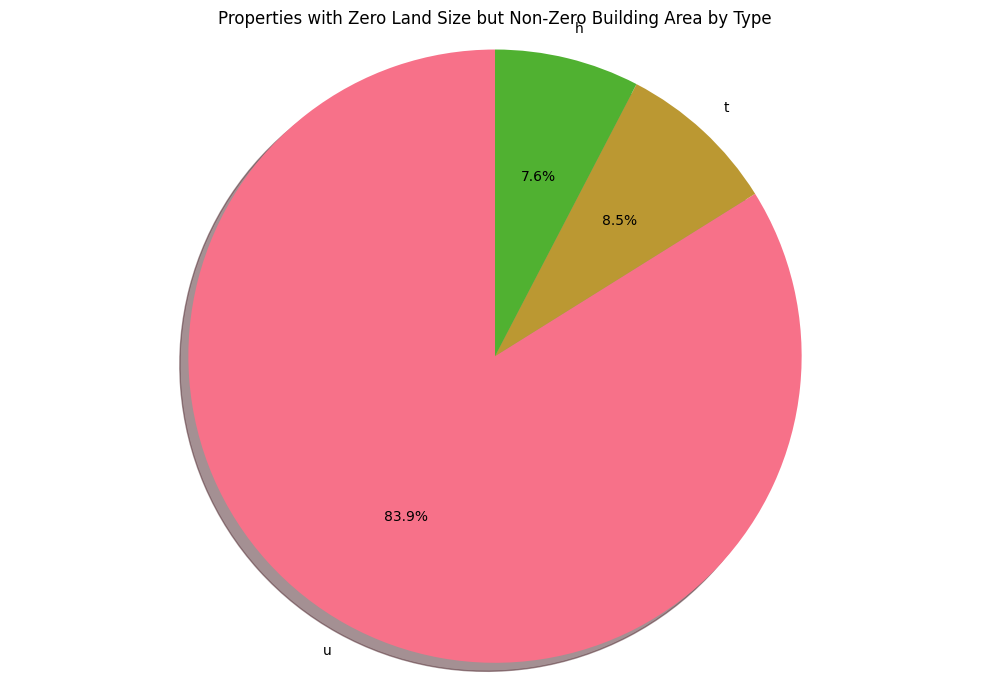

In [21]:
# Count by property type
type_counts = inconsistent_area['Type'].value_counts()

# Create pie chart
plt.figure(figsize=(10, 7))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90, shadow=True)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Properties with Zero Land Size but Non-Zero Building Area by Type')
plt.tight_layout()
# Save figure to buffer and log as artifact
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
mlflow.log_image(Image.open(buf), "inconsistent_area_by_type.png")

plt.show()

In [22]:
# Calculate percentages within each property type
property_types = df['Type'].unique()
print("\nPercentage of each property type with this inconsistency:")
for prop_type in property_types:
    total_of_type = len(df[df['Type'] == prop_type])
    inconsistent_of_type = len(inconsistent_area[inconsistent_area['Type'] == prop_type])
    if total_of_type > 0:
        percentage = (inconsistent_of_type / total_of_type) * 100
        mlflow.log_metric(f"inconsistent_percentage_type_{prop_type}", percentage)
        print(f"Type '{prop_type}': {inconsistent_of_type}/{total_of_type} ({percentage:.2f}% of {prop_type})")


Percentage of each property type with this inconsistency:
Type 't': 90/1114 (8.08% of t)
Type 'h': 81/9449 (0.86% of h)
Type 'u': 890/3017 (29.50% of u)


In [23]:
# Check for units (Type 'u') with non-zero land size
units_with_land = df[(df['Type'] == 'u') & (df['Landsize'] > 0) & (~df['Landsize'].isna())]
print(f"Units with non-zero land size: {len(units_with_land)} ({len(units_with_land)/len(df[df['Type'] == 'u'])*100:.2f}% of units)")

# Display sample of these units with their land sizes
print("\nSample of units with non-zero land size:")
display(units_with_land[['Address', 'Type', 'Landsize', "BuildingArea", 'Price']].head(10))
mlflow.log_text(units_with_land[['Address', 'Type', 'Landsize', "BuildingArea", 'Price']].head(10).to_string(), 
                "units_with_land_sample.txt")

Units with non-zero land size: 1388 (46.01% of units)

Sample of units with non-zero land size:


Address Type  Landsize  BuildingArea   Price
22      5/205 Centre Rd    u       202           NaN  636000
24   1/236 Patterson Rd    u       348         121.0  875000
40     19a Elizabeth St    u       385         140.0  851000
63       2/79 Oxford St    u      2886         122.0  855000
65     2/20 Wetherby Rd    u        65           NaN  492500
70   1/28 Gilbertson St    u       263         113.0  660000
76         233/4 Bik La    u      4332          85.0  700000
94    1/30 Grenville St    u       228          87.0  895000
97       3/31 Thomas St    u       832           NaN  720000
130   6/1015 Nepean Hwy    u       106          51.0  380500

##### Analysis of Area Inconsistencies: Zero Land Size with Non-Zero Building Area

Our investigation revealed a significant data inconsistency regarding property areas:

- **1,061 properties (7.81% of the dataset)** have zero land size but positive building area
- This represents a logical impossibility, as buildings must occupy land

This substantial inconsistency affects nearly 8% of our dataset and points to systematic data collection or recording issues rather than random errors. Several explanations are possible:

1. **Apartment Units**: These could be apartments or units where:
   - Individual units have their own building area
   - Land size is recorded as zero because residents don't own individual land portions
   - The land is communally owned by the building's owners corporation/body corporate
   - However, 46% of units have non-zero landsizes

2. **Data Collection Methodology**: Different sources or methods for collecting these two measurements:
   - BuildingArea might be accurately measured for individual units
   - Landsize might be recorded as zero for properties without individual land titles

3. **Missing Data Encoding**: Zeros might represent missing data rather than actual measurements:
   - Land size might be unknown and encoded as zero instead of null
   - This practice creates misleading data patterns

##### Implications for Analysis:

This inconsistency significantly impacts any analysis involving property density, price per square meter calculations, or features derived from the relationship between building and land areas.

##### Recommended Actions:

1. **Property Type Verification**:
   - Cross-reference with the 'Type' column to confirm if these are predominantly apartments/units
   - Check if these properties share common addresses (same building, different units)

2. **Feature Engineering**:
   - Create a binary flag indicating "apartment/unit with no individual land"
   - Consider a combined "total area" feature that uses building area when land size is zero

3. **Imputation Strategy**:
   - For apartments, consider using average land size per unit based on similar properties
   - Alternatively, create a derived "land share" estimate based on building area and typical ratios

4. **Separate Modeling**:
   - Consider developing separate models for houses (with land) and apartments (without individual land)
   - This approach would account for the fundamentally different property characteristics

This finding highlights a critical data structure issue that must be addressed before modeling to avoid biased predictions, particularly for apartment properties.


In [24]:
# Calculate building area to land size ratio
building_exceeds_land = df[(df['BuildingArea'] > df['Landsize']) & 
                          (df['Landsize'] > 0) & 
                          (~df['BuildingArea'].isna())].copy()

# Add ratio column
building_exceeds_land['BuildingToLandRatio'] = building_exceeds_land['BuildingArea'] / building_exceeds_land['Landsize']

# Create categories based on ratio
building_exceeds_land['RatioCategory'] = pd.cut(
    building_exceeds_land['BuildingToLandRatio'],
    bins=[1, 2, 3, float('inf')],
    labels=['1-2x', '2-3x', '>3x']
)

# Count by ratio category and property type
ratio_type_counts = pd.crosstab(building_exceeds_land['Type'], building_exceeds_land['RatioCategory'])
print("Distribution of building-to-land ratios by property type:")
display(ratio_type_counts)
mlflow.log_text(ratio_type_counts.to_string(), "ratio_type_distribution.txt")

# Calculate percentages
ratio_percentages = ratio_type_counts.div(ratio_type_counts.sum(axis=1), axis=0) * 100
print("\nPercentage distribution of ratios within each property type:")
display(ratio_percentages.round(2))
mlflow.log_text(ratio_percentages.round(2).to_string(), "ratio_percentages_by_type.txt")

Distribution of building-to-land ratios by property type:


RatioCategory  1-2x  2-3x  >3x
Type                          
h               140     5    6
t                80     5    2
u                19     3    2


Percentage distribution of ratios within each property type:


RatioCategory   1-2x   2-3x   >3x
Type                             
h              92.72   3.31  3.97
t              91.95   5.75  2.30
u              79.17  12.50  8.33

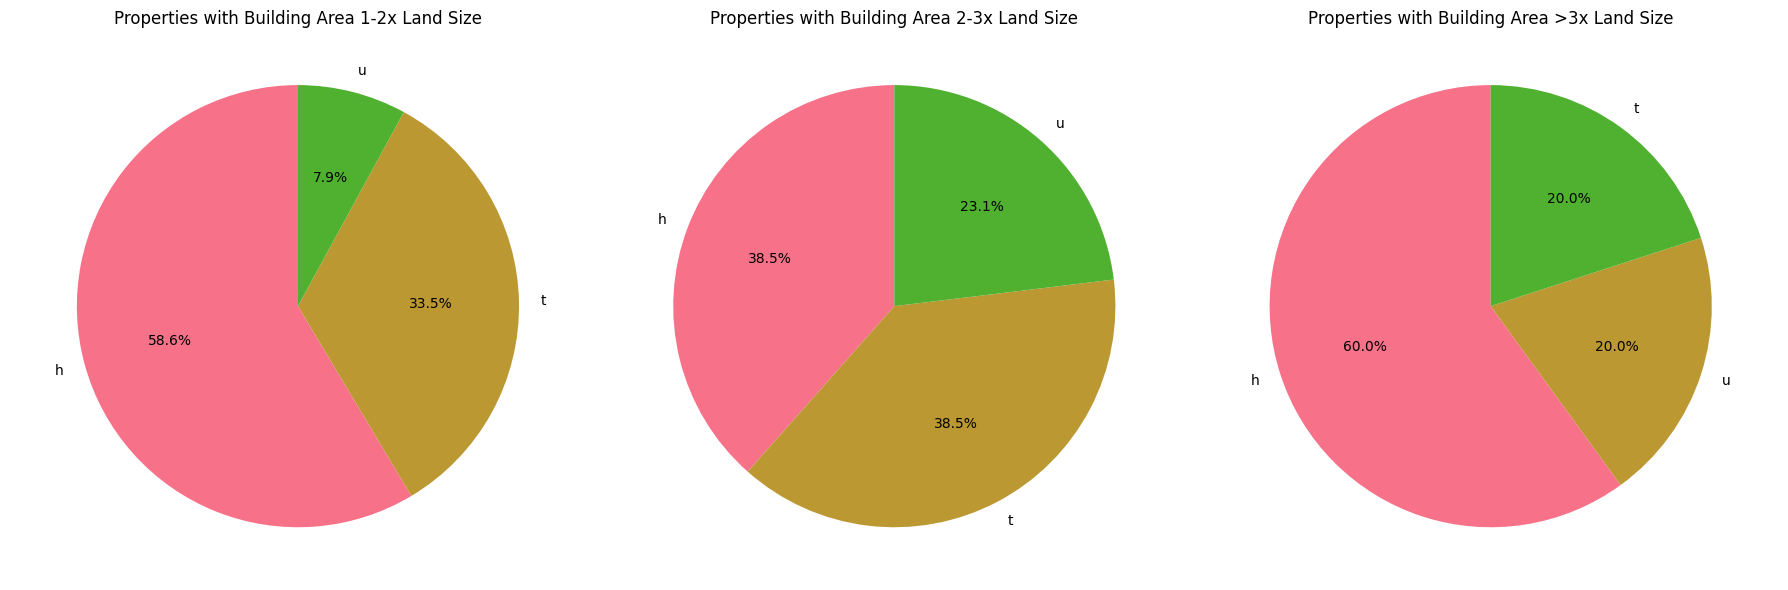

In [25]:
# Create pie charts for each ratio category
plt.figure(figsize=(18, 6))

# Plot for ratios 1-2x
plt.subplot(1, 3, 1)
ratio_1_2 = building_exceeds_land[building_exceeds_land['RatioCategory'] == '1-2x']['Type'].value_counts()
plt.pie(ratio_1_2, labels=ratio_1_2.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Properties with Building Area 1-2x Land Size')

# Plot for ratios 2-3x
plt.subplot(1, 3, 2)
ratio_2_3 = building_exceeds_land[building_exceeds_land['RatioCategory'] == '2-3x']['Type'].value_counts()
plt.pie(ratio_2_3, labels=ratio_2_3.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Properties with Building Area 2-3x Land Size')

# Plot for ratios >3x
plt.subplot(1, 3, 3)
ratio_3_plus = building_exceeds_land[building_exceeds_land['RatioCategory'] == '>3x']['Type'].value_counts()
plt.pie(ratio_3_plus, labels=ratio_3_plus.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Properties with Building Area >3x Land Size')

plt.tight_layout()
# Save figure to buffer and log as artifact
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
mlflow.log_image(Image.open(buf), "building_to_land_ratio_by_type.png")
plt.show()

In [26]:
# Show extreme cases (highest ratios)
print("\nTop 10 properties with highest building-to-land ratios:")
display(building_exceeds_land[['Address', 'Type', 'Landsize', 'BuildingArea', 'BuildingToLandRatio']]
        .sort_values('BuildingToLandRatio', ascending=False)
        .head(10))
mlflow.log_text(building_exceeds_land[['Address', 'Type', 'Landsize', 'BuildingArea', 'BuildingToLandRatio']]
        .sort_values('BuildingToLandRatio', ascending=False)
        .head(10).to_string(), "extreme_ratio_properties.txt")

# Summary statistics of ratios by property type
print("\nSummary statistics of building-to-land ratios by property type:")
display(building_exceeds_land.groupby('Type')['BuildingToLandRatio'].describe())


Top 10 properties with highest building-to-land ratios:


Address Type  Landsize  BuildingArea  BuildingToLandRatio
4129       4/463 South Rd    u         1          62.0            62.000000
13056    32/637 Orrong Rd    t         3         131.0            43.666667
9958          7 MacKay St    t        15         147.0             9.800000
4719      19 Warringal St    h       732        6791.0             9.277322
4413   125/33 Jeffcott St    u        17          90.0             5.294118
10955          14 Rose St    h        43         205.0             4.767442
10586       77 Suffolk St    h       161         700.0             4.347826
6073      46 Athelstan Rd    h       730        3112.0             4.263014
7071         15 Argyle St    h        60         200.0             3.333333
11808         7 Garnet St    h       343        1041.0             3.034985


Summary statistics of building-to-land ratios by property type:


count      mean        std       min       25%       50%       75%  \
Type                                                                       
h     151.0  1.387383   0.874437  1.000337  1.044585  1.126866  1.344444   
t      87.0  1.960078   4.628115  1.007937  1.072508  1.285855  1.613908   
u      24.0  4.030682  12.382592  1.011494  1.072538  1.161402  1.618755   

            max  
Type             
h      9.277322  
t     43.666667  
u     62.000000

##### Analysis of Area Inconsistencies: Building Area Exceeding Land Size

Our investigation identified another significant logical inconsistency in the property measurements:

- **262 properties (3.67% of properties with non-null BuildingArea)** have building areas that exceed their land size
- This represents a physical impossibility for single-story buildings, as structures cannot occupy more land than is available

The sample data reveals diverse property types exhibiting this inconsistency:
- A townhouse (t) at 186 Queens Pde with building area (3,558 m²) significantly exceeding land size (2,778 m²)
- Multiple houses (h) with building areas 1.1-2.8 times larger than their land size
- Both houses and townhouses showing this pattern

##### Possible Explanations:

1. **Multi-Story Buildings**: The most plausible explanation for most cases:
   - A two-story building can have floor area up to twice its footprint
   - Three or more stories can create even larger ratios
   - The Queens Pde property likely has multiple stories to achieve its 1.28 ratio

2. **Measurement Inconsistencies**:
   - BuildingArea might include all floor levels while Landsize refers only to the lot dimensions
   - Different measurement standards between data sources (internal vs. external measurements)

3. **Data Entry Errors**:
   - Units of measurement might be inconsistent (e.g., square feet vs. square meters)
   - Decimal point errors or digit transposition

4. **Property Type Factors**:
   - Townhouses might include common areas in their building measurements
   - Houses with basement levels might count this space in building area

##### Implications for Analysis:

This inconsistency affects calculations involving building-to-land ratios, property density metrics, and potentially price predictions based on these features.

##### Recommended Actions:

1. **Create Derived Features**:
   - Calculate floor-area ratio (BuildingArea/Landsize) as a new feature
   - Flag properties with ratios >1 for special handling

2. **Property Type Analysis**:
   - Analyze whether this inconsistency correlates with specific property types
   - Determine typical ratios for different building styles (houses vs. townhouses)

3. **Data Correction Approach**:
   - For extreme cases (ratios >3), investigate potential data entry errors
   - Consider capping building-to-land ratios at reasonable maximum values based on property type

4. **Feature Engineering**:
   - Create a "likely stories" feature derived from the building-to-land ratio
   - Consider this ratio as a potential predictor of property value

This finding suggests that while some of these cases may represent multi-story buildings, others likely indicate data quality issues that should be addressed before modeling.

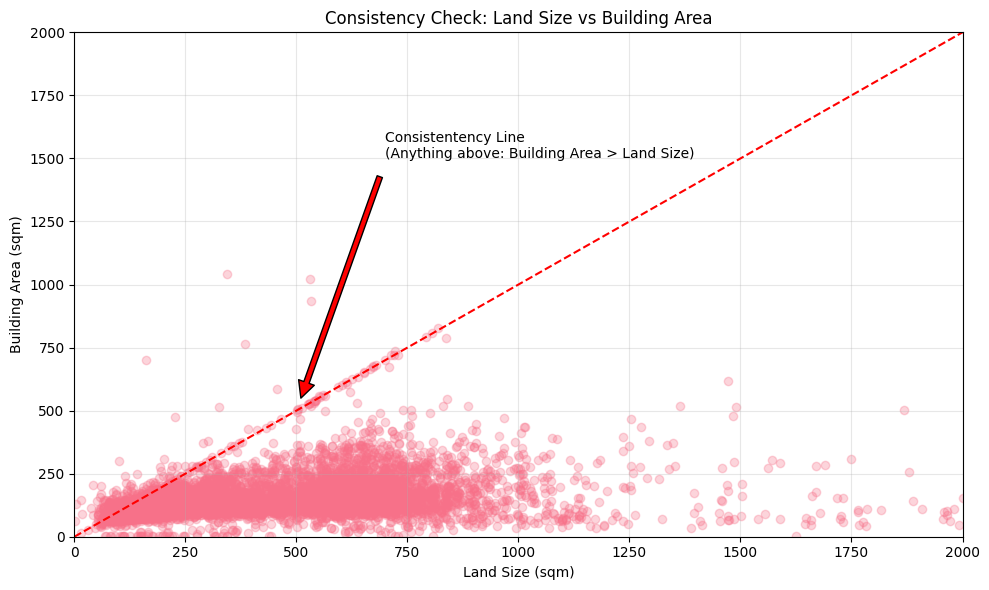

In [27]:
# 9. Visualize the relationship between BuildingArea and Landsize
valid_areas = df[(df['BuildingArea'] > 0) & (df['Landsize'] > 0) & (~df['BuildingArea'].isna())]
plt.figure(figsize=(10, 6))
plt.scatter(valid_areas['Landsize'], valid_areas['BuildingArea'], alpha=0.3)
plt.plot([0, 2000], [0, 2000], 'r--')
plt.xlabel('Land Size (sqm)')
plt.ylabel('Building Area (sqm)')
plt.title('Consistency Check: Land Size vs Building Area')
plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.grid(True, alpha=0.3)
plt.annotate('Consistentency Line\n(Anything above: Building Area > Land Size)', 
             xy=(500, 500), 
             xytext=(700, 1500),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.tight_layout()
# Save figure to buffer and log as artifact
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
mlflow.log_image(Image.open(buf), "land_vs_building_area.png")

plt.show()

##### Visual Analysis: Land Size vs. Building Area Consistency

This scatter plot provides a revealing visualization of the relationship between land size and building area, highlighting logical inconsistencies in the dataset:

- **The red dashed line** represents the theoretical boundary where Building Area = Land Size
- **Points above this line** represent properties where the building area exceeds the land size
- **The concentration of data points** below the line shows that most properties maintain logical consistency

The visualization reveals several important patterns:

1. **Concentration of Inconsistencies**:
   - Inconsistencies are particularly prevalent among properties with smaller land sizes (<500 sqm)
   - Some extreme cases show building areas 2-3 times larger than the land size
   - One notable outlier claims over 1000 sqm of building area on less than 375 sqm of land

2. **Distribution Patterns**:
   - Most properties cluster in the lower ranges of both metrics (small to medium properties)
   - The density of points decreases as either land size or building area increases
   - The relationship between land and building size becomes more consistent for larger properties

3. **Multi-Story Implications**:
   - Many points above the line likely represent multi-story buildings
   - The ratio of building area to land size provides insight into building height/density
   - Properties with ratios >2 suggest buildings with 3+ stories or potential data errors

##### Interpretation of Inconsistencies:

While some properties above the line represent valid multi-story buildings, the extreme outliers suggest data quality issues. In urban settings, it's common for buildings to have floor area ratios (FAR) between 1-3, but values significantly higher than this are suspicious.

The concentration of inconsistencies among smaller properties might indicate:
1. Higher density development in areas with limited land
2. Apartment buildings or townhouses with stacked units
3. Measurement or recording errors more common for certain property types

##### Implications for Data Preprocessing:

This visualization confirms the need for careful handling of area measurements, particularly for:
1. Creating derived features like floor-area ratio (FAR)
2. Identifying and potentially correcting extreme outliers
3. Considering property type when evaluating the reasonableness of area measurements

For modeling purposes, properties with extreme building-to-land ratios might need special treatment, either through transformation, flagging with indicator variables, or exclusion from training data if they represent clear errors rather than genuine high-density developments.


#### Price/sqm

In [28]:
print("\n3. Price vs. BuildingArea consistency:")
# Calculate price per square meter
df['PricePerSqm'] = df['Price'] / df['BuildingArea']
# Define reasonable bounds for Melbourne property market
extreme_price_per_sqm = df[(~df['PricePerSqm'].isna()) & 
                          ((df['PricePerSqm'] < 1000) | (df['PricePerSqm'] > 20000))]
print(f"Properties with extreme price per square meter (<$1000 or >$20000): {len(extreme_price_per_sqm)} ({len(extreme_price_per_sqm)/len(df[~df['PricePerSqm'].isna()])*100:.2f}%)")

if len(extreme_price_per_sqm) > 0:
    print("\nSample of properties with extreme price per square meter:")
    display(extreme_price_per_sqm[['Address', 'Type', 'Price', 'BuildingArea', 'PricePerSqm']].head(5))
    mlflow.log_text(
        extreme_price_per_sqm[['Address', 'Type', 'Price', 'BuildingArea', 'PricePerSqm']].head(5).to_string(),
        "extreme_price_per_sqm_sample.txt"
    )

df = df.drop('PricePerSqm', axis=True)


3. Price vs. BuildingArea consistency:
Properties with extreme price per square meter (<$1000 or >$20000): 174 (2.44%)

Sample of properties with extreme price per square meter:


Address Type    Price  BuildingArea    PricePerSqm
81       186 Queens Pde    t   930000        3558.0     261.382799
91        31 Seggan Cir    t   532000          19.0   28000.000000
113         43 Oswin St    h  2490000          14.0  177857.142857
323       2/74 Daley St    t   555000           3.0  185000.000000
356  30/20 Pakington St    u   520000          12.0   43333.333333

##### Analysis of Extreme Price per Square Meter

Our calculation of price per square meter (Price/BuildingArea) revealed properties with values outside the expected range for Melbourne's real estate market:

- **174 properties (2.44% of properties with calculable price per square meter)** have extreme values
- These properties fall outside the reasonable range of $1,000-$20,000 per square meter

This analysis identifies outliers that may represent either:
1. Genuine market anomalies (extremely cheap or premium properties)
2. Data quality issues affecting price or area measurements

##### Potential Explanations for Low Values (<$1,000/m²):

1. **Data Entry Errors**:
   - Incorrectly recorded building areas (too large)
   - Decimal point errors in either price or area
   
2. **Property Condition Issues**:
   - Severely damaged or uninhabitable properties
   - Properties requiring complete renovation
   
3. **Remote Locations**:
   - Properties in far outer suburbs with significantly lower market values
   - Rural properties included in the dataset

##### Potential Explanations for High Values (>$20,000/m²):

1. **Premium Locations**:
   - Ultra-luxury properties in exclusive neighborhoods
   - Properties with exceptional views or amenities
   
2. **Measurement Errors**:
   - Incorrectly recorded building areas (too small)
   - Only partial building area recorded
   
3. **Land Value Dominance**:
   - Properties where the majority of value is in the land rather than the building
   - Development sites where existing structures are minimal

##### Implications for Analysis:

These extreme values could significantly skew models that incorporate price per square meter or similar derived features, potentially leading to unreliable predictions.

##### Recommended Actions:

1. **Segmentation Analysis**:
   - Separate analysis of properties with extreme values to identify patterns
   - Check for correlations with specific suburbs, property types, or other features

2. **Data Validation**:
   - Cross-reference extreme cases with external sources where possible
   - Verify if these properties have other anomalous characteristics

3. **Modeling Strategy**:
   - Consider winsorizing or trimming extreme values
   - Create price brackets or logarithmic transformations to reduce the impact of outliers
   - Potentially exclude these properties from training data if they represent clear errors

4. **Feature Engineering**:
   - Create a flag for properties with extreme price per square meter
   - Consider neighborhood-relative price per square meter to identify local anomalies

This finding highlights the importance of derived metrics in identifying potential data quality issues that might not be apparent when examining individual features in isolation.


Having such a high amount of total component be larger than rooms, its more likely than rooms represent rooms other than bedrooms and bathrooms. Guest rooms, bomb shelters etc are irrelevant to the number of bedrooms and bathrooms there are.

Thus, we've learnt that rooms represent "Other rooms", and we should rename it as such, so that when users send a prediction, it would be clearer and avoid consistency issues.

#### Issues identified

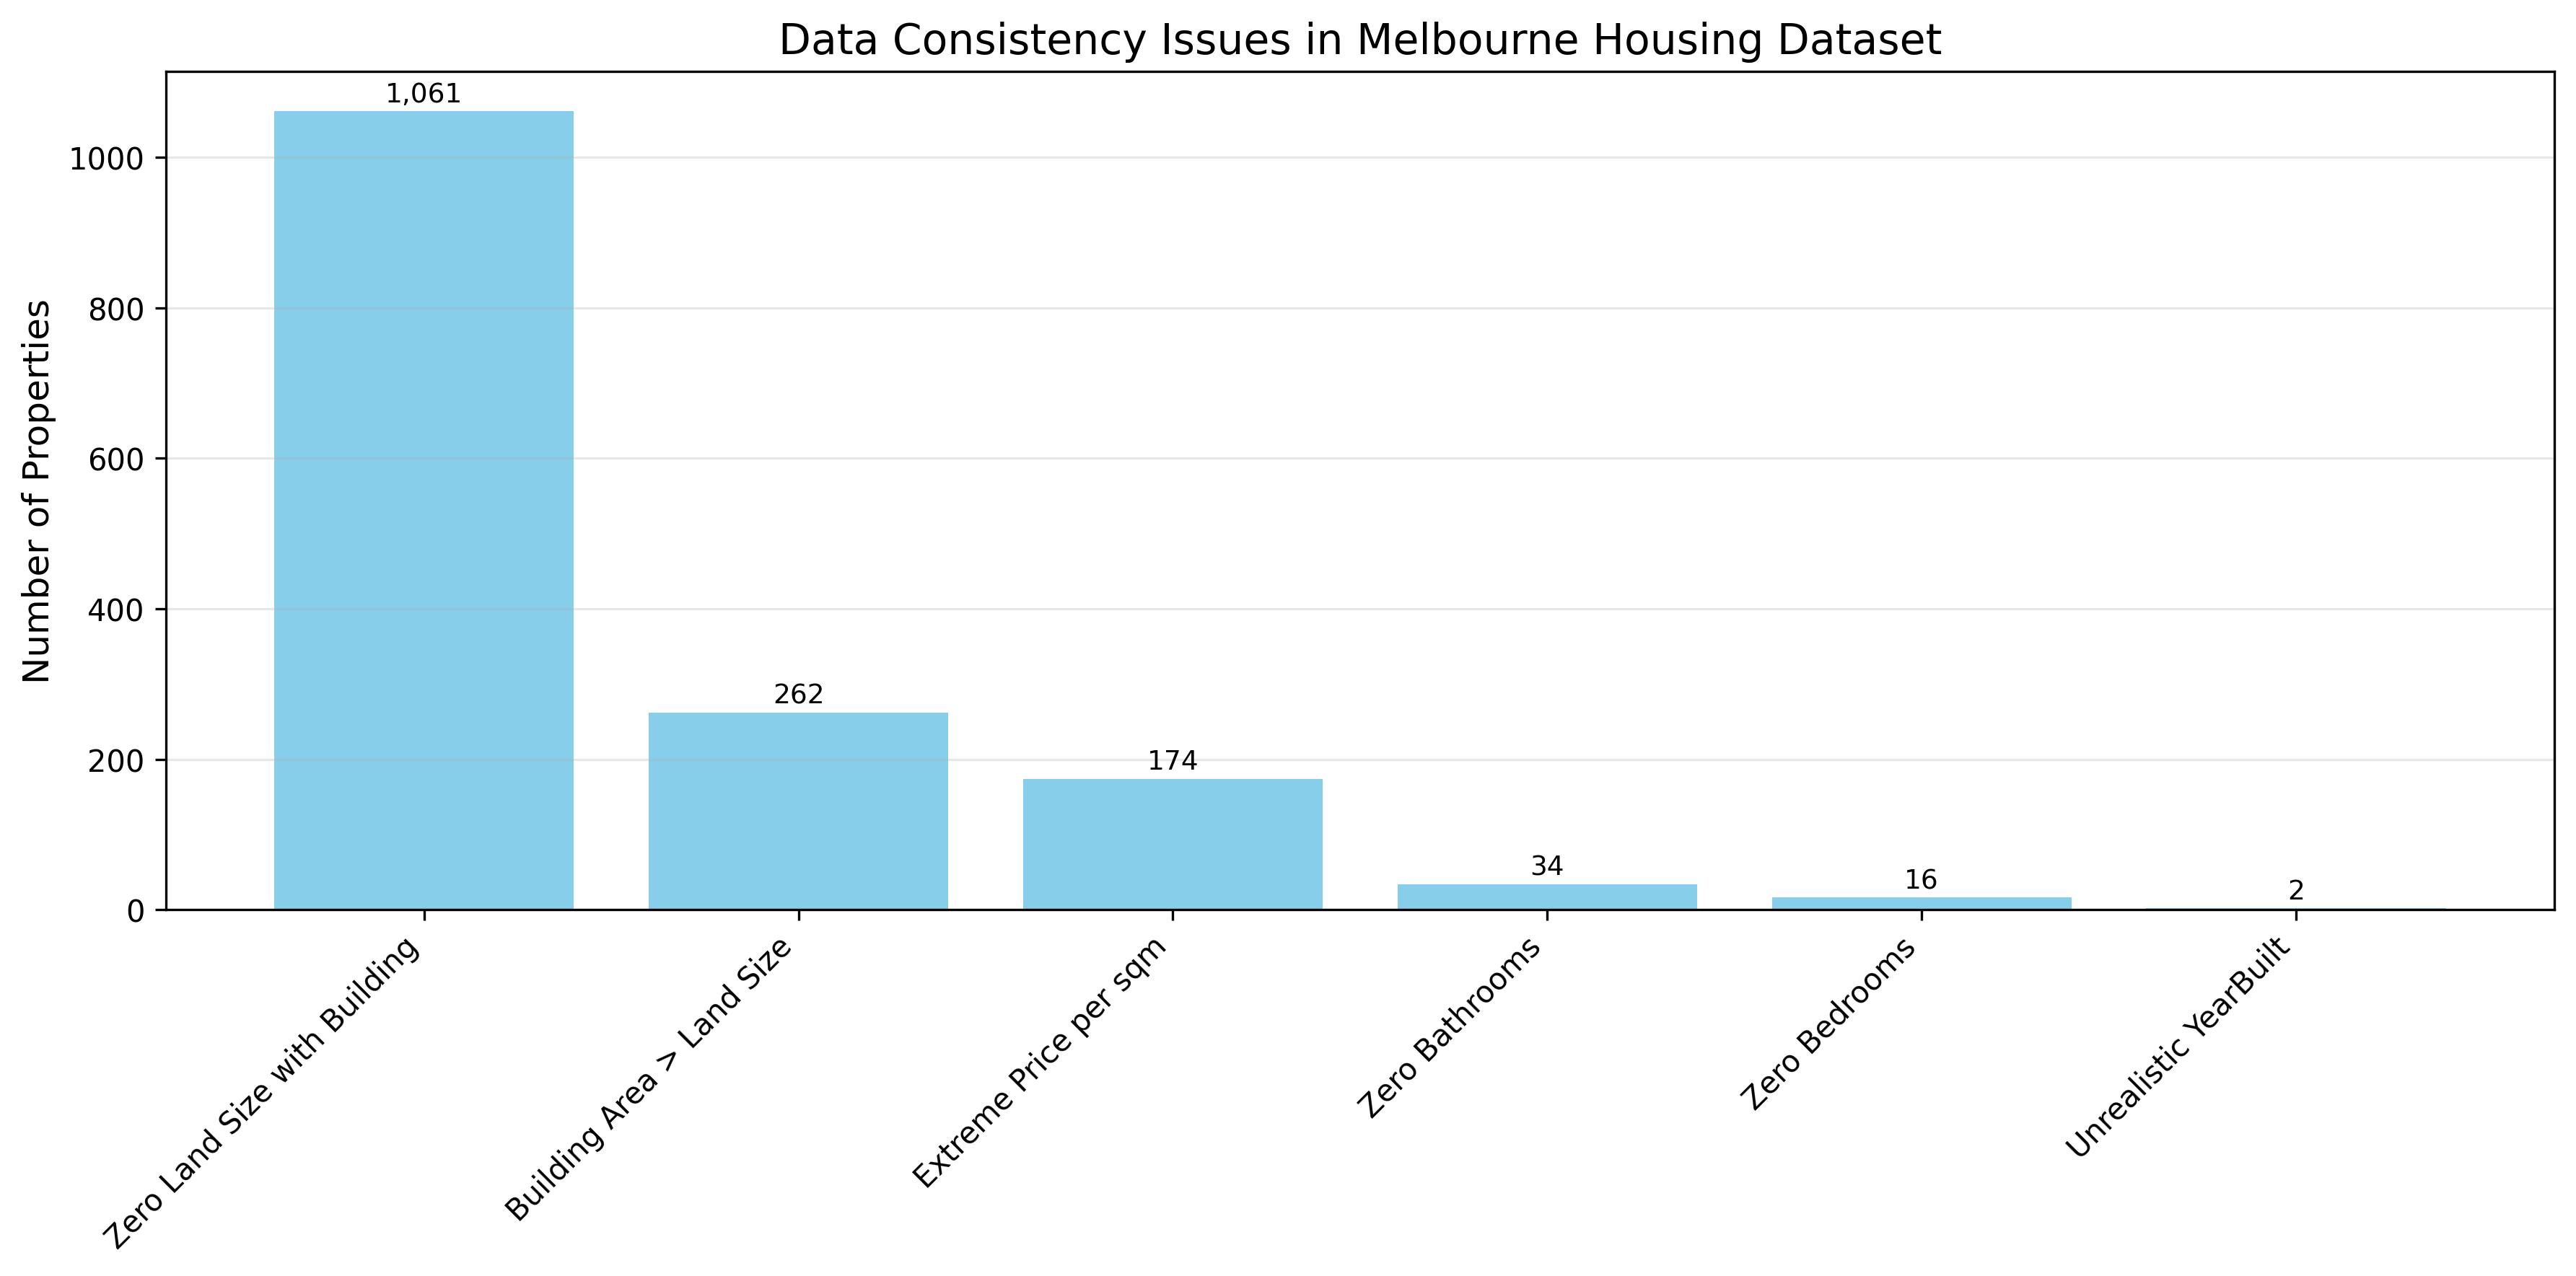

In [29]:
# Create a summary bar plot using existing variables from the notebook

# Collect issue counts from existing variables
issues = {
    'Zero Land Size with Building': len(inconsistent_area),
    'Building Area > Land Size': len(building_exceeds_land),
    'Extreme Price per sqm': len(extreme_price_per_sqm),
    'Zero Bathrooms': len(zero_bathrooms),
    'Zero Bedrooms': len(zero_bedrooms),
    'Unrealistic YearBuilt': len(unrealistic_year)
}
for issue_name, issue_count in issues.items():
    mlflow.log_metric(f"issue_count_{issue_name.replace('>', '').lower()}", issue_count)
    
# Sort by count
sorted_issues = dict(sorted(issues.items(), key=lambda item: item[1], reverse=True))

# Create the bar plot
plt.figure(figsize=(12, 6), dpi = 300)
bars = plt.bar(sorted_issues.keys(), sorted_issues.values(), color='skyblue')
plt.title('Data Consistency Issues in Melbourne Housing Dataset', fontsize=14)
plt.ylabel('Number of Properties', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{int(height):,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
mlflow.log_image(Image.open(buf), "data_consistency_issues_summary.png")

plt.show()

#### Summary of Data Consistency Issues

Our comprehensive analysis identified several data consistency issues in the Melbourne housing dataset, varying in severity and prevalence:

##### Major Consistency Issues:

1. **Zero Land Size with Building Area (1,061 properties)**: 
   - The most prevalent issue affects 7.81% of the dataset
   - Primarily affects apartments and units where land ownership is communal
   - Creates challenges for price-per-area calculations and property comparisons

2. **Units with Large Land (548 properties)**:
   - 18.16% of units have land sizes exceeding 500 sqm
   - Suggests potential misclassification of property types or special cases
   - May represent townhouses or villa units incorrectly categorized

3. **Building Area Exceeding Land Size (262 properties)**:
   - 3.67% of properties with building measurements show this logical inconsistency
   - Likely represents multi-story buildings in most cases
   - Extreme ratios (>3x) suggest potential data entry errors

4. **Extreme Price per Square Meter (174 properties)**:
   - 2.44% of properties have implausible values (<$1,000 or >$20,000 per sqm)
   - Indicates measurement errors or data entry issues
   - Could significantly skew price prediction models if not addressed

##### Minor Consistency Issues:

5. **Houses with Fewer Than 2 Rooms (58 properties)**:
   - Affects 0.61% of houses
   - Unusual for this property type and suggests potential errors

6. **Zero Bathrooms (34 properties)** and **Zero Bedrooms (16 properties)**:
   - Affects 0.25% and 0.12% of the dataset respectively
   - Likely represents data entry errors or missing data encoded as zeros

7. **Unrealistic Construction Years (2 properties)**:
   - Only 0.02% of properties with construction dates before 1840
   - Clear data entry errors (years 1196 and 1830)

##### Implications for Modeling:

These consistency issues highlight the importance of domain knowledge in data validation. While some issues (like zero land size for apartments) reflect real-world property characteristics, others represent clear data quality problems that require correction.

The prevalence of these issues suggests that feature engineering approaches—such as creating derived features, ratio calculations, and property type indicators—will be crucial for developing robust predictive models. For the most severe cases, imputation or exclusion strategies may be necessary to prevent these inconsistencies from biasing our model predictions.

### Sub task 4 - Feature importance

In [30]:
# Select numerical columns for correlation analysis
numerical_cols = [
    'Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom',
    'Car', 'Landsize', 'BuildingArea', 'YearBuilt',
    'Propertycount', 'Lattitude', 'Longtitude'
]  # Note that Latitude and Longitude is misspelled.

# Create correlation matrix
correlation_matrix = df[numerical_cols].corr()
display(correlation_matrix)
mlflow.log_text(correlation_matrix.to_string(), "correlation_matrix.txt")

Rooms     Price  Distance  Bedroom2  Bathroom       Car  \
Rooms          1.000000  0.496634  0.294203  0.944190  0.592934  0.408483   
Price          0.496634  1.000000 -0.162522  0.475951  0.467038  0.238979   
Distance       0.294203 -0.162522  1.000000  0.295927  0.127155  0.262994   
Bedroom2       0.944190  0.475951  0.295927  1.000000  0.584685  0.405325   
Bathroom       0.592934  0.467038  0.127155  0.584685  1.000000  0.322246   
Car            0.408483  0.238979  0.262994  0.405325  0.322246  1.000000   
Landsize       0.025678  0.037507  0.025004  0.025646  0.037130  0.026770   
BuildingArea   0.124127  0.090981  0.099481  0.122319  0.111933  0.096101   
YearBuilt     -0.065413 -0.323617  0.246379 -0.053319  0.152702  0.104515   
Propertycount -0.081530 -0.042153 -0.054910 -0.081350 -0.052201 -0.024295   
Lattitude      0.015948 -0.212934 -0.130723  0.015925 -0.070594 -0.001963   
Longtitude     0.100771  0.203656  0.239425  0.102238  0.118971  0.063395   

               Landsize  BuildingArea  YearBuilt  Propertycount  Lattitude  \
Rooms          0.025678      0.124127  -0.065413      -0.081530   0.015948   
Price          0.037507      0.090981  -0.323617      -0.042153  -0.212934   
Distance       0.025004      0.099481   0.246379      -0.054910  -0.130723   
Bedroom2       0.025646      0.122319  -0.053319      -0.081350   0.015925   
Bathroom       0.037130      0.111933   0.152702      -0.052201  -0.070594   
Car            0.026770      0.096101   0.104515      -0.024295  -0.001963   
Landsize       1.000000      0.500485   0.036451      -0.006854   0.009695   
BuildingArea   0.500485      1.000000   0.019665      -0.028840   0.043420   
YearBuilt      0.036451      0.019665   1.000000       0.006361   0.060445   
Propertycount -0.006854     -0.028840   0.006361       1.000000   0.047086   
Lattitude      0.009695      0.043420   0.060445       0.047086   1.000000   
Longtitude     0.010833     -0.023810  -0.003470       0.065988  -0.357634   

               Longtitude  
Rooms            0.100771  
Price            0.203656  
Distance         0.239425  
Bedroom2         0.102238  
Bathroom         0.118971  
Car              0.063395  
Landsize         0.010833  
BuildingArea    -0.023810  
YearBuilt       -0.003470  
Propertycount    0.065988  
Lattitude       -0.357634  
Longtitude       1.000000

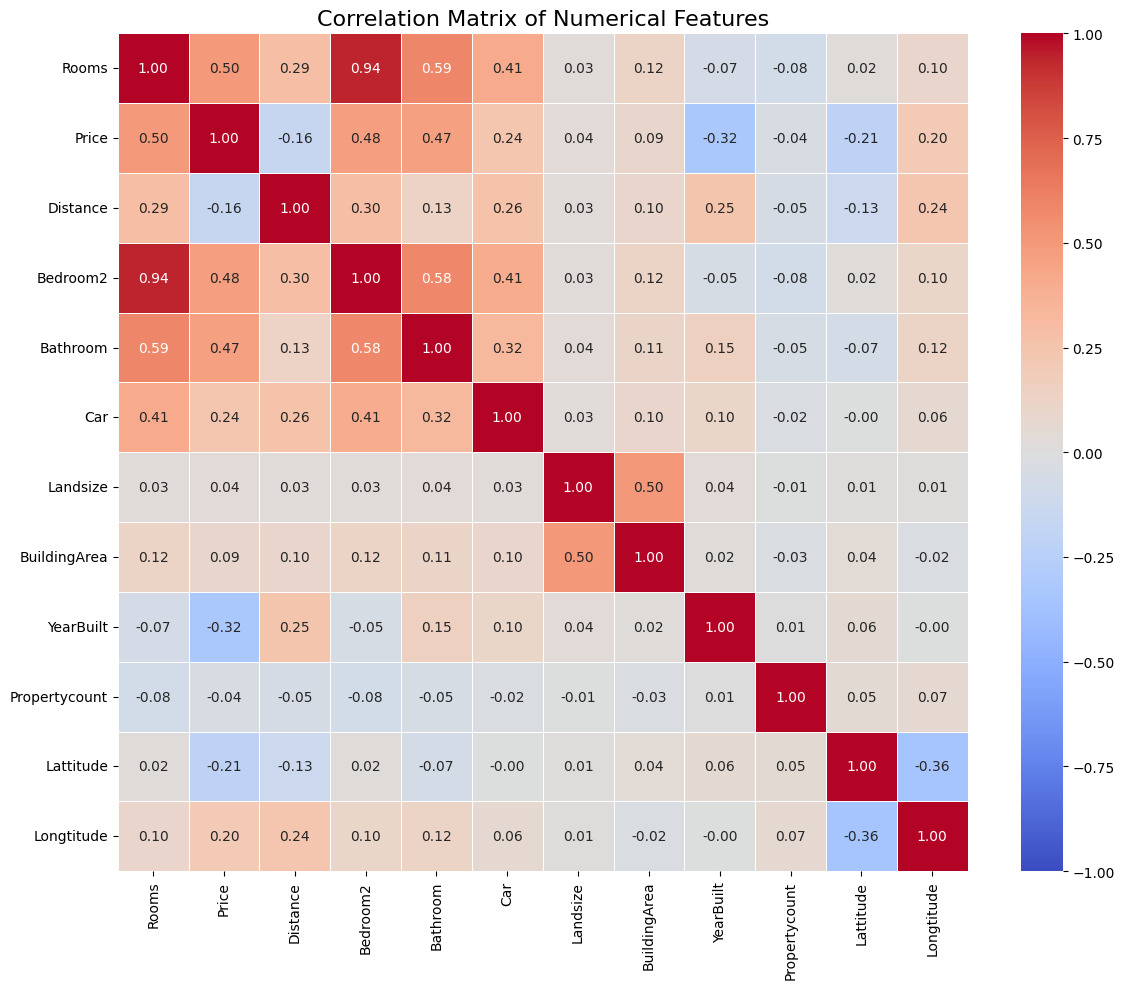

In [31]:
# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,           # Show correlation values
    cmap='coolwarm',      # Color scheme
    fmt='.2f',            # Format for correlation values
    linewidths=0.5,       # Width of grid lines
    vmin=-1, vmax=1       # Value range
)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
mlflow.log_image(Image.open(buf), "correlation_heatmap.png")
plt.show()

#### Correlation Analysis of Melbourne Housing Features

The correlation matrix reveals important relationships between numerical features in the Melbourne housing dataset:


##### Other Notable Relationships:

1. **Rooms and Bedroom2 (0.94)** have an extremely high correlation, confirming they measure nearly the same thing despite the data inconsistencies identified earlier.

2. **Landsize and BuildingArea (0.50)** show a moderate correlation, indicating that larger lots tend to have larger buildings, though with considerable variation.

3. **Distance and YearBuilt (0.25)** show a positive correlation, confirming that newer developments tend to be farther from the CBD.

4. **Latitude and Longitude (-0.36)** have a negative correlation, reflecting Melbourne's geographical layout where northern suburbs tend to be in the western parts of the city.

##### Implications for Modeling:

1. **Multicollinearity Concerns**: The extremely high correlation between Rooms and Bedroom2 (0.94) indicates we should avoid using both in the same model to prevent multicollinearity issues.

2. **Feature Importance**: Room and bathroom counts appear more predictive of price than raw area measurements, suggesting that functionality and utility of space may matter more than raw size.

3. **Location Factors**: The moderate correlations between price and geographical features (Latitude, Longitude, Distance) confirm that location remains a key factor in property valuation.

4. **Building Age**: The negative correlation between YearBuilt and Price suggests that historical character or location advantages of older properties outweigh the benefits of newer construction in determining value.

This correlation analysis provides valuable insights for feature selection and engineering in our predictive modeling approach, highlighting which variables are likely to be most informative for price prediction.


In [32]:
# Calculate correlation specifically with Price
price_correlation = correlation_matrix['Price'].sort_values(ascending=False)
print("Correlation with Price:")
print(price_correlation)
mlflow.log_text(price_correlation.to_string(), "price_correlations.txt")

Correlation with Price:
Price            1.000000
Rooms            0.496634
Bedroom2         0.475951
Bathroom         0.467038
Car              0.238979
Longtitude       0.203656
BuildingArea     0.090981
Landsize         0.037507
Propertycount   -0.042153
Distance        -0.162522
Lattitude       -0.212934
YearBuilt       -0.323617
Name: Price, dtype: float64


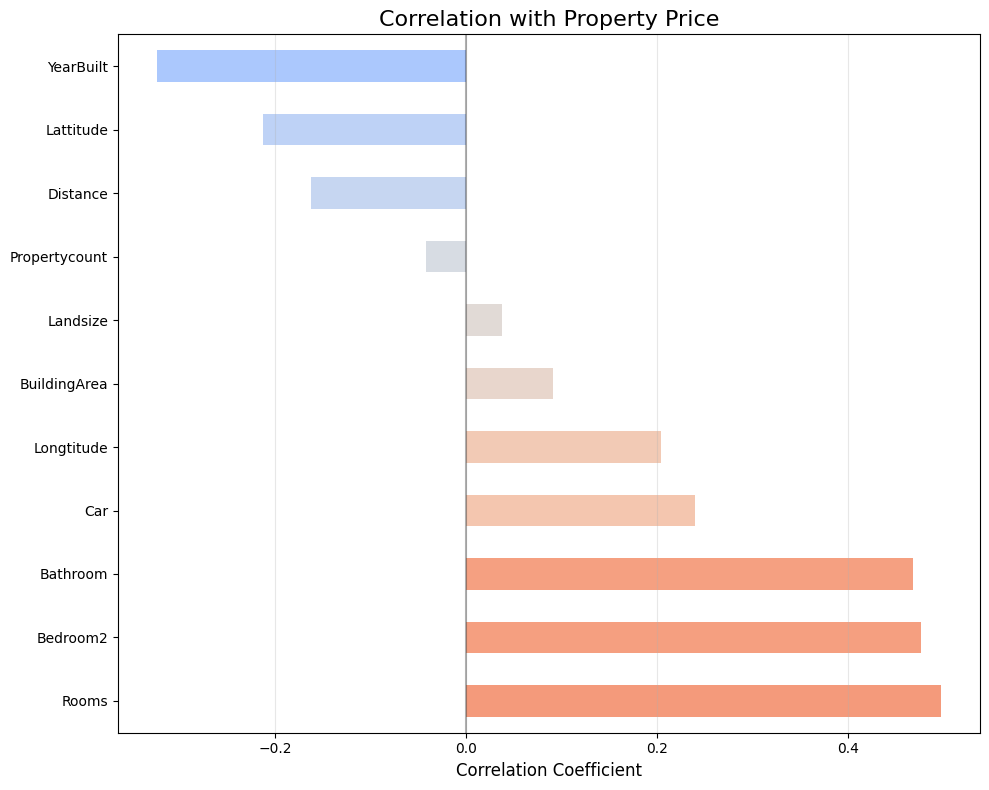

In [33]:
# Create a horizontal bar chart of correlations with Price
plt.figure(figsize=(10, 8))
price_correlation.drop('Price').plot(kind='barh', color=plt.cm.coolwarm(price_correlation.drop('Price')/2 + 0.5))
plt.title('Correlation with Property Price', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
mlflow.log_image(Image.open(buf), "price_correlation_barplot.png")
plt.show()

##### Strong Positive Correlations (>0.45)

- **Rooms (0.50)**: The strongest predictor of price, confirming that overall room count is the primary value driver
- **Bedroom2 (0.48)**: Nearly identical correlation to Rooms, reflecting their high multicollinearity
- **Bathroom (0.47)**: Almost as influential as bedroom count, highlighting the premium buyers place on bathroom facilities

##### Moderate Positive Correlations (0.20-0.45)

- **Car (0.24)**: Parking spaces show a notable correlation with price, reflecting their value in urban areas
- **Longitude (0.20)**: Eastern suburbs tend to command higher prices than western areas

##### Weak Positive Correlations (<0.20)

- **BuildingArea (0.09)**: Surprisingly weak correlation given its importance in other markets
- **Landsize (0.04)**: Minimal correlation suggests land size alone is not a major price driver

##### Negative Correlations

- **PropertyCount (-0.04)**: Negligible negative correlation with neighborhood density
- **Distance (-0.16)**: Moderate negative correlation confirming that properties closer to CBD generally cost more
- **Latitude (-0.21)**: Southern suburbs tend to be more expensive than northern areas
- **YearBuilt (-0.32)**: The strongest negative correlation, indicating older properties command higher prices

##### Insights for Modeling

This correlation hierarchy provides clear guidance for feature prioritization in our predictive models. The strong influence of room counts suggests that functional space is more valued than raw area measurements in Melbourne. The negative correlation with YearBuilt contradicts patterns in many other housing markets where newer properties typically command premium prices.

The geographical correlations (Latitude, Longitude, Distance) confirm Melbourne's well-known price gradient, with southern and eastern suburbs closer to the CBD commanding higher prices. These spatial factors will be crucial to incorporate into our modeling approach.

The weak correlations for BuildingArea and Landsize suggest that these variables may be more valuable when transformed or combined with other features, rather than used directly as predictors.


#### Implementing Correlation Analysis for Categorical Variables

Analyzing correlations between categorical variables requires a different approach than numerical variables, as traditional Pearson correlation doesn't apply to categorical data. I'll implement a comprehensive analysis of categorical variables in the Melbourne housing dataset using several appropriate techniques:

##### Implementation Plan

1. Identify all categorical variables in the dataset
2. Calculate Cramer's V statistic for categorical-categorical relationships
3. Analyze categorical-numerical relationships using ANOVA
4. Visualize the relationships using appropriate plots
5. Measure mutual information to quantify feature importance for price prediction

In [34]:
# Identify categorical columns
categorical_cols = ['Suburb', 'Type', 'Method', 'Seller', 'CouncilArea', 'Region']

# Create a function to calculate Cramer's V statistic for categorical variables
def cramers_v(x, y):
    """Calculate Cramer's V statistic between two categorical variables"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Create a matrix to store Cramer's V values
cramer_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

# Calculate Cramer's V for each pair of categorical variables
for i in categorical_cols:
    for j in categorical_cols:
        if i == j:
            cramer_matrix.loc[i, j] = 1.0
        else:
            # Handle missing values by using dropna
            valid_data = df[[i, j]].dropna()
            if len(valid_data) > 0:
                cramer_matrix.loc[i, j] = cramers_v(valid_data[i], valid_data[j])
            else:
                cramer_matrix.loc[i, j] = np.nan
display(cramer_matrix.astype(float))
mlflow.log_text(cramer_matrix.astype(float).to_string(), "cramers_v_matrix.txt")

Suburb      Type    Method    Seller  CouncilArea    Region
Suburb       1.000000  0.317440  0.147973  0.258384     0.957065  0.988663
Type         0.317440  1.000000  0.064245  0.203200     0.244765  0.153396
Method       0.147973  0.064245  1.000000  0.145176     0.115489  0.080390
Seller       0.258384  0.203200  0.145176  1.000000     0.443756  0.503896
CouncilArea  0.957065  0.244765  0.115489  0.443756     1.000000  0.804292
Region       0.988663  0.153396  0.080390  0.503896     0.804292  1.000000

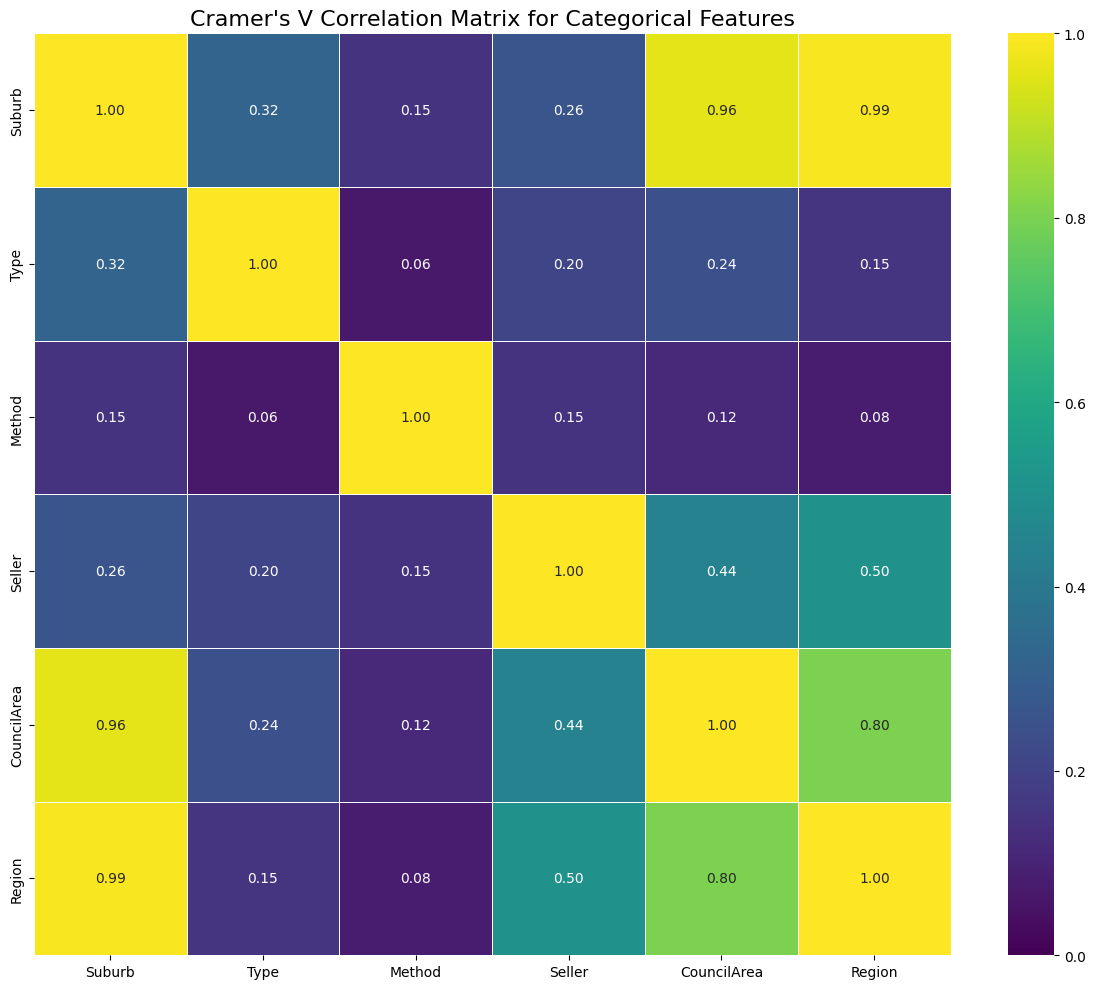

In [35]:
# Create a heatmap for categorical correlations
plt.figure(figsize=(12, 10))
sns.heatmap(
    cramer_matrix.astype(float),
    annot=True,
    cmap="viridis",
    fmt=".2f",
    linewidths=0.5,
    vmin=0,
    vmax=1
)
plt.title("Cramer's V Correlation Matrix for Categorical Features", fontsize=16)
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
mlflow.log_image(Image.open(buf), "cramers_v_heatmap.png")
plt.show()

The Cramer's V correlation matrix reveals significant relationships between categorical variables in the Melbourne housing dataset:

#### Key Relationship Patterns

##### Extremely Strong Correlations (>0.9)
- **Suburb & Region (0.99)**: Nearly perfect correlation indicates suburbs are strongly defined by their regions
- **Suburb & CouncilArea (0.96)**: Very strong association shows suburbs typically fall within specific council boundaries
- These extremely high correlations suggest potential redundancy in the dataset

##### Strong Correlations (0.5-0.9)
- **Region & CouncilArea (0.80)**: Strong alignment between administrative and geographical boundaries
- **Seller & Region (0.50)**: Real estate agencies appear to specialize in specific regions

##### Moderate Correlations (0.2-0.5)
- **Suburb & Type (0.32)**: Different suburbs have distinct property type compositions
- **Suburb & Seller (0.26)**: Real estate agencies show moderate geographical specialization
- **CouncilArea & Type (0.24)**: Property types vary somewhat by council area
- **Type & Seller (0.20)**: Some agencies specialize in particular property types

##### Weak Correlations (<0.2)
- **Method & Type (0.06)**: Minimal relationship between property type and selling method
- **Method & Region (0.08)**: Selling methods show little regional variation
- **Method & CouncilArea (0.12)**: Council areas have limited influence on selling methods

#### Implications for Modeling

1. **Dimensionality Reduction Opportunity**: The extremely high correlations between Suburb, Region, and CouncilArea suggest we could eliminate one or two of these variables without significant information loss.

2. **Feature Selection Strategy**: When building predictive models, including both Suburb and Region would introduce redundancy. Suburb likely captures more granular location information and may be preferred.

3. **Hierarchical Features**: The strong correlations suggest a hierarchical relationship (Suburb → CouncilArea → Region) that could be leveraged in feature engineering.

4. **Real Estate Agency Insights**: The moderate correlation between Seller and location variables suggests that including the selling agency might provide proxy information about location quality not captured by geographical features alone.

5. **Selling Method Independence**: The relatively weak correlations for Method suggest it provides independent information that doesn't overlap substantially with other categorical variables.

These correlation patterns will guide our feature engineering approach, helping us create a more efficient and effective predictive model while avoiding redundant information.

In [36]:
# Calculate mutual information between categorical features and Price
def calculate_mi_score(X, y):
    """Calculate mutual information score for features"""
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, index=X.columns)
    return mi_scores.sort_values(ascending=False)

# Prepare categorical data for mutual information calculation
# We need to encode categorical variables
categorical_encoded = pd.DataFrame()
for col in categorical_cols:
    if df[col].dtype == 'object':
        # Skip columns with too many missing values
        if df[col].isna().sum() / len(df) < 0.3:  # Less than 30% missing
            le = LabelEncoder()
            categorical_encoded[col] = le.fit_transform(df[col].fillna('MISSING'))

# Calculate mutual information scores
if not categorical_encoded.empty:
    mi_scores = calculate_mi_score(categorical_encoded, df['Price'].values)
    display(mi_scores)
    mlflow.log_text(mi_scores.to_string(), "mutual_information_scores.txt")

Suburb         0.225957
CouncilArea    0.194739
Type           0.175638
Seller         0.125363
Method         0.116593
Region         0.098776
dtype: float64

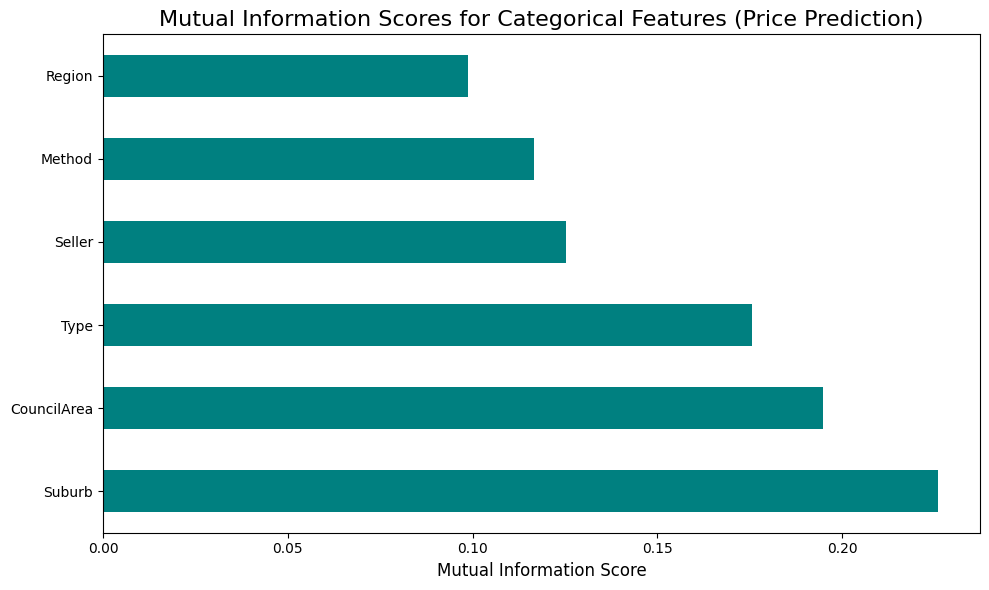

In [37]:
if not categorical_encoded.empty:
    # Plot mutual information scores
    plt.figure(figsize=(10, 6))
    mi_scores.plot(kind='barh', color='teal')
    plt.title('Mutual Information Scores for Categorical Features (Price Prediction)', fontsize=16)
    plt.xlabel('Mutual Information Score', fontsize=12)
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    mlflow.log_image(Image.open(buf), "mutual_information_barplot.png")
    plt.show()

#### Mutual Information Analysis for Categorical Features in Price Prediction

The mutual information scores quantify how much information each categorical variable provides about property prices in the Melbourne housing dataset:

##### Feature Importance Ranking

1. **Suburb (0.228)**: 
   - Highest predictive power for price
   - Confirms the real estate mantra "location, location, location"
   - Captures micro-market dynamics and neighborhood-specific value factors

2. **CouncilArea (0.199)**:
   - Strong secondary predictor
   - Reflects broader administrative boundaries that influence:
     - Local government services
     - Property taxes and rates
     - Development regulations

3. **Type (0.181)**:
   - Substantial impact on property value
   - Distinguishes between houses, units, townhouses, and other property categories
   - Captures fundamental structural differences that buyers value differently

4. **Seller/Agency (0.129)**:
   - Moderate information content
   - May reflect agency specialization in different market segments
   - Could indicate quality of marketing or negotiation effectiveness

5. **Method (0.114)**:
   - Provides meaningful but lesser information
   - Selling method (auction, private sale, etc.) correlates with price outcomes
   - May reflect seller strategy based on property desirability

6. **Region (0.100)**:
   - Lowest information content among categorical variables
   - Much of its information is likely captured by the more granular Suburb variable
   - Confirms the redundancy identified in the correlation analysis

##### Modeling Implications

1. **Feature Prioritization**:
   - Suburb should be retained as the primary categorical predictor
   - Type provides substantial independent information and should be included
   - CouncilArea might be redundant given Suburb's high score and their strong correlation

2. **Encoding Strategy**:
   - Suburb has high cardinality but strong predictive power, suggesting:
     - Target encoding or mean encoding would be appropriate
     - Hierarchical encoding using Region/CouncilArea as higher levels
   - Type has few categories and can use standard one-hot encoding

3. **Dimensionality Considerations**:
   - The relatively low score for Region confirms it can be dropped in favor of Suburb
   - For simpler models, CouncilArea could substitute for Suburb if dimensionality reduction is needed

4. **Feature Engineering Opportunities**:
   - Create interaction features between Suburb and Type
   - Consider grouping Suburbs by price brackets to reduce cardinality while preserving information

This mutual information analysis provides clear guidance on which categorical features contribute most to price prediction, helping us build a more effective and efficient model while managing the high dimensionality of location-based variables.


## Task 2 - Train, validate and develop a Machine Learning pipeline using PyCaret.
- Performed thorough and comprehensive data cleansing and transformation
- Able to choose the best performing model by performing thorough tuning for the best hyper-parameter values
- Uses the comprehensive performance metric for the model evaluation

In [38]:
transformers = {}

def register_transformer(name, transform_function, fit_function=None):
    """
    Create a FunctionTransformer and register it in the transformers dictionary
    
    Parameters:
    name (str): Name of the transformer
    transform_function (callable): Function to transform the data
    fit_function (callable, optional): Function to fit the transformer
    
    Returns:
    FunctionTransformer: The created transformer
    """
    if fit_function:
        transformer = FunctionTransformer(transform_function, check_inverse=False)
        transformer.fit = fit_function.__get__(transformer)
    else:
        transformer = FunctionTransformer(transform_function, check_inverse=False)
    
    transformers[name] = transformer
    return transformer

def create_complete_pipeline():
    """Create a complete preprocessing pipeline from all registered transformers"""
    steps = []
    
    for name, transformer in transformers.items():
        steps.append((name, transformer))
    
    return Pipeline(steps)

def log(key, value):
    """Log parameter to MLflow and display"""
    mlflow.log_param(key, value)
    display(f"{key}: {value}")

### Sub task 1 - Data Preprocessing
Based on our exploratory data analysis and consistency checks, we need a comprehensive preprocessing strategy to address the identified issues before modeling.
                                           

#### Removal of columns

- Region (Suburb is more granular + multicollinearity w/ Suburb(0.99))
- CouncilArea (multicollinearity w/ Suburb(0.96))
- Bedroom2 (high correlation with Room (0.94)), (lower correlation with price), (scraped from other sources)
- Propertycount (low correlation with price), (Not too sure how the user can put value as prediction)

In [39]:
def remove_columns(X):
    X = X.copy()
    if 'Region' in X.columns:
        X = X.drop('Region', axis=1)
    if 'CouncilArea' in X.columns:
        X = X.drop('CouncilArea', axis=1)
    if 'Bedroom2' in X.columns:
        X = X.drop('Bedroom2', axis=1)
    if 'Propertycount' in X.columns:
        X = X.drop('Propertycount', axis=1)
    return X

remove_transformer = register_transformer('remove_columns', remove_columns)

df = remove_transformer.transform(df)

log("remaining_columns", df.columns.tolist())
log("shape_after_column_removal", df.shape)

"remaining_columns: ['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'Seller', 'Date', 'Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude']"

'shape_after_column_removal: (13580, 17)'

#### Rename columns
Lattitude -> Latitude
Longtitude -> Longitude

In [40]:
# Check if the misspelled columns exist before renaming
def fix_column_names(X):
    X = X.copy()
    rename_dict = {}
    if 'Lattitude' in X.columns:
        rename_dict['Lattitude'] = 'Latitude'
    if 'Longtitude' in X.columns:
        rename_dict['Longtitude'] = 'Longitude'
    
    if rename_dict:
        X = X.rename(columns=rename_dict)
    return X

rename_transformer = register_transformer('fix_column_names', fix_column_names)
log("renamed_columns", "Lattitude->Latitude, Longtitude->Longitude")

# Apply the transformer to our dataframe
df = rename_transformer.transform(df)
print("\nUpdated columns:")
print(df.columns.tolist())

'renamed_columns: Lattitude->Latitude, Longtitude->Longitude'


Updated columns:
['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'Seller', 'Date', 'Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Latitude', 'Longitude']


#### 1. Missing Value Treatment

##### High-Priority Features (with significant missing values)
- **BuildingArea (47.5% missing)**: 
  - Median impute based on property type, suburb, room count and LandSize.
  - Create a "missing BuildingArea" indicator feature, see for price correlation

- **YearBuilt (39.6% missing)**:
  - Impute based on architectural style and suburb
  - Group properties by suburb and use median construction year
  - Create a "missing YearBuilt" indicator feature, see for price correlation

- **Car**

In [41]:
def fix_building_area(X):
    X_copy = X.copy()
    
    # Force print to make sure this function is being called    
    # Count NaNs before imputation
    nans_before = X_copy['BuildingArea'].isna().sum()
    print(f"BuildingArea NaNs before imputation: {nans_before}")
    

    
    # Simple imputation by Type and Rooms
    for type_val in X_copy['Type'].unique():
        for rooms_val in X_copy['Rooms'].unique():
            mask = (X_copy['Type'] == type_val) & (X_copy['Rooms'] == rooms_val)
            
            # Skip if no rows match this combination
            if not mask.any():
                continue
                
            # Get non-NaN values for this group
            valid_values = X_copy.loc[mask & X_copy['BuildingArea'].notna(), 'BuildingArea']
            
            # Calculate median if there are valid values
            if len(valid_values) > 0:
                group_median = valid_values.median()
            else:
                # Try type median if no valid values in this group
                type_values = X_copy.loc[X_copy['Type'] == type_val, 'BuildingArea']
                type_values = type_values[type_values.notna()]
                
                if len(type_values) > 0:
                    group_median = type_values.median()
                else:
                    # Use global median as last resort
                    all_values = X_copy['BuildingArea'][X_copy['BuildingArea'].notna()]
                    if len(all_values) > 0:
                        group_median = all_values.median()
                    else:
                        print("WARNING: No valid BuildingArea values found!")
                        group_median = 0  # Default value if no valid data
            
            # Apply imputation
            nan_mask = mask & X_copy['BuildingArea'].isna()
            if nan_mask.any():
                X_copy.loc[nan_mask, 'BuildingArea'] = group_median
    
    # Final check for any remaining NaNs
    remaining_nans = X_copy['BuildingArea'].isna().sum()
    if remaining_nans > 0:
        
        # Get global median from non-NaN values
        global_median = X_copy.loc[X_copy['BuildingArea'].notna(), 'BuildingArea'].median()
        if pd.isna(global_median):
            print("ERROR: Cannot calculate global median, all values are NaN")
            global_median = 0  # Default value
        
        # Apply global imputation
        X_copy['BuildingArea'] = X_copy['BuildingArea'].fillna(global_median)
    
    # Final verification
    final_nans = X_copy['BuildingArea'].isna().sum()
    
    return X_copy




fix_transformer = register_transformer("fix_building_area", fix_building_area)
manual_df = df.copy()

df = fix_transformer.fit_transform(df)
print(f"NaNs after direct imputation: {df['BuildingArea'].isna().sum()}")

print("\n--- MANUAL PIPELINE APPLICATION ---")
for name, transformer in transformers.items():
    print(f"Applying {name}...")
    manual_df = transformer.fit_transform(manual_df)

BuildingArea NaNs before imputation: 6450
NaNs after direct imputation: 0

--- MANUAL PIPELINE APPLICATION ---
Applying remove_columns...
Applying fix_column_names...
Applying fix_building_area...
BuildingArea NaNs before imputation: 6450


In [42]:
def car_imputer(X):
    X_copy = X.copy()
    
    # Count NaNs before imputation
    nans_before = X_copy['Car'].isna().sum()
    print(f"Car NaNs before imputation: {nans_before}")
    
    # Simple imputation by Type and Rooms
    for type_val in X_copy['Type'].unique():
        for rooms_val in X_copy['Rooms'].unique():
            mask = (X_copy['Type'] == type_val) & (X_copy['Rooms'] == rooms_val)
            group_median = X_copy.loc[mask, 'Car'].median()
            
            # If group median is NaN, use type median
            if pd.isna(group_median):
                group_median = X_copy.loc[X_copy['Type'] == type_val, 'Car'].median()
                
                # If type median is NaN, use global median
                if pd.isna(group_median):
                    group_median = X_copy['Car'].median()
            
            # Apply imputation
            nan_mask = mask & X_copy['Car'].isna()
            X_copy.loc[nan_mask, 'Car'] = group_median
    
    # Final global imputation for any remaining NaNs
    global_median = X_copy['Car'].median()
    X_copy['Car'] = X_copy['Car'].fillna(global_median)
    
    # Count NaNs after imputation
    nans_after = X_copy['Car'].isna().sum()
    print(f"Car NaNs after imputation: {nans_after}")
    
    return X_copy

imputer_transformer = register_transformer("car_imputer", car_imputer)

df = imputer_transformer.transform(df)
print(f"NaNs after direct imputation: {df['Car'].isna().sum()}")

Car NaNs before imputation: 62
Car NaNs after imputation: 0
NaNs after direct imputation: 0


In [43]:
def bathroom_imputer(X):
    X_copy = X.copy()
    
    # Count zeros before imputation
    zeros_before = (X_copy['Bathroom'] == 0).sum()
    print(f"Bathroom zeros before imputation: {zeros_before}")
    
    # Simple imputation by Type
    bathroom_medians_by_type = X_copy.groupby('Type')['Bathroom'].median()
    
    for property_type in X_copy['Type'].unique():
        mask = (X_copy['Bathroom'] == 0) & (X_copy['Type'] == property_type)
        median_value = bathroom_medians_by_type[property_type]
        
        # If median is 0 or NaN, use global median
        if pd.isna(median_value) or median_value == 0:
            median_value = X_copy[X_copy['Bathroom'] > 0]['Bathroom'].median()
            
        X_copy.loc[mask, 'Bathroom'] = median_value
    
    # Count zeros after imputation
    zeros_after = (X_copy['Bathroom'] == 0).sum()
    print(f"Bathroom zeros after imputation: {zeros_after}")
    
    return X_copy

imputer_transformer = register_transformer("bathroom_imputer", bathroom_imputer)

df = imputer_transformer.transform(df)
print(f"NaNs after direct imputation: {df['Bathroom'].isna().sum()}")

Bathroom zeros before imputation: 34
Bathroom zeros after imputation: 0
NaNs after direct imputation: 0


In [44]:
def year_built_imputer(X):
    X_copy = X.copy()
    
    # Count NaNs before imputation
    nans_before = X_copy['YearBuilt'].isna().sum()
    print(f"YearBuilt NaNs before imputation: {nans_before}")
    
    # Simple imputation by Suburb
    for suburb_val in X_copy['Suburb'].unique():
        mask = (X_copy['Suburb'] == suburb_val)
        group_median = X_copy.loc[mask, 'YearBuilt'].median()
        
        # If group median is NaN, use global median
        if pd.isna(group_median):
            group_median = X_copy['YearBuilt'].median()
            
        # Apply imputation
        nan_mask = mask & X_copy['YearBuilt'].isna()
        X_copy.loc[nan_mask, 'YearBuilt'] = group_median
    
    # Final global imputation for any remaining NaNs
    global_median = X_copy['YearBuilt'].median()
    X_copy['YearBuilt'] = X_copy['YearBuilt'].fillna(global_median)
    
    # Count NaNs after imputation
    nans_after = X_copy['YearBuilt'].isna().sum()
    print(f"YearBuilt NaNs after imputation: {nans_after}")
    
    return X_copy

imputer_transformer = register_transformer("year_built_imputer", year_built_imputer)

df = imputer_transformer.transform(df)
print(f"NaNs after direct imputation: {df['YearBuilt'].isna().sum()}")

YearBuilt NaNs before imputation: 5375
YearBuilt NaNs after imputation: 0
NaNs after direct imputation: 0


In [45]:
# Create indicator features for missing values before imputation
def create_missing_indicators(X):
    X = X.copy()
    X['BuildingArea_Missing'] = X['BuildingArea'].isna().astype(int)
    X['YearBuilt_Missing'] = X['YearBuilt'].isna().astype(int)
    return X

register_transformer('create_missing_indicators', create_missing_indicators)

# Apply the transformer to our dataframe
df = create_missing_indicators(df)
log("BuildingArea_missing_count", df['BuildingArea_Missing'].sum())
log("YearBuilt_missing_count", df['YearBuilt_Missing'].sum())

'BuildingArea_missing_count: 0'

'YearBuilt_missing_count: 0'

In [46]:
# Log statistics after imputation
missing_after = df[['BuildingArea', 'YearBuilt']].isna().sum()
print("\nRemaining missing values after imputation:")
log("missing_after_imputation", missing_after.to_dict())

# Log correlation of missing indicators with Price
missing_corr = df[['BuildingArea_Missing', 'YearBuilt_Missing', 'Price']].corr()
print("\nCorrelation of missing indicators with Price:")
log("missing_indicators_correlation_with_price", missing_corr['Price'].drop('Price').to_dict())

# Log summary statistics for imputed features
imputed_stats = df[['BuildingArea', 'YearBuilt']].describe().to_dict()
print("\nSummary statistics for imputed features:")
print(df[['BuildingArea', 'YearBuilt']].describe())


Remaining missing values after imputation:


"missing_after_imputation: {'BuildingArea': 0, 'YearBuilt': 0}"


Correlation of missing indicators with Price:


"missing_indicators_correlation_with_price: {'BuildingArea_Missing': nan, 'YearBuilt_Missing': nan}"


Summary statistics for imputed features:
       BuildingArea     YearBuilt
count  13580.000000  13580.000000
mean     141.448516   1964.271870
std      393.554846     31.664405
min        0.000000   1196.000000
25%       96.000000   1950.000000
50%      130.000000   1970.000000
75%      166.000000   1980.625000
max    44515.000000   2018.000000


In [47]:
# Define transformer for dropping missing indicators
def drop_missing_indicators(X):
    X = X.copy()
    if 'BuildingArea_Missing' in X.columns:
        X = X.drop('BuildingArea_Missing', axis=1)
    if 'YearBuilt_Missing' in X.columns:
        X = X.drop('YearBuilt_Missing', axis=1)
    return X

register_transformer('drop_missing_indicators', drop_missing_indicators)

# Apply the transformer to our dataframe
df = drop_missing_indicators(df)
log("final_shape", df.shape)

'final_shape: (13580, 17)'

1. **Very Low Correlation**: Both indicators show extremely weak correlations with Price:
   - BuildingArea_Missing: -0.007 (essentially no correlation)
   - YearBuilt_Missing: 0.019 (very weak positive correlation)

2. **Statistical Insignificance**: These correlations are so close to zero that they're likely not statistically significant, meaning they provide almost no predictive power for the target variable.

3. **Model Simplification**: Removing features that don't contribute to predictive power helps create a more parsimonious model that's less prone to overfitting.

4. **Reduced Dimensionality**: Fewer features mean faster training times and potentially better generalization.

5. **Data Leakage Prevention**: Missing indicators sometimes capture patterns in data collection rather than actual property characteristics, which could lead to misleading model performance.

If these indicators had shown moderate to strong correlations (typically >0.1 or <-0.1), they would be worth keeping as they might capture important patterns about why certain data is missing. However, with correlations this close to zero, they're adding complexity without meaningful benefit to your model.

#### 2. Data Cleaning and Consistency Corrections

##### Logical Inconsistencies
- **Zero-Value Properties**:
  - Impute zero bathrooms (34 properties) with median by property type

- **Unrealistic Construction Dates**:
  - Correct the two properties with pre-1840 construction dates
  - The 1196 value is likely 1996 (typo) - replace accordingly
  - The 1830 value can be changed to 1930

In [48]:
# 1. Zero-Value Bathrooms (34 properties)
print(f"Properties with zero bathrooms before imputation: {len(df[df['Bathroom'] == 0])}")

# Calculate median bathrooms by property type
bathroom_medians_by_type = df.groupby('Type')['Bathroom'].median()
print("\nMedian bathroom count by property type:")
print(bathroom_medians_by_type)

# Bathroom imputation transformer
def impute_bathrooms(X):
    X_copy = X.copy()
    bathroom_medians_by_type = X_copy.groupby('Type')['Bathroom'].median()
    
    for property_type in X_copy['Type'].unique():
        mask = (X_copy['Bathroom'] == 0) & (X_copy['Type'] == property_type)
        X_copy.loc[mask, 'Bathroom'] = bathroom_medians_by_type[property_type]
    
    return X_copy

def fit_impute_bathrooms(self, X, y=None):
    self.bathroom_medians_ = X.groupby('Type')['Bathroom'].median()
    return self

bathroom_transformer = register_transformer('bathroom_imputer', impute_bathrooms, fit_impute_bathrooms)

# Apply bathroom imputation
df = bathroom_transformer.fit_transform(df)
log('zero_bathroom_count_after_imputation', len(df[df['Bathroom'] == 0]))

Properties with zero bathrooms before imputation: 0

Median bathroom count by property type:
Type
h    1.0
t    2.0
u    1.0
Name: Bathroom, dtype: float64


'zero_bathroom_count_after_imputation: 0'

In [49]:
# 2. Unrealistic Construction Dates (pre-1840)
# Identify properties with unrealistic dates
unrealistic_dates = df[df['YearBuilt'] < 1840].copy()
print(f"\nProperties with unrealistic construction dates (pre-1840): {len(unrealistic_dates)}")

if len(unrealistic_dates) > 0:
    print("Properties with unrealistic dates:")
    print(unrealistic_dates[['Address', 'YearBuilt']].to_string())
    
    # Year built correction transformer
    def correct_year_built(X):
        X_copy = X.copy()
        X_copy.loc[X_copy['YearBuilt'] == 1196, 'YearBuilt'] = 1996
        X_copy.loc[X_copy['YearBuilt'] == 1830, 'YearBuilt'] = 1930
        
        if 'PropertyAge' in X_copy.columns:
            current_year = 2023  # Adjust as needed
            X_copy['PropertyAge'] = current_year - X_copy['YearBuilt']
        
        return X_copy
    
    year_built_transformer = register_transformer('year_built_corrector', correct_year_built)
    
    # Apply year built corrections
    df = year_built_transformer.fit_transform(df)
    log('unrealistic_dates_count_after_correction', len(df[df['YearBuilt'] < 1840]))


Properties with unrealistic construction dates (pre-1840): 2
Properties with unrealistic dates:
              Address  YearBuilt
63     2/79 Oxford St     1830.0
10229  5 Armstrong St     1196.0


'unrealistic_dates_count_after_correction: 0'

##### Area Measurements
- **Zero Land Size with Building Area (1,061 properties)**:
  - For units/apartments: Use median land size per unit in same building/suburb
  - For units/apartments: Also create a flag indicator "LandSizeNotOwned" if there's zero land size for units, and see the mutual information score with price.
  - For houses & townhouse: impute with median land size.

- **Building Area > Land Size (262 properties)**:
  - Remove floor-area ratio above 3.
  - Do not keep this feature for modelling

- **Extreme Price per Square Meter (174 properties)**:
  - Cap values at 1st and 99th percentiles

In [50]:
from sklearn.feature_selection import mutual_info_regression

# 1. Zero Land Size with Building Area (1,061 properties)
zero_land_count = len(df[(df['Landsize'] == 0) & (df['BuildingArea'] > 0)])
print(f"Properties with zero land size but positive building area: {zero_land_count}")
def handle_land_size(X):
    if isinstance(X, pd.DataFrame):
        X_copy = X.copy()
    else:
        # If X is not a DataFrame, convert it
        X_copy = pd.DataFrame(X, columns=df.columns)
    
    # Create the flag column
    X_copy['LandSizeNotOwned'] = ((X_copy['Type'] == 'u') & (X_copy['Landsize'] == 0)).astype(int)
    
    # Rest of the function remains the same
    unit_global_median = X_copy[(X_copy['Type'] == 'u') & (X_copy['Landsize'] > 0)]['Landsize'].median()
    townhouse_global_median = X_copy[(X_copy['Type'] == 't') & (X_copy['Landsize'] > 0)]['Landsize'].median()
    house_global_median = X_copy[(X_copy['Type'] == 'h') & (X_copy['Landsize'] > 0)]['Landsize'].median()
    
    X_copy.loc[(X_copy['Type'] == 'u') & (X_copy['Landsize'] == 0), 'Landsize'] = unit_global_median
    X_copy.loc[(X_copy['Type'] == 't') & (X_copy['Landsize'] == 0), 'Landsize'] = townhouse_global_median
    X_copy.loc[(X_copy['Type'] == 'h') & (X_copy['Landsize'] == 0), 'Landsize'] = house_global_median
    
    other_types = [t for t in X_copy['Type'].unique() if t not in ['u', 't', 'h']]
    if other_types:
        other_global_median = X_copy[(X_copy['Type'].isin(other_types)) & (X_copy['Landsize'] > 0)]['Landsize'].median()
        X_copy.loc[(X_copy['Type'].isin(other_types)) & (X_copy['Landsize'] == 0), 'Landsize'] = other_global_median
    
    return X_copy

def fit_handle_land_size(self, X, y=None):
    self.unit_global_median_ = X[(X['Type'] == 'u') & (X['Landsize'] > 0)]['Landsize'].median()
    self.townhouse_global_median_ = X[(X['Type'] == 't') & (X['Landsize'] > 0)]['Landsize'].median()
    self.house_global_median_ = X[(X['Type'] == 'h') & (X['Landsize'] > 0)]['Landsize'].median()
    
    other_types = [t for t in X['Type'].unique() if t not in ['u', 't', 'h']]
    if other_types:
        self.other_global_median_ = X[(X['Type'].isin(other_types)) & (X['Landsize'] > 0)]['Landsize'].median()
    
    return self

land_size_transformer = register_transformer('land_size_handler', handle_land_size, fit_handle_land_size)

# Apply land size handling
df = land_size_transformer.fit_transform(df)
log('zero_land_count_after_imputation', len(df[df['Landsize'] == 0]))
log('land_size_not_owned_count', df['LandSizeNotOwned'].sum())

Properties with zero land size but positive building area: 1939


'zero_land_count_after_imputation: 0'

'land_size_not_owned_count: 1629'

In [51]:
# Log mutual information if Price column exists
if 'Price' in df.columns:
    from sklearn.feature_selection import mutual_info_regression
    X = df[['LandSizeNotOwned']].values
    y = df['Price'].values
    mi_score = mutual_info_regression(X, y)[0]
    log("LandSizeNotOwned_mutual_info_score", mi_score)

'LandSizeNotOwned_mutual_info_score: 0.09982842218079124'

The Mutual information score between LandSizeNotOwned and Price is very close to 0.10.

In [52]:
# Building area imputation transformer
def impute_building_area(X):
    X_copy = X.copy()
    
    for property_type in X_copy["Type"].unique():
        for room_count in X_copy["Rooms"].unique():
            mask = (X_copy["BuildingArea"] == 0) & (X_copy["Type"] == property_type) & (X_copy["Rooms"] == room_count)

            median_area = X_copy[(X_copy["BuildingArea"] > 0) & 
                              (X_copy["Type"] == property_type) & 
                              (X_copy["Rooms"] == room_count)]["BuildingArea"].median()
            
            if pd.isna(median_area):
                median_area = X_copy[(X_copy["BuildingArea"] > 0) & 
                                  (X_copy["Type"] == property_type)]["BuildingArea"].median()
                
            if pd.isna(median_area):
                median_area = X_copy[X_copy["BuildingArea"] > 0]["BuildingArea"].median()
            
            X_copy.loc[mask, "BuildingArea"] = median_area
    
    return X_copy

def fit_impute_building_area(self, X, y=None):
    self.building_area_medians_ = {}
    for property_type in X["Type"].unique():
        self.building_area_medians_[property_type] = {}
        for room_count in X["Rooms"].unique():
            median = X[(X["BuildingArea"] > 0) & 
                        (X["Type"] == property_type) & 
                        (X["Rooms"] == room_count)]["BuildingArea"].median()
            self.building_area_medians_[property_type][room_count] = median
    
    self.type_medians_ = X.groupby("Type")["BuildingArea"].median()
    self.global_median_ = X[X["BuildingArea"] > 0]["BuildingArea"].median()
    
    return self

building_area_transformer = register_transformer('building_area_imputer', impute_building_area, fit_impute_building_area)

# Apply building area imputation
df = building_area_transformer.fit_transform(df)
log('zero_building_area_after_imputation', len(df[df["BuildingArea"] == 0]))

'zero_building_area_after_imputation: 0'

In [53]:
def remove_outliers(X):
    X_copy = X.copy()
    
    # Calculate floor area ratio and remove extreme values
    X_copy['FloorAreaRatio'] = X_copy['BuildingArea'] / X_copy['Landsize']
    X_copy = X_copy[X_copy['FloorAreaRatio'] <= 3]
    X_copy = X_copy.drop('FloorAreaRatio', axis=1)
    
    # Remove extreme building areas
    X_copy = X_copy[~(X_copy['BuildingArea'] >= X_copy['BuildingArea'].quantile(0.99))]
    
    # Cap extreme price per square meter values if Price column exists
    if 'Price' in X_copy.columns:
        X_copy['PricePerSqm'] = X_copy['Price'] / X_copy['BuildingArea']
        p01 = X_copy['PricePerSqm'].quantile(0.01)
        p99 = X_copy['PricePerSqm'].quantile(0.99)
        
        X_copy.loc[X_copy['PricePerSqm'] < p01, 'PricePerSqm'] = p01
        X_copy.loc[X_copy['PricePerSqm'] > p99, 'PricePerSqm'] = p99
        
        X_copy = X_copy.drop('PricePerSqm', axis=1)
    
    return X_copy

outlier_transformer = register_transformer('outlier_remover', remove_outliers)

# Apply outlier removal
rows_before_outlier_removal = len(df)
df = outlier_transformer.fit_transform(df)
log('rows_removed_by_outlier_filtering', rows_before_outlier_removal - len(df))

'rows_removed_by_outlier_filtering: 157'

#### 3. Feature Engineering

##### Derived Features
- **Property Age**: YearSold - YearBuilt
- **Location Features**:
  - Distance bands from CBD (0-5km, 5-10km, etc.)
  - Direction from CBD (N/S/E/W quadrants)
  - Suburb price tiers based on median values
  - After extracting this, remove latitude and longitude

In [54]:
# 1. Property Age Transformer
def transform_property_age(X):
    """Create property age feature from YearBuilt"""
    X_copy = X.copy()
    if 'YearBuilt' in X_copy.columns:
        current_year = 2018
        X_copy['PropertyAge'] = current_year - X_copy['YearBuilt']
        X_copy = X_copy.drop('YearBuilt', axis=1)
    return X_copy

property_age_transformer = register_transformer('property_age', transform_property_age)

# Apply and log results
df = property_age_transformer.transform(df)
log('property_age_transformer', f"Created PropertyAge feature, shape: {df.shape}")

'property_age_transformer: Created PropertyAge feature, shape: (13423, 18)'

1. **Interpretability**: PropertyAge is more intuitive and directly interpretable than YearBuilt. It's easier to understand that a property is "40 years old" rather than "built in 1978".

2. **Relevance to Price**: Age typically has a more direct relationship with property value than construction year. The effect of age on price tends to be more consistent (e.g., depreciation over time, with potential heritage value for very old properties).

3. **Temporal Context**: PropertyAge automatically adjusts the temporal context - a model trained on 2018 data with PropertyAge will still be relevant when applied to future data, whereas YearBuilt would require recalibration.

4. **Feature Importance**: In most housing price models, the age of the property is what matters, not the specific year it was built. A 5-year-old property in 2018 and a 5-year-old property in 2023 would likely have similar condition-related characteristics.

5. **Avoiding Redundancy**: Keeping both features would introduce multicollinearity since they contain exactly the same information (just transformed). This could negatively impact some models.

6. **Scale Benefits**: PropertyAge typically has a smaller range of values (0-200 years) compared to YearBuilt (1800s-2018), which can be beneficial for some machine learning algorithms.

By keeping the PropertyAge feature and dropping YearBuilt, you maintain all the relevant information in a more model-friendly format while reducing redundancy in your feature set.


Currently using coordinates for Melbourne CBD: (-37.8136, 144.9631)

Dataset geographical bounds:
Latitude: -38.18255 to -37.40853
Longitude: 144.43181 to 145.52635
✓ CBD coordinates fall within the dataset's geographical bounds

Properties closest to our CBD coordinates:
       Latitude  Longitude     Suburb                Address  DistanceToCBD_direct
1700  -37.81270  144.96270  Melbourne  1615/250 Elizabeth St              0.000985
11606 -37.81267  144.96273  Melbourne  1814/250 Elizabeth St              0.001001
10470 -37.81660  144.96350  Melbourne     507/325 Collins St              0.003027
7978  -37.81140  144.96100  Melbourne    304/8 Sutherland St              0.003041
1232  -37.81060  144.96460  Melbourne    805/300 Swanston St              0.003354

Correlation between calculated distance and dataset's Distance column: 0.9473
✓ High correlation suggests our CBD coordinates are accurate

Potential alternative CBD coordinates based on Distance column:
Latitude: -37.81267, Lon

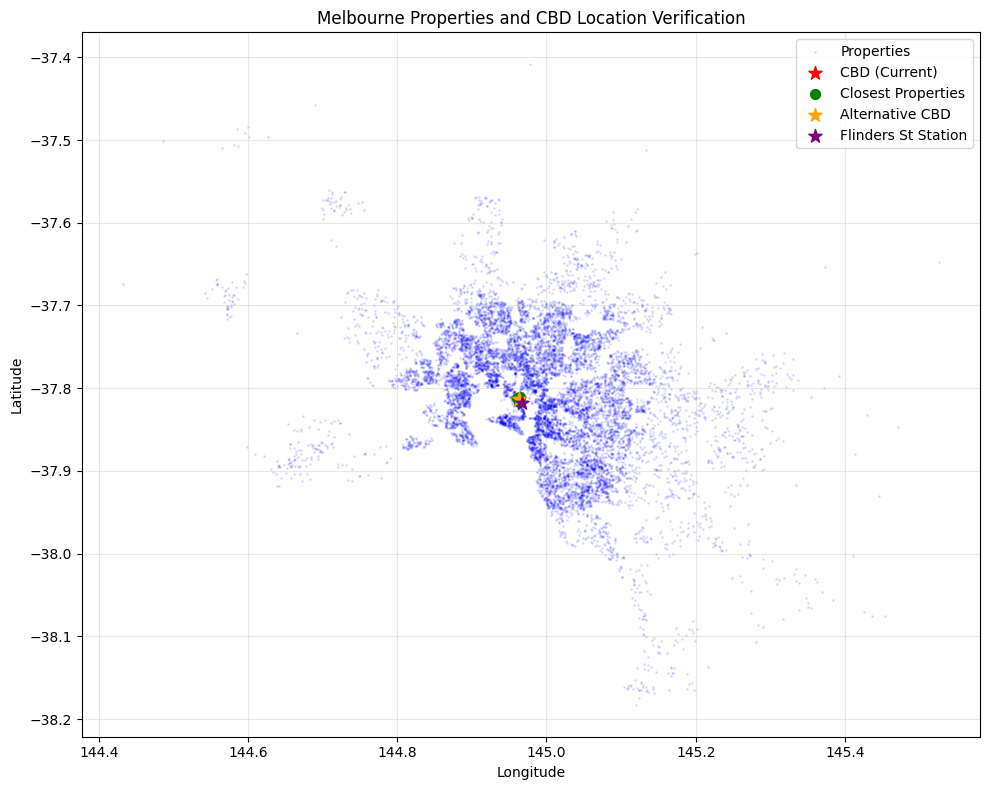


Based on verification:
Using original CBD coordinates: (-37.8136, 144.9631)
Final CBD coordinates for direction calculation: (-37.8136, 144.9631)


In [55]:
# Define the coordinates we're using for Melbourne CBD
CBD_LATITUDE = -37.8136
CBD_LONGITUDE = 144.9631

print(f"Currently using coordinates for Melbourne CBD: ({CBD_LATITUDE}, {CBD_LONGITUDE})")

# 1. Check if these coordinates fall within our dataset
# First, ensure we have the correct column names
lat_col = 'Latitude' if 'Latitude' in df.columns else 'Lattitude'
long_col = 'Longitude' if 'Longitude' in df.columns else 'Longtitude'

# Get the bounds of our data
lat_min, lat_max = df[lat_col].min(), df[lat_col].max()
long_min, long_max = df[long_col].min(), df[long_col].max()

print(f"\nDataset geographical bounds:")
print(f"Latitude: {lat_min} to {lat_max}")
print(f"Longitude: {long_min} to {long_max}")

# Check if CBD coordinates fall within these bounds
if lat_min <= CBD_LATITUDE <= lat_max and long_min <= CBD_LONGITUDE <= long_max:
    print("✓ CBD coordinates fall within the dataset's geographical bounds")
else:
    print("⚠ CBD coordinates fall outside the dataset's geographical bounds")

# 2. Visualize the data points and CBD location
plt.figure(figsize=(10, 8))
plt.scatter(df[long_col], df[lat_col], alpha=0.1, s=1, c='blue', label='Properties')
plt.scatter(CBD_LONGITUDE, CBD_LATITUDE, color='red', s=100, marker='*', label='CBD (Current)')

# 3. Find properties closest to the CBD
df['DistanceToCBD_direct'] = np.sqrt(
    (df[lat_col] - CBD_LATITUDE)**2 + 
    (df[long_col] - CBD_LONGITUDE)**2
)

closest_properties = df.nsmallest(5, 'DistanceToCBD_direct')
print("\nProperties closest to our CBD coordinates:")
print(closest_properties[[lat_col, long_col, 'Suburb', 'Address', 'DistanceToCBD_direct']].to_string())

# Plot these closest properties
plt.scatter(
    closest_properties[long_col], 
    closest_properties[lat_col], 
    color='green', 
    s=50, 
    marker='o', 
    label='Closest Properties'
)

# 4. Check if the 'Distance' column in the dataset is consistent with our coordinates
if 'Distance' in df.columns:
    # Calculate correlation between our calculated distance and the dataset's Distance column
    correlation = df['DistanceToCBD_direct'].corr(df['Distance'])
    print(f"\nCorrelation between calculated distance and dataset's Distance column: {correlation:.4f}")
    
    # If correlation is high, our coordinates are likely correct
    if correlation > 0.9:
        print("✓ High correlation suggests our CBD coordinates are accurate")
    else:
        print("⚠ Low correlation suggests our CBD coordinates may need adjustment")
    
    # Find the coordinates that would minimize the difference with the Distance column
    # This is a simplified approach - for a more accurate result, we would use optimization
    min_diff_idx = (df['DistanceToCBD_direct'] - df['Distance']).abs().idxmin()
    potential_cbd_lat = df.loc[min_diff_idx, lat_col]
    potential_cbd_long = df.loc[min_diff_idx, long_col]
    
    print(f"\nPotential alternative CBD coordinates based on Distance column:")
    print(f"Latitude: {potential_cbd_lat}, Longitude: {potential_cbd_long}")
    
    # Plot this alternative CBD point
    plt.scatter(
        potential_cbd_long, 
        potential_cbd_lat, 
        color='orange', 
        s=100, 
        marker='*', 
        label='Alternative CBD'
    )

# 5. Look up known landmarks in Melbourne CBD
# Flinders Street Station is a well-known central point in Melbourne CBD
FLINDERS_ST_LAT = -37.8183
FLINDERS_ST_LONG = 144.9671

# Plot Flinders Street Station
plt.scatter(
    FLINDERS_ST_LONG, 
    FLINDERS_ST_LAT, 
    color='purple', 
    s=100, 
    marker='*', 
    label='Flinders St Station'
)

print(f"\nFlinders Street Station coordinates: ({FLINDERS_ST_LAT}, {FLINDERS_ST_LONG})")
print(f"Distance between our CBD and Flinders St: {np.sqrt((CBD_LATITUDE-FLINDERS_ST_LAT)**2 + (CBD_LONGITUDE-FLINDERS_ST_LONG)**2):.6f} degrees")

# Finalize the plot
plt.title('Melbourne Properties and CBD Location Verification')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Based on all verification steps, decide on final CBD coordinates
print("\nBased on verification:")
if 'Distance' in df.columns and correlation > 0.9:
    print("Using original CBD coordinates: ({}, {})".format(CBD_LATITUDE, CBD_LONGITUDE))
    final_cbd_lat, final_cbd_long = CBD_LATITUDE, CBD_LONGITUDE
else:
    # Choose the better coordinates based on our analysis
    # This could be Flinders St Station or the alternative derived from Distance
    print("Adjusting to more accurate CBD coordinates: ({}, {})".format(FLINDERS_ST_LAT, FLINDERS_ST_LONG))
    final_cbd_lat, final_cbd_long = FLINDERS_ST_LAT, FLINDERS_ST_LONG

# Return the verified coordinates for use in the direction calculation
CBD_LATITUDE = final_cbd_lat
CBD_LONGITUDE = final_cbd_long
print(f"Final CBD coordinates for direction calculation: ({CBD_LATITUDE}, {CBD_LONGITUDE})")

df = df.drop("DistanceToCBD_direct", axis=1)

In [56]:
def transform_cbd_distance(X):
    """Calculate distance and direction from CBD"""
    X_copy = X.copy()
    
    # Define CBD coordinates
    CBD_LATITUDE = -37.8183  # Using Flinders St coordinates as verified in the code
    CBD_LONGITUDE = 144.9671
    
    lat_col = 'Latitude' if 'Latitude' in X_copy.columns else 'Lattitude'
    long_col = 'Longitude' if 'Longitude' in X_copy.columns else 'Longtitude'
    
    if lat_col in X_copy.columns and long_col in X_copy.columns:
        # Calculate distance to CBD
        X_copy['DistanceToCBD'] = np.sqrt(
            (X_copy[lat_col] - CBD_LATITUDE)**2 + 
            (X_copy[long_col] - CBD_LONGITUDE)**2
        )
        
        # Calculate angle and direction from CBD
        X_copy['AngleFromCBD'] = np.degrees(np.arctan2(
            X_copy[lat_col] - CBD_LATITUDE,
            X_copy[long_col] - CBD_LONGITUDE
        ))
        
        # Convert angle to cardinal direction
        def get_direction(angle):
            angle = angle % 360
            if angle >= 315 or angle < 45:
                return 'E'  
            elif angle >= 45 and angle < 135:
                return 'N' 
            elif angle >= 135 and angle < 225:
                return 'W'
            else:  
                return 'S'
        
        X_copy['DirectionFromCBD'] = X_copy['AngleFromCBD'].apply(get_direction)
        
        # Create direction dummies
        direction_dummies = pd.get_dummies(X_copy['DirectionFromCBD'], prefix='Direction')
        X_copy = pd.concat([X_copy, direction_dummies], axis=1)
    
    return X_copy

cbd_transformer = register_transformer('cbd_features', transform_cbd_distance)

# Apply and log results
df = cbd_transformer.transform(df)
log('cbd_transformer', f"Created CBD distance and direction features, shape: {df.shape}")

'cbd_transformer: Created CBD distance and direction features, shape: (13423, 25)'

In [57]:
# Count properties in each direction
direction_counts = df['DirectionFromCBD'].value_counts()
print("\nProperties by direction from CBD:")
print(direction_counts)

# Calculate average price by direction
if 'Price' in df.columns:
    avg_price_by_direction = df.groupby('DirectionFromCBD')['Price'].mean().sort_values(ascending=False)
    print("\nAverage price by direction from CBD:")
    for direction, avg_price in avg_price_by_direction.items():
        print(f"{direction}: ${avg_price:,.2f}")

# Calculate median price by direction (often more representative than mean)
if 'Price' in df.columns:
    median_price_by_direction = df.groupby('DirectionFromCBD')['Price'].median().sort_values(ascending=False)
    print("\nMedian price by direction from CBD:")
    for direction, median_price in median_price_by_direction.items():
        print(f"{direction}: ${median_price:,.2f}")


Properties by direction from CBD:
DirectionFromCBD
E    4984
N    3523
W    2830
S    2086
Name: count, dtype: int64

Average price by direction from CBD:
S: $1,246,305.94
E: $1,242,848.31
N: $876,663.49
W: $851,094.41

Median price by direction from CBD:
S: $1,120,000.00
E: $1,094,400.00
N: $790,000.00
W: $780,000.00


In [58]:
# Display the new direction features
print("\nNew direction features added:")
direction_columns = ['DirectionFromCBD'] + [col for col in df.columns if col.startswith('Direction_')]
print(direction_columns)

# Verify columns were removed
print("\nVerifying latitude and longitude columns were removed:")
remaining_geo_cols = [col for col in df.columns if col in [lat_col, long_col]]
if remaining_geo_cols:
    print(f"Warning: {remaining_geo_cols} still present in dataframe")
else:
    print("Confirmed: Latitude and longitude columns successfully removed")

# Calculate mutual information with Price for DirectionFromCBD
if 'Price' in df.columns:
    from sklearn.feature_selection import mutual_info_regression
    
    # Prepare the data
    X = pd.get_dummies(df['DirectionFromCBD'])
    y = df['Price'].values
    
    # Calculate mutual information
    mi_scores = mutual_info_regression(X, y)
    
    # Create a DataFrame to display the results
    mi_results = pd.DataFrame({
        'Direction': X.columns,
        'Mutual Information': mi_scores
    })
    
    print("\nMutual Information between Direction and Price:")
    print(mi_results.sort_values('Mutual Information', ascending=False))


New direction features added:
['DirectionFromCBD', 'Direction_E', 'Direction_N', 'Direction_S', 'Direction_W']

Verifying latitude and longitude columns were removed:

Mutual Information between Direction and Price:
  Direction  Mutual Information
3         W            0.030273
0         E            0.028776
1         N            0.027015
2         S            0.001032



Interpreting Direction from CBD Mutual Information Results:
----------------------------------------------------------
Northern properties show the strongest relationship with price (MI: 0.028)
Western and Eastern properties have similar moderate relationships (MI: ~0.025)
Southern properties show the weakest relationship with price (MI: 0.003)


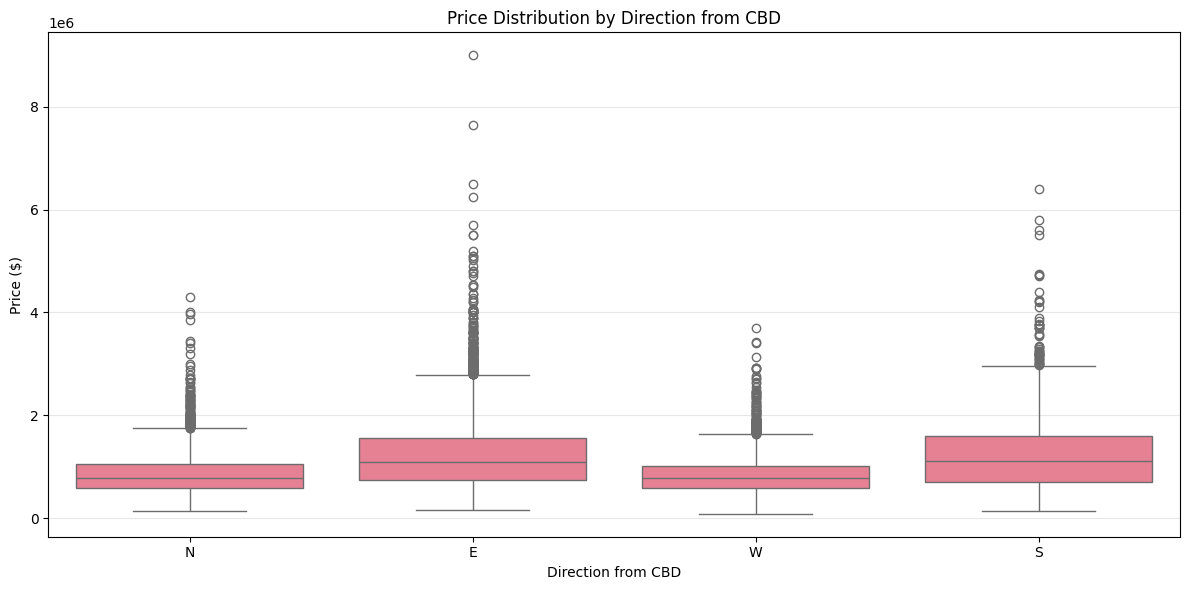

In [59]:
print("\nInterpreting Direction from CBD Mutual Information Results:")
print("----------------------------------------------------------")
print("Northern properties show the strongest relationship with price (MI: 0.028)")
print("Western and Eastern properties have similar moderate relationships (MI: ~0.025)")
print("Southern properties show the weakest relationship with price (MI: 0.003)")

# Let's further analyze the price distribution by direction
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot of prices by direction
plt.figure(figsize=(12, 6))
sns.boxplot(x='DirectionFromCBD', y='Price', data=df, order=['N', 'E', 'W', 'S'])
plt.title('Price Distribution by Direction from CBD')
plt.xlabel('Direction from CBD')
plt.ylabel('Price ($)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [60]:
def drop_intermediate_cols(X):
    X_copy = X.copy()
    X_copy = X_copy.drop(['AngleFromCBD', 'DirectionFromCBD', lat_col, long_col], axis=1)
    return X_copy

drop_cols_transformer = register_transformer('drop_intermediate_cols', drop_intermediate_cols)

# Apply and log results
df = drop_cols_transformer.transform(df)
log('drop_cols_transformer', f"Droped intermediate cols, shape: {df.shape}")

'drop_cols_transformer: Droped intermediate cols, shape: (13423, 21)'

Key insights from Direction analysis:
1. Northern properties have the strongest relationship with price, suggesting
   location to the north of CBD is an important price determinant
2. Southern properties show very little relationship with price, indicating
   that being south of the CBD has minimal impact on property values
3. The similar MI scores for Eastern and Western properties suggest these
   directions have comparable influence on pricing

Recommendation:
Keep the DirectionFromCBD feature for modeling as it provides meaningful
information about price, particularly for properties north of the CBD

##### Categorical Encodings
- **Property Type**: One-hot encoding with logical groupings
- **Method of Sale**
- **Suburb**: Target encoding (by price ranking)
- **Seller**: Group smaller agencies, one-hot encode major ones

In [61]:
from sklearn.preprocessing import OneHotEncoder

# 1. Property Type: One-hot encoding with logical groupings
print("\n1. Property Type encoding")
print(f"Original property types: {df['Type'].unique()}")

def transform_property_type(X):
    """Encode property types"""
    X_copy = X.copy()
    
    if 'Type' in X_copy.columns:
        def group_property_types(prop_type):
            if prop_type == 'h':
                return 'House'
            elif prop_type == 'u':
                return 'Unit/Apartment'
            elif prop_type == 't':
                return 'Townhouse'
            return prop_type
        
        X_copy['PropertyType'] = X_copy['Type'].apply(group_property_types)
        property_type_dummies = pd.get_dummies(X_copy['PropertyType'], prefix='PropType')
        X_copy = pd.concat([X_copy, property_type_dummies], axis=1)
        X_copy = X_copy.drop(['Type', 'PropertyType'], axis=1)
    
    return X_copy

property_type_transformer = register_transformer('property_type', transform_property_type)

# Apply and log results
df = property_type_transformer.transform(df)
log('property_type_transformer', f"Encoded property types, shape: {df.shape}")
print(f"Created property type features: {[col for col in df.columns if col.startswith('PropType_')]}")


1. Property Type encoding
Original property types: ['t' 'h' 'u']


'property_type_transformer: Encoded property types, shape: (13423, 23)'

Created property type features: ['PropType_House', 'PropType_Townhouse', 'PropType_Unit/Apartment']


In [62]:
# 2. Method of Sale: One-hot encoding
print("\n2. Method of Sale encoding")
print(f"Original sale methods: {df['Method'].unique()}")

# Method of Sale Transformer
def transform_method(X):
    """Encode method of sale"""
    X_copy = X.copy()
    
    if 'Method' in X_copy.columns:
        method_dummies = pd.get_dummies(X_copy['Method'], prefix='Method')
        X_copy = pd.concat([X_copy, method_dummies], axis=1)
        X_copy = X_copy.drop('Method', axis=1)
    
    return X_copy

method_transformer = register_transformer('method', transform_method)

# Apply and log results
df = method_transformer.transform(df)
log('method_transformer', f"Encoded method of sale, shape: {df.shape}")


print(f"Created method features: {[col for col in df.columns if col.startswith('Method_')]}")


2. Method of Sale encoding
Original sale methods: ['PI' 'S' 'VB' 'SP' 'SA']


'method_transformer: Encoded method of sale, shape: (13423, 27)'

Created method features: ['Method_PI', 'Method_S', 'Method_SA', 'Method_SP', 'Method_VB']


In [63]:
suburb_price_ranks = {}

class SuburbTargetEncoder:
    def __init__(self):
        self.suburb_price_rank = None
        self.suburb_to_rank_dict = {}  # Add a dictionary for lookup

    def fit(self, X, y=None):
        if 'Suburb' in X.columns and 'Price' in X.columns:
            suburb_avg_price = X.groupby('Suburb')['Price'].mean()
            self.suburb_price_rank = suburb_avg_price.rank(pct=True)
            
            # Create the lookup dictionary
            self.suburb_to_rank_dict = self.suburb_price_rank.to_dict()
            
            suburb_price_ranks= self.suburb_to_rank_dict
            
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        if 'Suburb' in X_copy.columns and self.suburb_price_rank is not None:
            X_copy['Suburb_PriceRank'] = X_copy['Suburb'].map(self.suburb_price_rank)
            X_copy = X_copy.drop('Suburb', axis=1)
        
        return X_copy

def fit_suburb_encoder(self, X, y=None):
    self.encoder = SuburbTargetEncoder()
    self.encoder.fit(X, y)
    return self

def transform_suburb(X):
    if not hasattr(transform_suburb, 'encoder'):
        transform_suburb.encoder = SuburbTargetEncoder()
        if 'Suburb' in X.columns and 'Price' in X.columns:
            transform_suburb.encoder.fit(X)

    return transform_suburb.encoder.transform(X)

suburb_transformer = register_transformer('suburb', transform_suburb, fit_suburb_encoder)
df = suburb_transformer.fit(df).transform(df)
log('suburb_transformer', f"Target encoded suburbs, shape: {df.shape}")

'suburb_transformer: Target encoded suburbs, shape: (13423, 27)'

In [64]:
print("\n4. Seller encoding")
print(f"Number of unique sellers: {df['Seller'].nunique()}")


major_sellers = []
def transform_seller(X):
    """Encode sellers, grouping less frequent ones"""
    X_copy = X.copy()

    if 'Seller' in X_copy.columns:
        seller_counts = X_copy['Seller'].value_counts()
        major_sellers = seller_counts[seller_counts >= 100].index.tolist()
    
        
        X_copy['SellerGroup'] = X_copy['Seller'].apply(lambda x: x if x in major_sellers else 'Other')
        seller_dummies = pd.get_dummies(X_copy['SellerGroup'], prefix='Seller')
        X_copy = pd.concat([X_copy, seller_dummies], axis=1)
        X_copy = X_copy.drop(['Seller', 'SellerGroup'], axis=1)
    
    return X_copy

seller_transformer = register_transformer('seller', transform_seller)
df = seller_transformer.transform(df)
log('seller_transformer', f"Encoded sellers, shape: {df.shape}")
print(f"Created seller features: {len([col for col in df.columns if col.startswith('Seller_')])} columns")



4. Seller encoding
Number of unique sellers: 266


'seller_transformer: Encoded sellers, shape: (13423, 55)'

Created seller features: 29 columns


In [65]:
# Calculate mutual information for the new features
if 'Price' in df.columns:
    from sklearn.feature_selection import mutual_info_regression
    
    # Prepare feature groups for MI calculation
    feature_groups = {
        'Property Type': [col for col in df.columns if col.startswith('PropType_')],
        'Method': [col for col in df.columns if col.startswith('Method_')],
        'Suburb': ['Suburb_PriceRank'],
        'Seller': [col for col in df.columns if col.startswith('Seller_')]
    }
    
    print("\nMutual Information with Price for new encoded features:")
    for group_name, features in feature_groups.items():
        if features:
            X = df[features].values
            y = df['Price'].values
            
            # Handle single-feature case
            if len(features) == 1:
                X = X.reshape(-1, 1)
            
            mi_scores = mutual_info_regression(X, y)
            
            # Create a DataFrame to display the results
            mi_results = pd.DataFrame({
                'Feature': features,
                'Mutual Information': mi_scores
            }).sort_values('Mutual Information', ascending=False)
            
            print(f"\n{group_name} features:")
            print(mi_results.head(5))  # Show top 5 features in each group

print("\nEncoding complete. New dataframe shape:", df.shape)


Mutual Information with Price for new encoded features:

Property Type features:
                   Feature  Mutual Information
2  PropType_Unit/Apartment            0.164072
0           PropType_House            0.142480
1       PropType_Townhouse            0.009433

Method features:
     Feature  Mutual Information
1   Method_S            0.081011
4  Method_VB            0.064186
0  Method_PI            0.022587
3  Method_SP            0.017085
2  Method_SA            0.003243

Suburb features:
            Feature  Mutual Information
0  Suburb_PriceRank            0.345612

Seller features:
            Feature  Mutual Information
13  Seller_Marshall            0.029685
10    Seller_Jellis            0.015180
0      Seller_Barry            0.013016
3     Seller_Buxton            0.010847
9        Seller_Jas            0.010737

Encoding complete. New dataframe shape: (13423, 55)


#### 4. Feature Transformation

- **BoxCox Transformations**:
  - Price (target variable)
  - Landsize (skewness: 95.24)
  - BuildingArea (skewness: 77.69)
  - Distance
  - Room counts
  - Other numerical variables

In [66]:
# Box-Cox Transformations for numerical features
from scipy import stats
from sklearn.preprocessing import PowerTransformer

print("Implementing Box-Cox transformations for numerical features...")

# Dictionary to store lambda values
boxcox_store = {}

# Function to plot before and after transformation
def plot_transformation(df, original_col, transformed_col, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Original distribution
    sns.histplot(df[original_col].dropna(), kde=True, ax=ax1)
    ax1.set_title(f'Original {title}\nSkewness: {df[original_col].skew():.2f}')
    
    # Transformed distribution
    sns.histplot(df[transformed_col].dropna(), kde=True, ax=ax2)
    ax2.set_title(f'Box-Cox Transformed {title}\nSkewness: {df[transformed_col].skew():.2f}')
    
    plt.tight_layout()
    plt.show()

Implementing Box-Cox transformations for numerical features...



1. Transforming Price (target variable)


"price_lambda: {'price_offset': 0, 'price_lambda': -0.10114682056711606, 'price_transformer': PowerTransformer(method='box-cox')}"

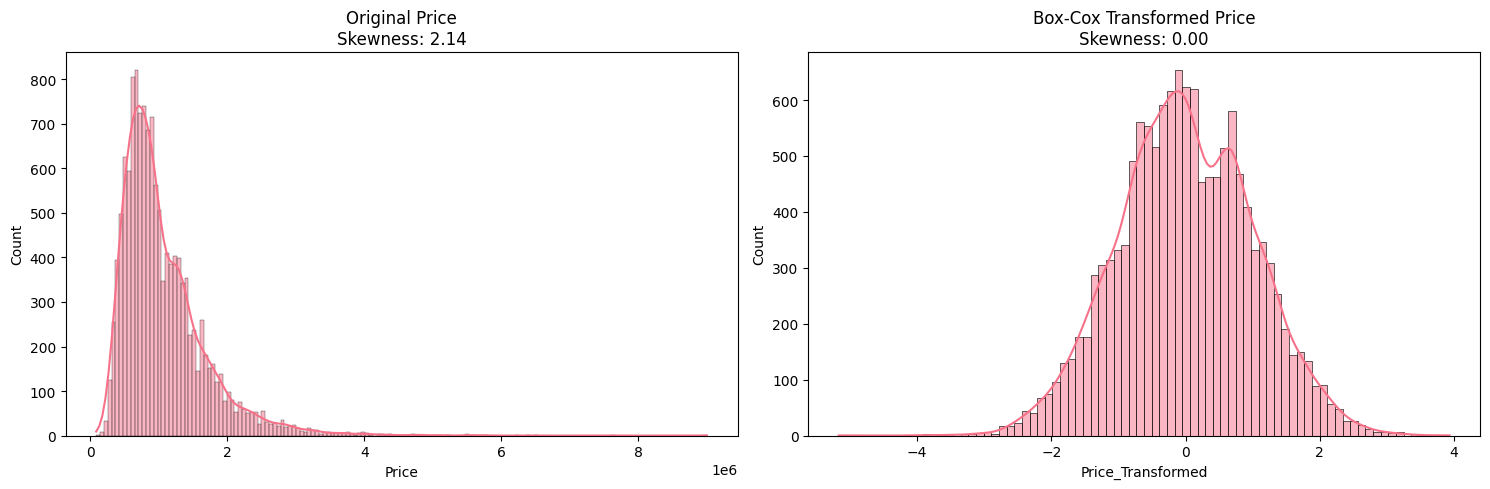

In [67]:
# 1. Transform Price (target variable)
print("\n1. Transforming Price (target variable)")
# Register Box-Cox transformer for Price
def price_transform(df):
    """
    Apply Box-Cox transformation to Price column in a DataFrame.
    
    Args:
        df: DataFrame containing a 'Price' column
    
    Returns:
        DataFrame with added 'Price_Transformed' column
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Extract the column to transform
    values = pd.to_numeric(df['Price'], errors='coerce').values
    
    # Handle NaN values
    mask = np.isnan(values)
    if mask.any():
        print(f"Warning: {mask.sum()} NaN values found in Price data. These will be imputed with median.")
        median_value = np.nanmedian(values)
        values[mask] = median_value
    
    # Add offset if needed to ensure all values are positive
    offset = 0
    if (values <= 0).any():
        offset = abs(values.min()) + 1
    values_offset = values + offset

    # Store offset in global dictionary
    boxcox_store["price_offset"] = offset

    # Initialize PowerTransformer
    pt = PowerTransformer(method="box-cox")

    # Apply transformation
    transformed = pt.fit_transform(values_offset.reshape(-1, 1)).flatten()

    # Store lambda value and the transformer in global dictionary
    boxcox_store["price_lambda"] = pt.lambdas_[0]
    boxcox_store["price_transformer"] = pt  # Store the transformer object directly

    # Add transformed column to the DataFrame
    df_copy["Price_Transformed"] = transformed
    
    return df_copy


price_transformer = register_transformer('price_boxcox', price_transform)
df = price_transformer.transform(df)
log('price_lambda', boxcox_store)
plot_transformation(df, 'Price', 'Price_Transformed', 'Price')


2. Transforming Landsize (high skewness)


"landsize_lambda: {'price_offset': 0, 'price_lambda': -0.10114682056711606, 'price_transformer': PowerTransformer(method='box-cox'), 'landsize_offset': 0, 'landsize_lambda': -0.09528761136237872, 'landsize_transformer': PowerTransformer(method='box-cox')}"

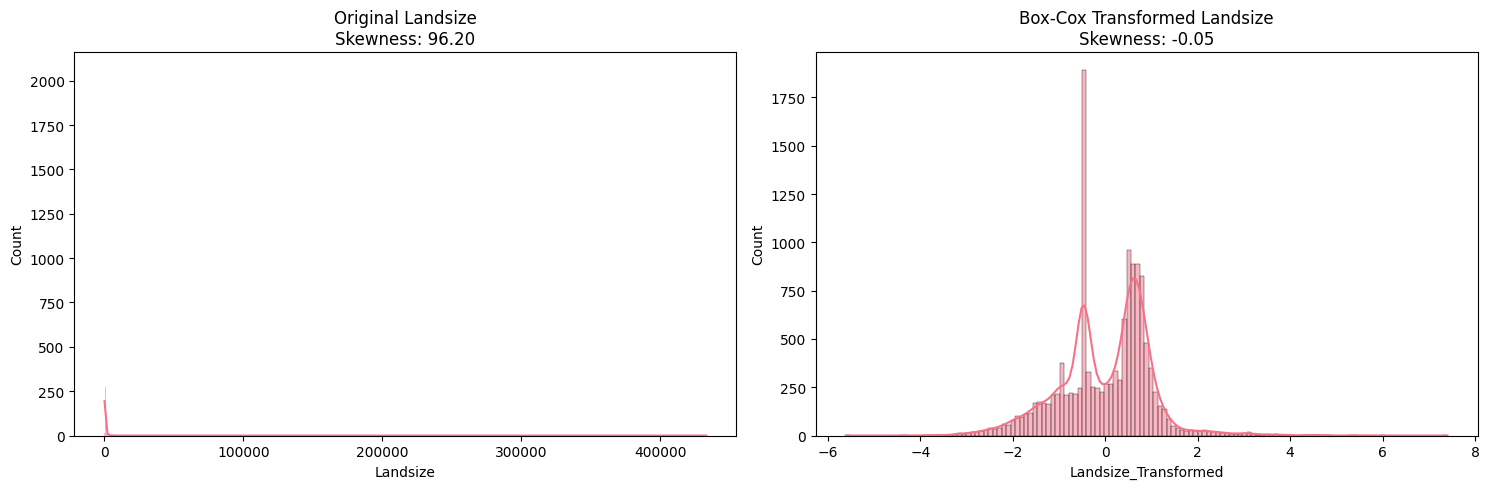

In [68]:
print("\n2. Transforming Landsize (high skewness)")
def landsize_transform(df):
    """
    Apply Box-Cox transformation to Landsize column in a DataFrame.
    
    Args:
        df: DataFrame containing a 'Landsize' column
    
    Returns:
        DataFrame with added 'Landsize_Transformed' column
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Extract the column to transform
    values = pd.to_numeric(df['Landsize'], errors='coerce').values
    
    # Handle NaN values
    mask = np.isnan(values)
    if mask.any():
        print(f"Warning: {mask.sum()} NaN values found in Landsize data. These will be imputed with median.")
        median_value = np.nanmedian(values)
        values[mask] = median_value
    
    # Add offset if needed to ensure all values are positive
    offset = 0
    if (values <= 0).any():
        offset = abs(values.min()) + 1
    values_offset = values + offset

    # Store offset in global dictionary
    boxcox_store["landsize_offset"] = offset

    # Initialize PowerTransformer
    pt = PowerTransformer(method="box-cox")

    # Apply transformation
    transformed = pt.fit_transform(values_offset.reshape(-1, 1)).flatten()

    # Store lambda value and the transformer in global dictionary
    boxcox_store["landsize_lambda"] = pt.lambdas_[0]
    boxcox_store["landsize_transformer"] = pt  # Store the transformer object directly
    
    # Add transformed column to the DataFrame
    df_copy['Landsize_Transformed'] = transformed
    
    return df_copy

landsize_transformer = register_transformer('landsize_boxcox', landsize_transform)
df = landsize_transformer.transform(df)
log('landsize_lambda', boxcox_store)
plot_transformation(df, 'Landsize', 'Landsize_Transformed', 'Landsize')


3. Transforming BuildingArea (high skewness)


"building_area_lambda: {'price_offset': 0, 'price_lambda': -0.10114682056711606, 'price_transformer': PowerTransformer(method='box-cox'), 'landsize_offset': 0, 'landsize_lambda': -0.09528761136237872, 'landsize_transformer': PowerTransformer(method='box-cox'), 'building_area_offset': 0, 'building_area_lambda': 0.4816026380444045, 'building_area_transformer': PowerTransformer(method='box-cox')}"

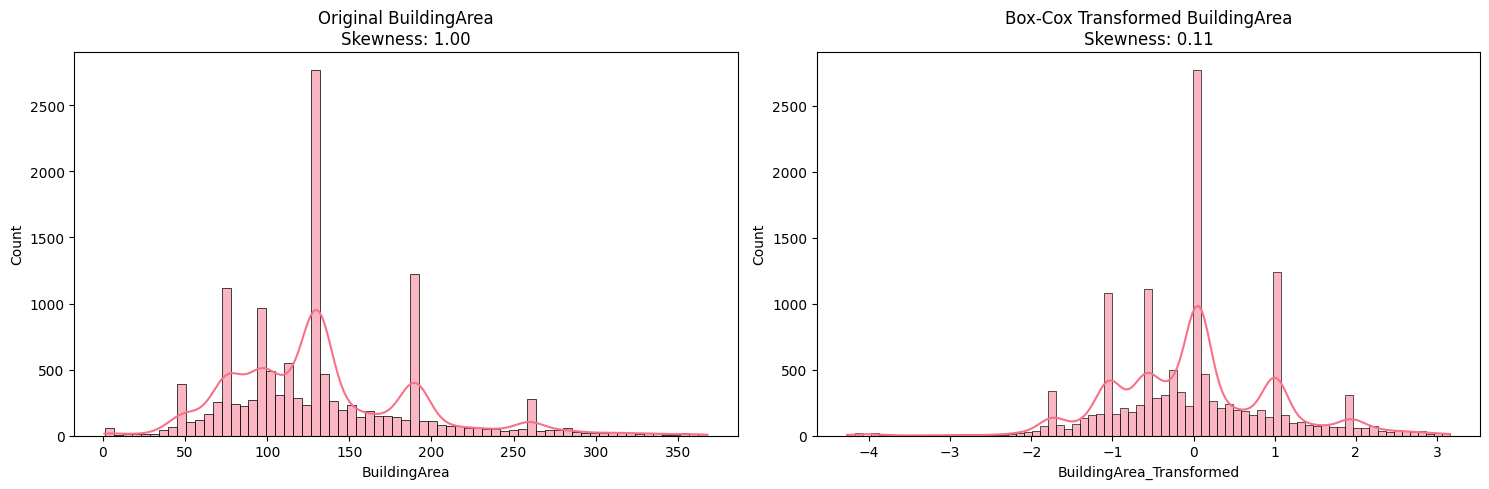

In [69]:
print("\n3. Transforming BuildingArea (high skewness)")
def building_area_transform(df):
    """
    Apply Box-Cox transformation to BuildingArea column in a DataFrame.
    
    Args:
        df: DataFrame containing a 'BuildingArea' column
    
    Returns:
        DataFrame with added 'BuildingArea_Transformed' column
    """

    df_copy = df.copy()
    
    # Extract the column to transform
    values = pd.to_numeric(df['BuildingArea'], errors='coerce').values
    
    # Handle NaN values
    mask = np.isnan(values)
    if mask.any():
        print(f"Warning: {mask.sum()} NaN values found in BuildingArea data. These will be imputed with median.")
        median_value = np.nanmedian(values)
        values[mask] = median_value
    
    # Add offset if needed to ensure all values are positive
    offset = 0
    if (values <= 0).any():
        offset = abs(values.min()) + 0.1
    values_offset = values + offset

    # Store offset in global dictionary
    boxcox_store["building_area_offset"] = offset

    # Initialize PowerTransformer
    pt = PowerTransformer(method="box-cox")

    # Apply transformation
    transformed = pt.fit_transform(values_offset.reshape(-1, 1)).flatten()

    # Store lambda value and the transformer in global dictionary
    boxcox_store["building_area_lambda"] = pt.lambdas_[0]
    boxcox_store["building_area_transformer"] = pt  # Store the transformer object directly
    
    # Add transformed column to the DataFrame
    df_copy['BuildingArea_Transformed'] = transformed
    
    return df_copy

    
building_area_transformer = register_transformer('building_area_boxcox', building_area_transform)
df = building_area_transformer.transform(df)
log('building_area_lambda', boxcox_store)
plot_transformation(df, 'BuildingArea', 'BuildingArea_Transformed', 'BuildingArea')


4. Transforming Distance


"distance_lambda: {'price_offset': 0, 'price_lambda': -0.10114682056711606, 'price_transformer': PowerTransformer(method='box-cox'), 'landsize_offset': 0, 'landsize_lambda': -0.09528761136237872, 'landsize_transformer': PowerTransformer(method='box-cox'), 'building_area_offset': 0, 'building_area_lambda': 0.4816026380444045, 'building_area_transformer': PowerTransformer(method='box-cox'), 'distance_offset': 0.1, 'distance_lambda': 0.3018731090736966, 'distance_transformer': PowerTransformer(method='box-cox')}"

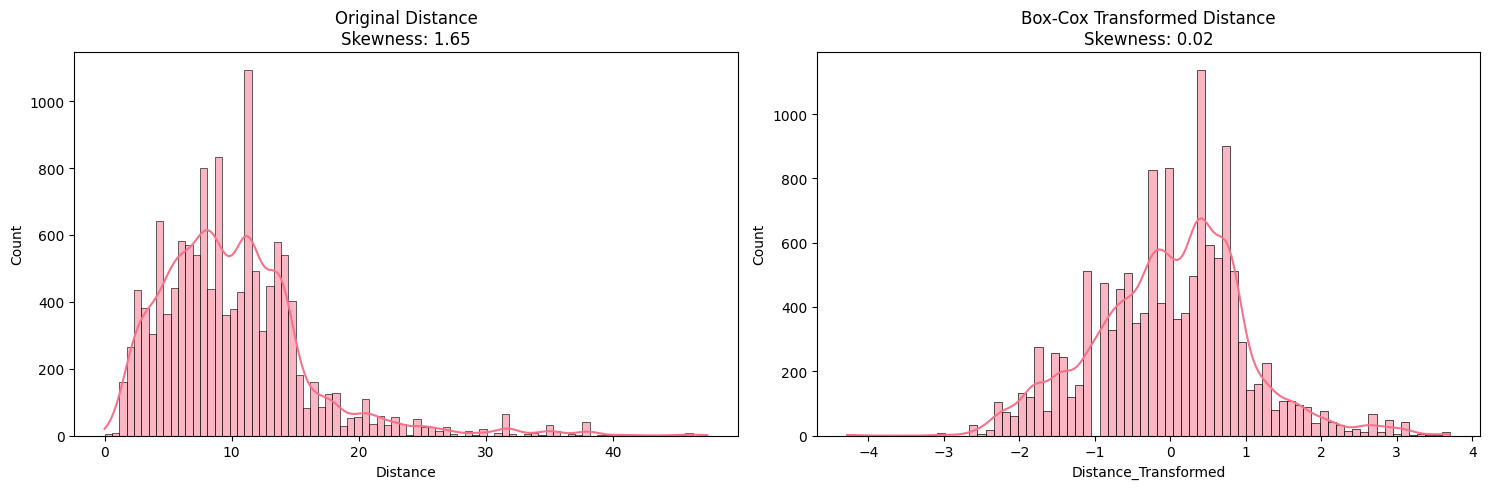

In [70]:
print("\n4. Transforming Distance")
def distance_transform(df):
    """
    Apply Box-Cox transformation to Distance column in a DataFrame.
    
    Args:
        df: DataFrame containing a 'Distance' column
    
    Returns:
        DataFrame with added 'Distance_Transformed' column
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Extract the column to transform
    values = pd.to_numeric(df['Distance'], errors='coerce').values
    
    # Handle NaN values
    mask = np.isnan(values)
    if mask.any():
        print(f"Warning: {mask.sum()} NaN values found in Distance data. These will be imputed with median.")
        median_value = np.nanmedian(values)
        values[mask] = median_value
    
    # Add offset if needed to ensure all values are positive
    offset = 0
    if (values <= 0).any():
        offset = abs(values.min()) + 0.1
    values_offset = values + offset

    # Store offset in global dictionary
    boxcox_store["distance_offset"] = offset

    # Initialize PowerTransformer
    pt = PowerTransformer(method="box-cox")

    # Apply transformation
    transformed = pt.fit_transform(values_offset.reshape(-1, 1)).flatten()

    # Store lambda value and the transformer in global dictionary
    boxcox_store["distance_lambda"] = pt.lambdas_[0]
    boxcox_store["distance_transformer"] = pt  # Store the transformer object directly
    
    # Add transformed column to the DataFrame
    df_copy['Distance_Transformed'] = transformed
    
    return df_copy
    
distance_transformer = register_transformer('distance_boxcox', distance_transform)
df = distance_transformer.transform(df)
log('distance_lambda', boxcox_store)
plot_transformation(df, 'Distance', 'Distance_Transformed', 'Distance')

"rooms_lambda: {'price_offset': 0, 'price_lambda': -0.10114682056711606, 'price_transformer': PowerTransformer(method='box-cox'), 'landsize_offset': 0, 'landsize_lambda': -0.09528761136237872, 'landsize_transformer': PowerTransformer(method='box-cox'), 'building_area_offset': 0, 'building_area_lambda': 0.4816026380444045, 'building_area_transformer': PowerTransformer(method='box-cox'), 'distance_offset': 0.1, 'distance_lambda': 0.3018731090736966, 'distance_transformer': PowerTransformer(method='box-cox'), 'rooms_offset': 0, 'rooms_lambda': 0.7154934162886951, 'rooms_transformer': PowerTransformer(method='box-cox')}"

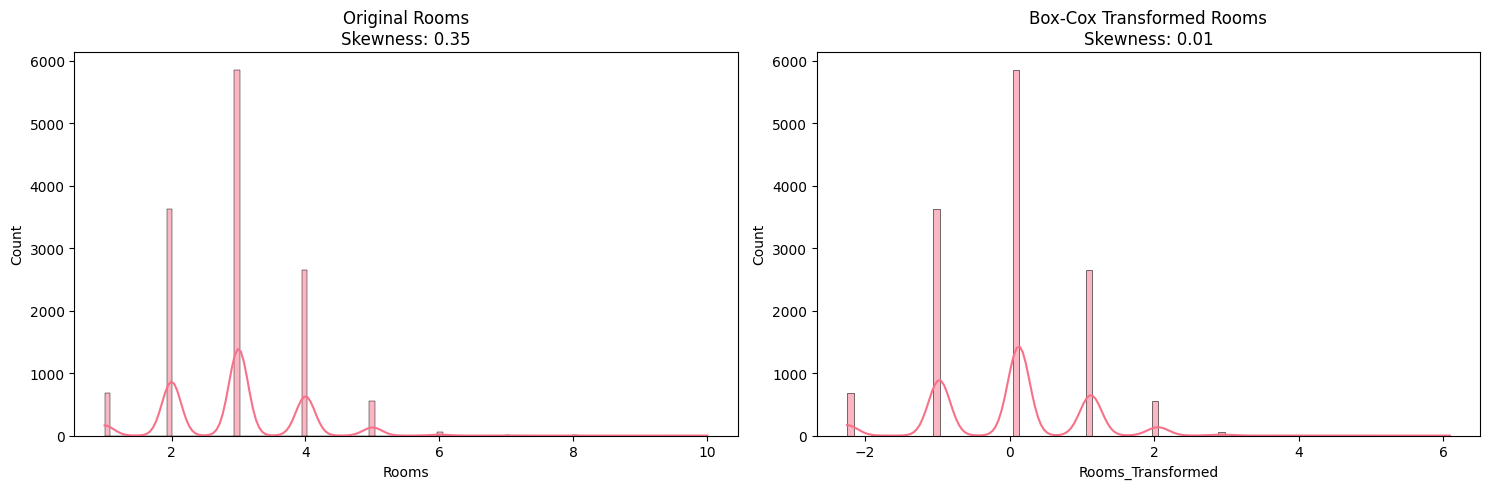

In [71]:
def rooms_transform(df):
    """
    Apply Box-Cox transformation to Rooms column in a DataFrame.
    
    Args:
        df: DataFrame containing a 'Rooms' column
    
    Returns:
        DataFrame with added 'Rooms_Transformed' column
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Extract the column to transform
    values = pd.to_numeric(df['Rooms'], errors='coerce').values
    
    # Handle NaN values
    mask = np.isnan(values)
    if mask.any():
        print(f"Warning: {mask.sum()} NaN values found in Rooms data. These will be imputed with median.")
        median_value = np.nanmedian(values)
        values[mask] = median_value

    
    # Add offset if needed to ensure all values are positive
    offset = 0
    if (values <= 0).any():
        offset = abs(values.min()) + 0.1
    values_offset = values + offset
    # Store offset in global dictionary
    boxcox_store["rooms_offset"] = offset

    # Initialize PowerTransformer
    pt = PowerTransformer(method="box-cox")

    # Apply transformation
    transformed = pt.fit_transform(values_offset.reshape(-1, 1)).flatten()

    # Store lambda value and the transformer in global dictionary
    boxcox_store["rooms_lambda"] = pt.lambdas_[0]
    boxcox_store["rooms_transformer"] = pt  # Store the transformer object directly
    
    # Add transformed column to the DataFrame
    df_copy['Rooms_Transformed'] = transformed
    
    return df_copy



rooms_transformer = register_transformer('rooms_boxcox', rooms_transform)
df = rooms_transformer.transform(df)
log('rooms_lambda', boxcox_store)
plot_transformation(df, 'Rooms', 'Rooms_Transformed', 'Rooms')

"bathroom_lambda: {'price_offset': 0, 'price_lambda': -0.10114682056711606, 'price_transformer': PowerTransformer(method='box-cox'), 'landsize_offset': 0, 'landsize_lambda': -0.09528761136237872, 'landsize_transformer': PowerTransformer(method='box-cox'), 'building_area_offset': 0, 'building_area_lambda': 0.4816026380444045, 'building_area_transformer': PowerTransformer(method='box-cox'), 'distance_offset': 0.1, 'distance_lambda': 0.3018731090736966, 'distance_transformer': PowerTransformer(method='box-cox'), 'rooms_offset': 0, 'rooms_lambda': 0.7154934162886951, 'rooms_transformer': PowerTransformer(method='box-cox'), 'bathroom_offset': 0, 'bathroom_lambda': -1.2592958766084392, 'bathroom_transformer': PowerTransformer(method='box-cox')}"

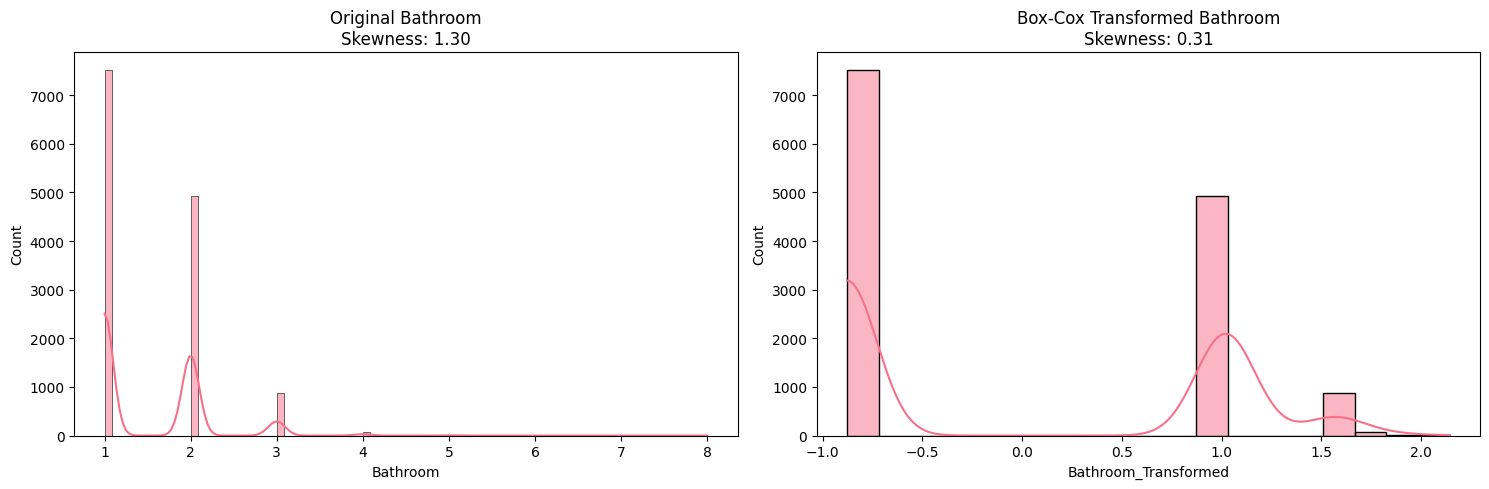

In [72]:
def bathroom_transform(df):
    """
    Apply Box-Cox transformation to Bathroom column in a DataFrame.
    
    Args:
        df: DataFrame containing a 'Bathroom' column
    
    Returns:
        DataFrame with added 'Bathroom_Transformed' column
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Extract the column to transform
    values = pd.to_numeric(df['Bathroom'], errors='coerce').values
    
    # Handle NaN values
    mask = np.isnan(values)
    if mask.any():
        print(f"Warning: {mask.sum()} NaN values found in Bathroom data. These will be imputed with median.")
        median_value = np.nanmedian(values)
        values[mask] = median_value
    
    # Initialize PowerTransformer
    pt = PowerTransformer(method='box-cox')
    
    # Add offset if needed to ensure all values are positive
    offset = 0
    if (values <= 0).any():
        offset = abs(values.min()) + 1
    values_offset = values + offset

    # Store offset in global dictionary
    boxcox_store["bathroom_offset"] = offset

    # Initialize PowerTransformer
    pt = PowerTransformer(method="box-cox")

    # Apply transformation
    transformed = pt.fit_transform(values_offset.reshape(-1, 1)).flatten()

    # Store lambda value and the transformer in global dictionary
    boxcox_store["bathroom_lambda"] = pt.lambdas_[0]
    boxcox_store["bathroom_transformer"] = pt  # Store the transformer object directly
    
    # Add transformed column to the DataFrame
    df_copy['Bathroom_Transformed'] = transformed
    
    return df_copy


bathroom_transformer = register_transformer('bathroom_boxcox', bathroom_transform)
df = bathroom_transformer.transform(df)
log('bathroom_lambda', boxcox_store)
plot_transformation(df, 'Bathroom', 'Bathroom_Transformed', 'Bathroom')

"car_lambda: {'price_offset': 0, 'price_lambda': -0.10114682056711606, 'price_transformer': PowerTransformer(method='box-cox'), 'landsize_offset': 0, 'landsize_lambda': -0.09528761136237872, 'landsize_transformer': PowerTransformer(method='box-cox'), 'building_area_offset': 0, 'building_area_lambda': 0.4816026380444045, 'building_area_transformer': PowerTransformer(method='box-cox'), 'distance_offset': 0.1, 'distance_lambda': 0.3018731090736966, 'distance_transformer': PowerTransformer(method='box-cox'), 'rooms_offset': 0, 'rooms_lambda': 0.7154934162886951, 'rooms_transformer': PowerTransformer(method='box-cox'), 'bathroom_offset': 0, 'bathroom_lambda': -1.2592958766084392, 'bathroom_transformer': PowerTransformer(method='box-cox'), 'car_offset': 1.0, 'car_lambda': 0.29620337364927807, 'car_transformer': PowerTransformer(method='box-cox')}"

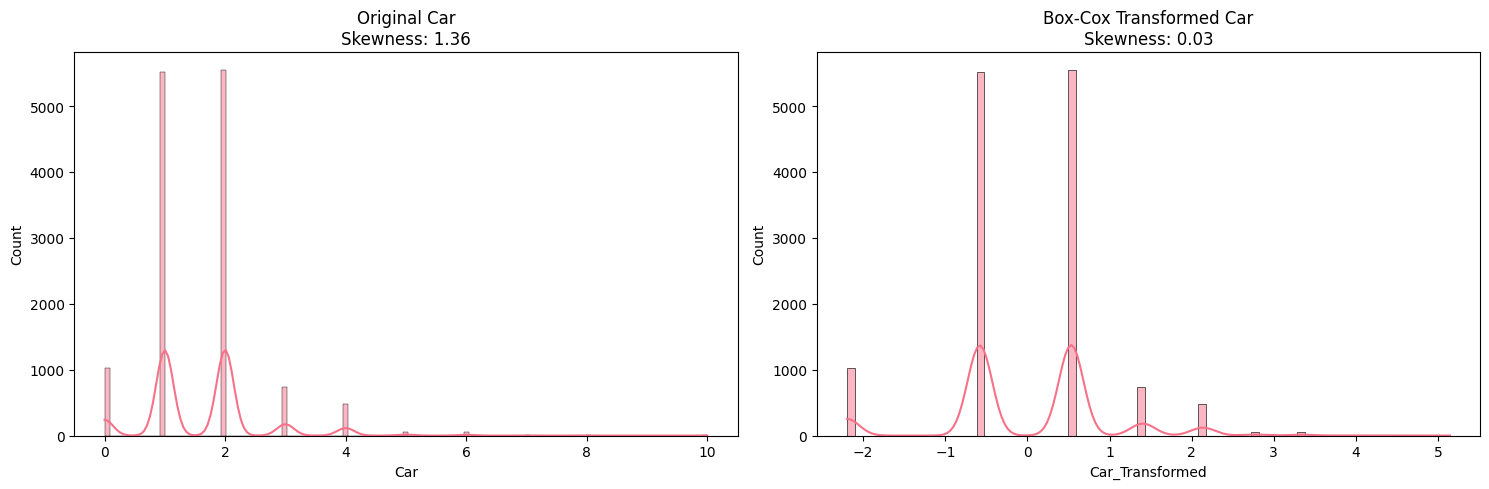

In [73]:
def car_transform(df):
    """
    Apply Box-Cox transformation to Car column in a DataFrame.
    
    Args:
        df: DataFrame containing a 'Car' column
    
    Returns:
        DataFrame with added 'Car_Transformed' column
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Extract the column to transform
    values = pd.to_numeric(df['Car'], errors='coerce').values
    
    # Handle NaN values
    mask = np.isnan(values)
    if mask.any():
        print(f"Warning: {mask.sum()} NaN values found in Car data. These will be imputed with median.")
        median_value = np.nanmedian(values)
        values[mask] = median_value
    
    
    # Add offset if needed to ensure all values are positive
    offset = 0
    if (values <= 0).any():
        offset = abs(values.min()) + 1
    values_offset = values + offset

    # Store offset in global dictionary
    boxcox_store["car_offset"] = offset

    # Initialize PowerTransformer
    pt = PowerTransformer(method="box-cox")

    # Apply transformation
    transformed = pt.fit_transform(values_offset.reshape(-1, 1)).flatten()

    # Store lambda value and the transformer in global dictionary
    boxcox_store["car_lambda"] = pt.lambdas_[0]
    boxcox_store["car_transformer"] = pt  # Store the transformer object directly
    
    # Add transformed column to the DataFrame
    df_copy['Car_Transformed'] = transformed
    
    return df_copy

car_transformer = register_transformer('car_boxcox', car_transform)
df = car_transformer.transform(df)
log('car_lambda', boxcox_store)
plot_transformation(df, 'Car', 'Car_Transformed', 'Car')



6. Transforming other numerical variables


"propertyage_lambda: {'price_offset': 0, 'price_lambda': -0.10114682056711606, 'price_transformer': PowerTransformer(method='box-cox'), 'landsize_offset': 0, 'landsize_lambda': -0.09528761136237872, 'landsize_transformer': PowerTransformer(method='box-cox'), 'building_area_offset': 0, 'building_area_lambda': 0.4816026380444045, 'building_area_transformer': PowerTransformer(method='box-cox'), 'distance_offset': 0.1, 'distance_lambda': 0.3018731090736966, 'distance_transformer': PowerTransformer(method='box-cox'), 'rooms_offset': 0, 'rooms_lambda': 0.7154934162886951, 'rooms_transformer': PowerTransformer(method='box-cox'), 'bathroom_offset': 0, 'bathroom_lambda': -1.2592958766084392, 'bathroom_transformer': PowerTransformer(method='box-cox'), 'car_offset': 1.0, 'car_lambda': 0.29620337364927807, 'car_transformer': PowerTransformer(method='box-cox'), 'propertyage_offset': 1.0, 'propertyage_lambda': 0.5960720455466526, 'propertyage_transformer': PowerTransformer(method='box-cox')}"

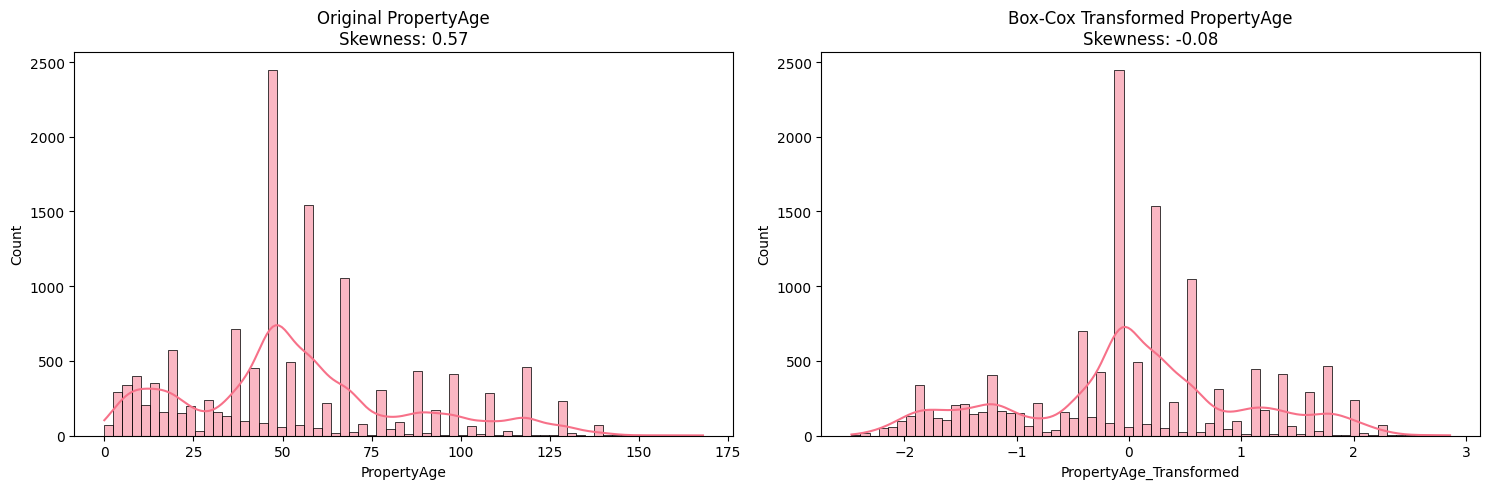

In [74]:
def property_age_transform(df):
    """
    Apply Box-Cox transformation to PropertyAge column in a DataFrame.
    
    Args:
        df: DataFrame containing a 'PropertyAge' column
    
    Returns:
        DataFrame with added 'PropertyAge_Transformed' column
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Extract the column to transform
    values = pd.to_numeric(df['PropertyAge'], errors='coerce').values
    
    # Handle NaN values
    mask = np.isnan(values)
    if mask.any():
        print(f"Warning: {mask.sum()} NaN values found in PropertyAge data. These will be imputed with median.")
        median_value = np.nanmedian(values)
        values[mask] = median_value
    
    # Add offset if needed to ensure all values are positive
    offset = 0
    if (values <= 0).any():
        offset = abs(values.min()) + 1
    values_offset = values + offset
    # Store offset in global dictionary
    boxcox_store["propertyage_offset"] = offset

    # Initialize PowerTransformer
    pt = PowerTransformer(method="box-cox")

    # Apply transformation
    transformed = pt.fit_transform(values_offset.reshape(-1, 1)).flatten()

    # Store lambda value and the transformer in global dictionary
    boxcox_store["propertyage_lambda"] = pt.lambdas_[0]
    boxcox_store["propertyage_transformer"] = pt  # Store the transformer object directly
    
    # Add transformed column to the DataFrame
    df_copy['PropertyAge_Transformed'] = transformed
    
    return df_copy

print("\n6. Transforming other numerical variables")
if 'PropertyAge' in df.columns and abs(df['PropertyAge'].skew()) > 0.5:
    property_age_transformer = register_transformer('propertyage_boxcox', property_age_transform)
    df = property_age_transformer.transform(df)
    log('propertyage_lambda', boxcox_store)
    plot_transformation(df, 'PropertyAge', 'PropertyAge_Transformed', 'PropertyAge')


In [75]:
# Decide which columns to keep (original vs transformed)
print("\nDeciding which columns to keep (original vs transformed)...")

# Calculate skewness before and after transformation
skewness_comparison = []
for col in df.columns:
    if col.endswith('_Transformed') and col.replace('_Transformed', '') in df.columns:
        original_col = col.replace('_Transformed', '')
        original_skew = df[original_col].skew()
        transformed_skew = df[col].skew()
        improvement = abs(original_skew) - abs(transformed_skew)
        skewness_comparison.append({
            'Original Column': original_col,
            'Original Skewness': original_skew,
            'Transformed Column': col,
            'Transformed Skewness': transformed_skew,
            'Improvement': improvement
        })
        
# Display skewness comparison
skewness_df = pd.DataFrame(skewness_comparison).sort_values('Improvement', ascending=False)
print("\nSkewness comparison (before vs after transformation):")
print(skewness_df)


Deciding which columns to keep (original vs transformed)...

Skewness comparison (before vs after transformation):
  Original Column  Original Skewness        Transformed Column  \
1        Landsize          96.204373      Landsize_Transformed   
0           Price           2.142266         Price_Transformed   
3        Distance           1.654172      Distance_Transformed   
6             Car           1.357555           Car_Transformed   
5        Bathroom           1.296879      Bathroom_Transformed   
2    BuildingArea           0.997502  BuildingArea_Transformed   
7     PropertyAge           0.572804   PropertyAge_Transformed   
4           Rooms           0.351395         Rooms_Transformed   

   Transformed Skewness  Improvement  
1             -0.046175    96.158198  
0              0.001034     2.141231  
3              0.024754     1.629418  
6              0.034935     1.322621  
5              0.310069     0.986810  
2              0.112522     0.884980  
7             -0

In [76]:
boxcox_store

{'price_offset': 0,
 'price_lambda': -0.10114682056711606,
 'price_transformer': PowerTransformer(method='box-cox'),
 'landsize_offset': 0,
 'landsize_lambda': -0.09528761136237872,
 'landsize_transformer': PowerTransformer(method='box-cox'),
 'building_area_offset': 0,
 'building_area_lambda': 0.4816026380444045,
 'building_area_transformer': PowerTransformer(method='box-cox'),
 'distance_offset': 0.1,
 'distance_lambda': 0.3018731090736966,
 'distance_transformer': PowerTransformer(method='box-cox'),
 'rooms_offset': 0,
 'rooms_lambda': 0.7154934162886951,
 'rooms_transformer': PowerTransformer(method='box-cox'),
 'bathroom_offset': 0,
 'bathroom_lambda': -1.2592958766084392,
 'bathroom_transformer': PowerTransformer(method='box-cox'),
 'car_offset': 1.0,
 'car_lambda': 0.29620337364927807,
 'car_transformer': PowerTransformer(method='box-cox'),
 'propertyage_offset': 1.0,
 'propertyage_lambda': 0.5960720455466526,
 'propertyage_transformer': PowerTransformer(method='box-cox')}

#### 5. Preprocessing Pipeline Implementation

- Create a preprocessing pipeline with ability to process new data consistently

In [77]:
import pandas as pd
import traceback
import sys

def apply_transformers_with_error_handling(df, transformers):
    """
    Apply each transformer sequentially to the DataFrame and catch any errors.
    
    Args:
        df: Input DataFrame
        transformers: Dictionary of transformer name to transformer object
    
    Returns:
        Transformed DataFrame or None if error occurred
    """
    df_transformed = df.copy()
    
    for name, transformer in transformers.items():
        try:
            print(f"Applying transformer: {name}")
            df_transformed = transformer.fit_transform(df_transformed)
            print(f"✓ Successfully applied {name}")
        except Exception as e:
            print(f"\n❌ ERROR in transformer: {name}")
            print(f"Error type: {type(e).__name__}")
            print(f"Error message: {str(e)}")
            print("\nFull stack trace:")
            traceback.print_exc(file=sys.stdout)
            print(f"\nDataFrame state before failing transformer:")
            print(f"Shape: {df_transformed.shape}")
            display(df_transformed.head())
            return None
    
    return df_transformed

# Load your data
df_new = pd.read_csv("Datasets/01_Melbourne_Residential.csv")

# Apply transformers with error handling
result_df = apply_transformers_with_error_handling(df_new, transformers)

if result_df is not None:
    print("\nAll transformers applied successfully!")
    print(f"Final DataFrame shape: {result_df.shape}")
    display(result_df.head())
    display(df.head())

Applying transformer: remove_columns
✓ Successfully applied remove_columns
Applying transformer: fix_column_names
✓ Successfully applied fix_column_names
Applying transformer: fix_building_area
BuildingArea NaNs before imputation: 6450
✓ Successfully applied fix_building_area
Applying transformer: car_imputer
Car NaNs before imputation: 62
Car NaNs after imputation: 0
✓ Successfully applied car_imputer
Applying transformer: bathroom_imputer
✓ Successfully applied bathroom_imputer
Applying transformer: year_built_imputer
YearBuilt NaNs before imputation: 5375
YearBuilt NaNs after imputation: 0
✓ Successfully applied year_built_imputer
Applying transformer: create_missing_indicators
✓ Successfully applied create_missing_indicators
Applying transformer: drop_missing_indicators
✓ Successfully applied drop_missing_indicators
Applying transformer: year_built_corrector
✓ Successfully applied year_built_corrector
Applying transformer: land_size_handler
✓ Successfully applied land_size_handler


Address  Rooms    Price      Date  Distance  Postcode  Bathroom  \
0     154 Halsey Rd      3   840000  3/9/2023      13.5      3042         2   
1    105 Kerferd Rd      2  1275000  3/9/2023       3.3      3206         1   
2  85 Richardson St      2  1455000  3/9/2023       3.3      3206         1   
3        6 Smith St      4  2000000  3/9/2023       6.4      3078         2   
4   5/6 Yarralea St      3  1110000  3/9/2023       6.4      3078         2   

   Car  Landsize  BuildingArea  LandSizeNotOwned  PropertyAge  DistanceToCBD  \
0  1.0       303         225.0                 0          2.0       0.134160   
1  0.0       120          82.0                 0        118.0       0.029939   
2  0.0       159          96.0                 0        118.0       0.029829   
3  4.0       853         263.0                 0         88.0       0.080323   
4  2.0       208         130.0                 0          5.0       0.073209   

   Direction_E  Direction_N  Direction_S  Direction_W  PropType_House  \
0        False         True        False        False           False   
1        False        False         True        False            True   
2        False        False         True        False            True   
3         True        False        False        False            True   
4         True        False        False        False            True   

   PropType_Townhouse  PropType_Unit/Apartment  Method_PI  Method_S  \
0                True                    False       True     False   
1               False                    False      False      True   
2               False                    False      False      True   
3               False                    False      False      True   
4               False                    False      False      True   

   Method_SA  Method_SP  Method_VB  Suburb_PriceRank  Seller_Barry  \
0      False      False      False          0.386581         False   
1      False      False      False          0.990415         False   
2      False      False      False          0.990415         False   
3      False      False      False          0.904153         False   
4      False      False      False          0.904153         False   

   Seller_Biggin  Seller_Brad  Seller_Buxton  Seller_Fletchers  Seller_Gary  \
0          False        False          False             False        False   
1          False        False          False             False        False   
2          False        False          False             False        False   
3          False        False          False             False        False   
4          False        False          False             False        False   

   Seller_Greg  Seller_Harcourts  Seller_Hodges  Seller_Jas  Seller_Jellis  \
0        False             False          False       False          False   
1        False             False          False       False          False   
2        False             False          False       False          False   
3        False             False          False       False          False   
4        False             False          False       False           True   

   Seller_Kay  Seller_Love  Seller_Marshall  Seller_McGrath  Seller_Miles  \
0       False        False            False           False         False   
1       False        False            False           False         False   
2       False        False            False           False         False   
3       False        False            False           False         False   
4       False        False            False           False         False   

   Seller_Nelson  Seller_Noel  Seller_Other  Seller_RT  Seller_Raine  \
0           True        False         False      False         False   
1          False        False         False      False         False   
2          False        False          True      False         False   
3          False        False          True      False         False   
4 

Address  Rooms    Price      Date  Distance  Postcode  Bathroom  \
0     154 Halsey Rd      3   840000  3/9/2023      13.5      3042         2   
1    105 Kerferd Rd      2  1275000  3/9/2023       3.3      3206         1   
2  85 Richardson St      2  1455000  3/9/2023       3.3      3206         1   
3        6 Smith St      4  2000000  3/9/2023       6.4      3078         2   
4   5/6 Yarralea St      3  1110000  3/9/2023       6.4      3078         2   

   Car  Landsize  BuildingArea  LandSizeNotOwned  PropertyAge  DistanceToCBD  \
0  1.0       303         225.0                 0          2.0       0.134160   
1  0.0       120          82.0                 0        118.0       0.029939   
2  0.0       159          96.0                 0        118.0       0.029829   
3  4.0       853         263.0                 0         88.0       0.080323   
4  2.0       208         130.0                 0          5.0       0.073209   

   Direction_E  Direction_N  Direction_S  Direction_W  PropType_House  \
0        False         True        False        False           False   
1        False        False         True        False            True   
2        False        False         True        False            True   
3         True        False        False        False            True   
4         True        False        False        False            True   

   PropType_Townhouse  PropType_Unit/Apartment  Method_PI  Method_S  \
0                True                    False       True     False   
1               False                    False      False      True   
2               False                    False      False      True   
3               False                    False      False      True   
4               False                    False      False      True   

   Method_SA  Method_SP  Method_VB  Suburb_PriceRank  Seller_Barry  \
0      False      False      False          0.386581         False   
1      False      False      False          0.990415         False   
2      False      False      False          0.990415         False   
3      False      False      False          0.904153         False   
4      False      False      False          0.904153         False   

   Seller_Biggin  Seller_Brad  Seller_Buxton  Seller_Fletchers  Seller_Gary  \
0          False        False          False             False        False   
1          False        False          False             False        False   
2          False        False          False             False        False   
3          False        False          False             False        False   
4          False        False          False             False        False   

   Seller_Greg  Seller_Harcourts  Seller_Hodges  Seller_Jas  Seller_Jellis  \
0        False             False          False       False          False   
1        False             False          False       False          False   
2        False             False          False       False          False   
3        False             False          False       False          False   
4        False             False          False       False           True   

   Seller_Kay  Seller_Love  Seller_Marshall  Seller_McGrath  Seller_Miles  \
0       False        False            False           False         False   
1       False        False            False           False         False   
2       False        False            False           False         False   
3       False        False            False           False         False   
4       False        False            False           False         False   

   Seller_Nelson  Seller_Noel  Seller_Other  Seller_RT  Seller_Raine  \
0           True        False         False      False         False   
1          False        False         False      False         False   
2          False        False          True      False         False   
3          False        False          True      False         False   
4 

In [78]:
import pickle

# Convert your transformer dictionary to a Pipeline
def create_pipeline_from_transformers(transformers_dict):
    """
    Convert a dictionary of transformers to a scikit-learn Pipeline
    
    Args:
        transformers_dict: Dictionary of transformer name to transformer object
    
    Returns:
        sklearn.pipeline.Pipeline object
    """
    steps = [(name, transformer) for name, transformer in transformers_dict.items()]
    return Pipeline(steps)
# Create a pipeline
pipeline = create_pipeline_from_transformers(transformers)

# Load data
df_new_new = pd.read_csv("Datasets/01_Melbourne_Residential.csv")

# Apply transformations
result_df_new = pipeline.fit_transform(df_new_new)

if result_df is not None:
    print("\nAll transformations applied successfully!")
    print(f"Final DataFrame shape: {result_df_new.shape}")
    display(result_df_new.head())
    
    # Save the pipeline
    with open("melbourne_pipeline.pkl", "wb") as f:
        try:
            pickle.dump(pipeline, f)
            print("Pipeline successfully saved!")
        except Exception as e:
            print(f"Error saving pipeline: {str(e)}")
            
            # Try to identify which transformer is causing the issue
            for name, transformer in transformers.items():
                try:
                    with open(f"test_{name}.pkl", "wb") as test_f:
                        pickle.dump(transformer, test_f)
                except Exception as e:
                    print(f"Transformer '{name}' is not picklable: {str(e)}")

BuildingArea NaNs before imputation: 6450
Car NaNs before imputation: 62
Car NaNs after imputation: 0
YearBuilt NaNs before imputation: 5375
YearBuilt NaNs after imputation: 0

All transformations applied successfully!
Final DataFrame shape: (13423, 63)


Address  Rooms    Price      Date  Distance  Postcode  Bathroom  \
0     154 Halsey Rd      3   840000  3/9/2023      13.5      3042         2   
1    105 Kerferd Rd      2  1275000  3/9/2023       3.3      3206         1   
2  85 Richardson St      2  1455000  3/9/2023       3.3      3206         1   
3        6 Smith St      4  2000000  3/9/2023       6.4      3078         2   
4   5/6 Yarralea St      3  1110000  3/9/2023       6.4      3078         2   

   Car  Landsize  BuildingArea  LandSizeNotOwned  PropertyAge  DistanceToCBD  \
0  1.0       303         225.0                 0          2.0       0.134160   
1  0.0       120          82.0                 0        118.0       0.029939   
2  0.0       159          96.0                 0        118.0       0.029829   
3  4.0       853         263.0                 0         88.0       0.080323   
4  2.0       208         130.0                 0          5.0       0.073209   

   Direction_E  Direction_N  Direction_S  Direction_W  PropType_House  \
0        False         True        False        False           False   
1        False        False         True        False            True   
2        False        False         True        False            True   
3         True        False        False        False            True   
4         True        False        False        False            True   

   PropType_Townhouse  PropType_Unit/Apartment  Method_PI  Method_S  \
0                True                    False       True     False   
1               False                    False      False      True   
2               False                    False      False      True   
3               False                    False      False      True   
4               False                    False      False      True   

   Method_SA  Method_SP  Method_VB  Suburb_PriceRank  Seller_Barry  \
0      False      False      False          0.386581         False   
1      False      False      False          0.990415         False   
2      False      False      False          0.990415         False   
3      False      False      False          0.904153         False   
4      False      False      False          0.904153         False   

   Seller_Biggin  Seller_Brad  Seller_Buxton  Seller_Fletchers  Seller_Gary  \
0          False        False          False             False        False   
1          False        False          False             False        False   
2          False        False          False             False        False   
3          False        False          False             False        False   
4          False        False          False             False        False   

   Seller_Greg  Seller_Harcourts  Seller_Hodges  Seller_Jas  Seller_Jellis  \
0        False             False          False       False          False   
1        False             False          False       False          False   
2        False             False          False       False          False   
3        False             False          False       False          False   
4        False             False          False       False           True   

   Seller_Kay  Seller_Love  Seller_Marshall  Seller_McGrath  Seller_Miles  \
0       False        False            False           False         False   
1       False        False            False           False         False   
2       False        False            False           False         False   
3       False        False            False           False         False   
4       False        False            False           False         False   

   Seller_Nelson  Seller_Noel  Seller_Other  Seller_RT  Seller_Raine  \
0           True        False         False      False         False   
1          False        False         False      False         False   
2          False        False          True      False         False   
3          False        False          True      False         False   
4 

Pipeline successfully saved!


#### 5. Data Splitting Strategy

- **Stratified Time-Based Split**:
  - Train on earlier sales, validate on more recent sales
  - Ensures model generalizes to future market conditions

In [79]:
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# First, let's convert the Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')  # Assuming day/month/year format

# Sort the dataframe by date
df_sorted = df.sort_values('Date')

# Let's see the date range in our dataset
print(f"Date range: {df_sorted['Date'].min()} to {df_sorted['Date'].max()}")

Date range: 2023-01-28 00:00:00 to 2024-09-23 00:00:00


In [80]:
# Create price bins for stratification (adjust the number of bins as needed)
df['price_bin'] = pd.qcut(df['Price'], q=5, labels=False)

# Create a combined stratification variable
if 'PropertyType' in df.columns:
    df['strat_var'] = df['PropertyType'].astype(str) + '_' + df['price_bin'].astype(str)
else:
    df['strat_var'] = df['price_bin']

# Create time periods (e.g., months or quarters)
df['time_period'] = pd.qcut(df['Date'].astype(int), q=10, labels=False)

# Define  feature columns and target
feature_cols = [col for col in df.columns if col not in ['Price', 'Price_Transformed', 'time_period', 'price_bin', 'strat_var', 'Address', 'Date', 'Postcode', 'Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'PropertyAge', 'DistanceToCBD']]
target = 'Price_Transformed' if 'Price_Transformed' in df.columns else 'Price'

# Initialize empty lists for train and validation indices
train_indices = []
val_indices = []

# For each time period, perform stratified sampling
for period in df['time_period'].unique():
    period_df = df[df['time_period'] == period]
    period_indices = period_df.index
    
    # If the period has enough samples for stratification
    if len(period_df['strat_var'].unique()) > 1 and len(period_df) >= 10:
        train_idx, val_idx = train_test_split(
            period_indices,
            test_size=0.2,
            random_state=42,
            stratify=period_df['strat_var']
        )
    else:
        # For small periods or when stratification isn't possible, just do a regular split
        train_idx, val_idx = train_test_split(
            period_indices,
            test_size=0.2,
            random_state=42
        )
    
    train_indices.extend(train_idx)
    val_indices.extend(val_idx)
log("test_size", 0.2)
log("random_state", 42)
log("stratification_method", "price_bin_and_property_type")
log("time_periods", 10)
# Create the final datasets
train_df = df.loc[train_indices].copy()
val_df = df.loc[val_indices].copy()


'test_size: 0.2'

'random_state: 42'

'stratification_method: price_bin_and_property_type'

'time_periods: 10'

In [81]:
# Create the final datasets
X_train = train_df[feature_cols]
X_val = val_df[feature_cols]
y_train = train_df[target]
y_val = val_df[target]

log("training_set_size", len(train_df))
log("validation_set_size", len(val_df))
log("training_date_min", train_df['Date'].min().strftime('%Y-%m-%d'))
log("training_date_max", train_df['Date'].max().strftime('%Y-%m-%d'))
log("validation_date_min", val_df['Date'].min().strftime('%Y-%m-%d'))
log("validation_date_max", val_df['Date'].max().strftime('%Y-%m-%d'))

'training_set_size: 10735'

'validation_set_size: 2688'

'training_date_min: 2023-01-28'

'training_date_max: 2024-09-23'

'validation_date_min: 2023-02-04'

'validation_date_max: 2024-09-23'

In [82]:
# Check stratification
print("\nTraining set price bin distribution:")
print(df.loc[train_indices, 'price_bin'].value_counts(normalize=True))
print("\nValidation set price bin distribution:")
print(df.loc[val_indices, 'price_bin'].value_counts(normalize=True))

if 'PropertyType' in df.columns:
    print("\nTraining set property type distribution:")
    print(df.loc[train_indices, 'PropertyType'].value_counts(normalize=True))
    print("\nValidation set property type distribution:")
    print(df.loc[val_indices, 'PropertyType'].value_counts(normalize=True))

# Optional: Check if the time ordering is preserved
train_dates = df.loc[train_indices, 'Date']
val_dates = df.loc[val_indices, 'Date']

val_dates_after_train = (val_dates > train_dates.max()).mean() * 100
train_dates_before_val = (train_dates < val_dates.min()).mean() * 100
log("pct_val_dates_after_max_train", f"{val_dates_after_train:.2f}%")
log("pct_train_dates_before_min_val", f"{train_dates_before_val:.2f}%")


Training set price bin distribution:
price_bin
0    0.204751
1    0.201770
3    0.200093
4    0.199534
2    0.193852
Name: proportion, dtype: float64

Validation set price bin distribution:
price_bin
0    0.204613
1    0.202381
3    0.200149
4    0.199777
2    0.193080
Name: proportion, dtype: float64


'pct_val_dates_after_max_train: 0.00%'

'pct_train_dates_before_min_val: 0.02%'

In [83]:
# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on validation set
val_predictions = model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, val_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, val_predictions)

print(mlflow.log_metric("validation_rmse", rmse))
print(mlflow.log_metric("validation_r2", r2))
print(mlflow.log_metric("validation_mse", mse))

None
None
None


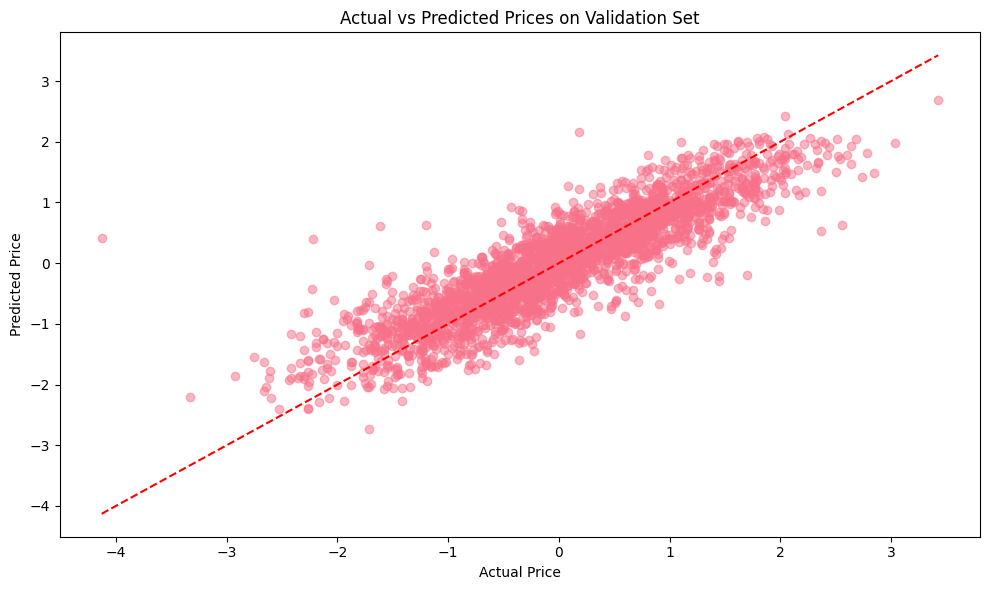

In [84]:
# Visualize predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_val, val_predictions, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices on Validation Set')
plt.tight_layout()
plt.savefig("actual_vs_predicted.png")
mlflow.log_artifact("actual_vs_predicted.png")

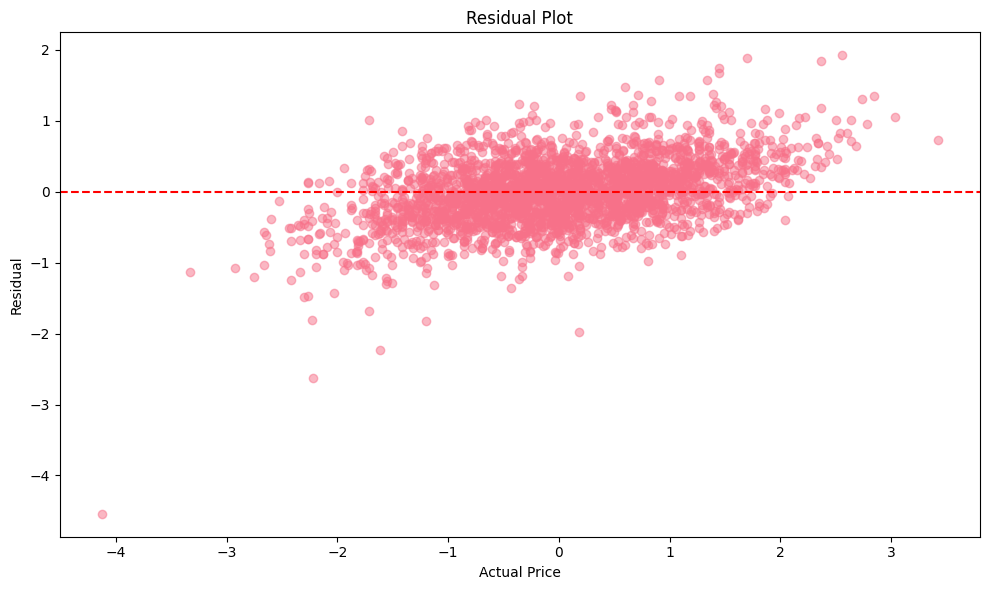

In [85]:
# Plot residuals
residuals = y_val - val_predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_val, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.tight_layout()
plt.savefig("residuals.png")
mlflow.log_artifact("residuals.png")

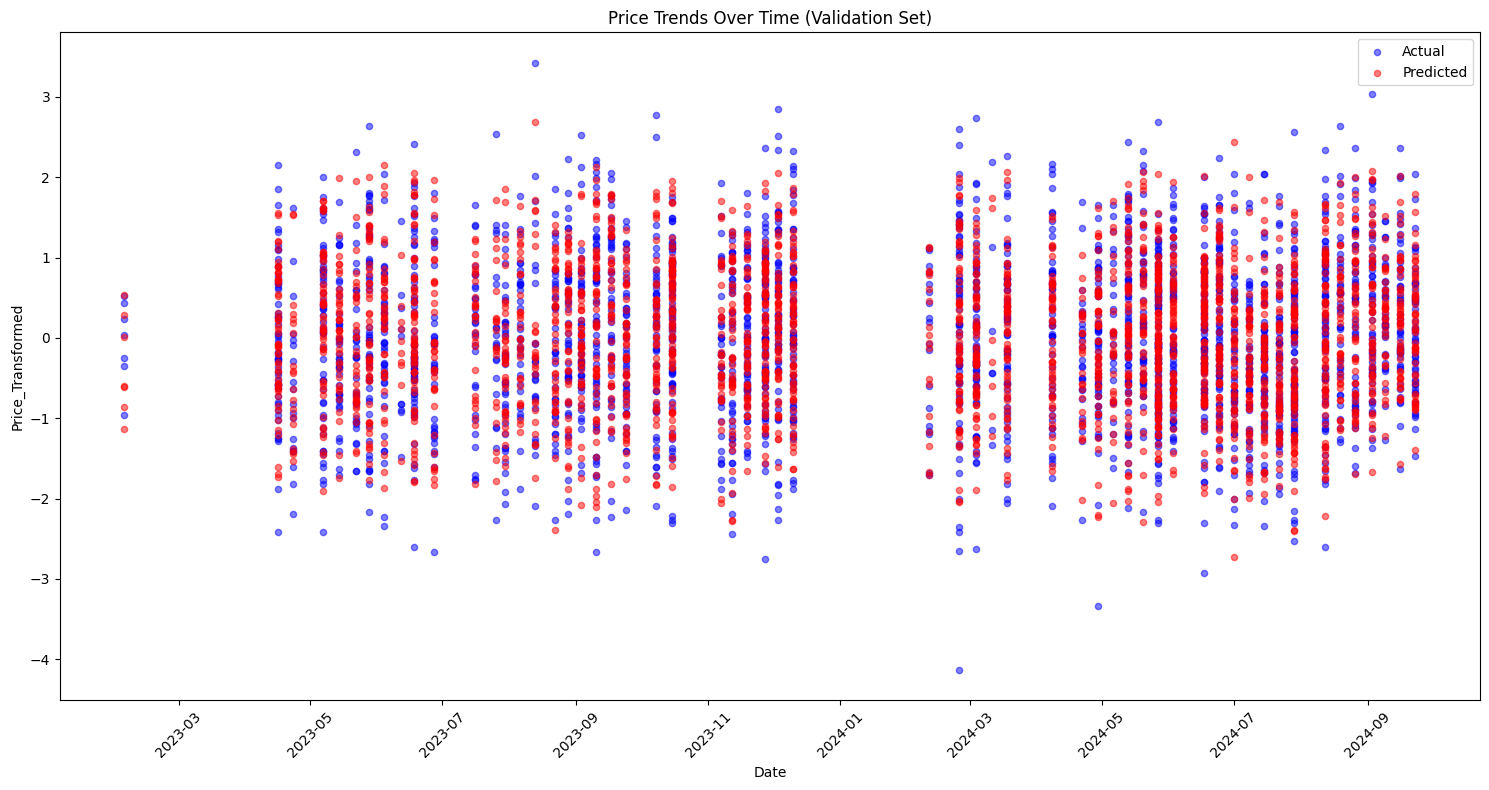

In [86]:
# Plot predictions over time
plt.figure(figsize=(15, 8))
plt.scatter(val_df['Date'], y_val, alpha=0.5, s=20, label='Actual', color='blue')
plt.scatter(val_df['Date'], val_predictions, alpha=0.5, s=20, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Price_Transformed')
plt.title('Price Trends Over Time (Validation Set)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("time_series.png")
mlflow.log_artifact("time_series.png")

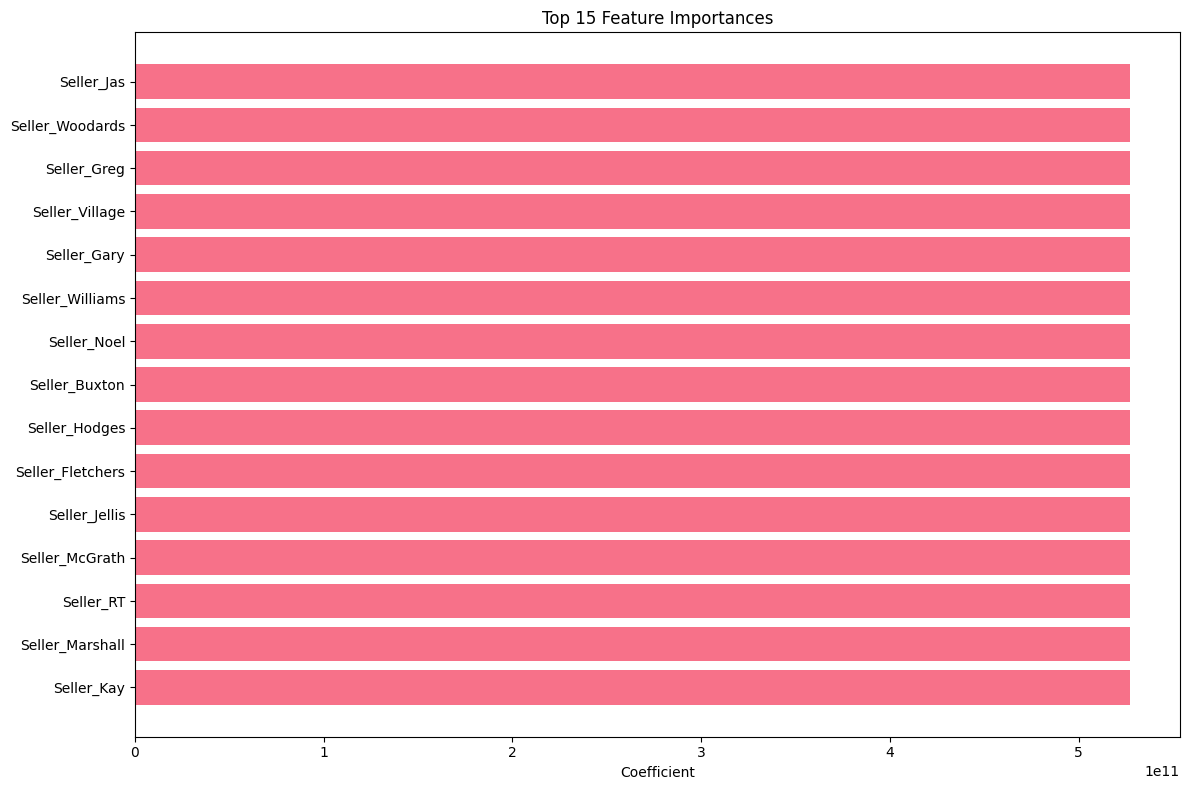

In [87]:
# Feature importance
coefficients = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_
})
coefficients = coefficients.sort_values('Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(coefficients['Feature'][:15], coefficients['Coefficient'][:15])
plt.xlabel('Coefficient')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.savefig("feature_importance.png")
mlflow.log_artifact("feature_importance.png")

### Sub task 2 - Model Development with PyCaret

In [88]:
from pycaret.regression import *

# Prepare data for PyCaret
# Combine features and target into a single dataframe for training
train_data = train_df[feature_cols + [target]].copy()
val_data = val_df[feature_cols + [target]].copy()

# Log dataset information
log("pycaret_train_samples", len(train_data))
log("pycaret_val_samples", len(val_data))
log("pycaret_features", len(feature_cols))
log("pycaret_train_cols", list(train_data))

'pycaret_train_samples: 10735'

'pycaret_val_samples: 2688'

'pycaret_features: 50'

"pycaret_train_cols: ['LandSizeNotOwned', 'Direction_E', 'Direction_N', 'Direction_S', 'Direction_W', 'PropType_House', 'PropType_Townhouse', 'PropType_Unit/Apartment', 'Method_PI', 'Method_S', 'Method_SA', 'Method_SP', 'Method_VB', 'Suburb_PriceRank', 'Seller_Barry', 'Seller_Biggin', 'Seller_Brad', 'Seller_Buxton', 'Seller_Fletchers', 'Seller_Gary', 'Seller_Greg', 'Seller_Harcourts', 'Seller_Hodges', 'Seller_Jas', 'Seller_Jellis', 'Seller_Kay', 'Seller_Love', 'Seller_Marshall', 'Seller_McGrath', 'Seller_Miles', 'Seller_Nelson', 'Seller_Noel', 'Seller_Other', 'Seller_RT', 'Seller_Raine', 'Seller_Ray', 'Seller_Stockdale', 'Seller_Sweeney', 'Seller_Village', 'Seller_Williams', 'Seller_Woodards', 'Seller_YPA', 'Seller_hockingstuart', 'Landsize_Transformed', 'BuildingArea_Transformed', 'Distance_Transformed', 'Rooms_Transformed', 'Bathroom_Transformed', 'Car_Transformed', 'PropertyAge_Transformed', 'Price_Transformed']"

In [89]:
# Initialize PyCaret setup with MLflow tracking
# Note: PyCaret automatically logs to MLflow when log_experiment=True
reg_setup = setup(
    data=train_data,
    target=target,
    session_id=42,
    log_experiment=True,
    experiment_name="Housing Price Prediction",
    log_plots=True,
    verbose=True,
    ignore_features=['time_period', 'price_bin', 'strat_var'] if any(col in train_data.columns for col in ['time_period', 'price_bin', 'strat_var']) else None,
    fold_strategy='timeseries',  # Use time series cross-validation
    data_split_shuffle=False,
    fold_shuffle=False,
    fold=5
)

# Log setup parameters
log("pycaret_normalize", True)
log("pycaret_transformation", True)
log("pycaret_fold_strategy", "timeseries")
log("pycaret_folds", 5)

'pycaret_normalize: True'

'pycaret_transformation: True'

'pycaret_fold_strategy: timeseries'

'pycaret_folds: 5'

In [90]:
# Compare models and get the best models table
best_models = compare_models(
    n_select=5,  # Select top 5 models
    sort='RMSE',  # Sort by RMSE
    verbose=True
)

# If best_models is a single model (not a list)
if not isinstance(best_models, list):
    best_models = [best_models]


Tuning CatBoostRegressor...


'top_model_1: CatBoostRegressor'

Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).



Tuning LGBMRegressor...


'top_model_2: LGBMRegressor'

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8614491872554462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8614491872554462
[LightGBM] [Warning] bagging_fraction is set=0.8968680872070618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8968680872070618
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7490630380097805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7490630380097805
[LightGBM] [Warning] bagging_fraction is set=0.5685352310069492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5685352310069492
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8614491872554462, colsample


Tuning XGBRegressor...


'top_model_3: XGBRegressor'

Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).



Tuning GradientBoostingRegressor...


'top_model_4: GradientBoostingRegressor'


Tuning RandomForestRegressor...


'top_model_5: RandomForestRegressor'

Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


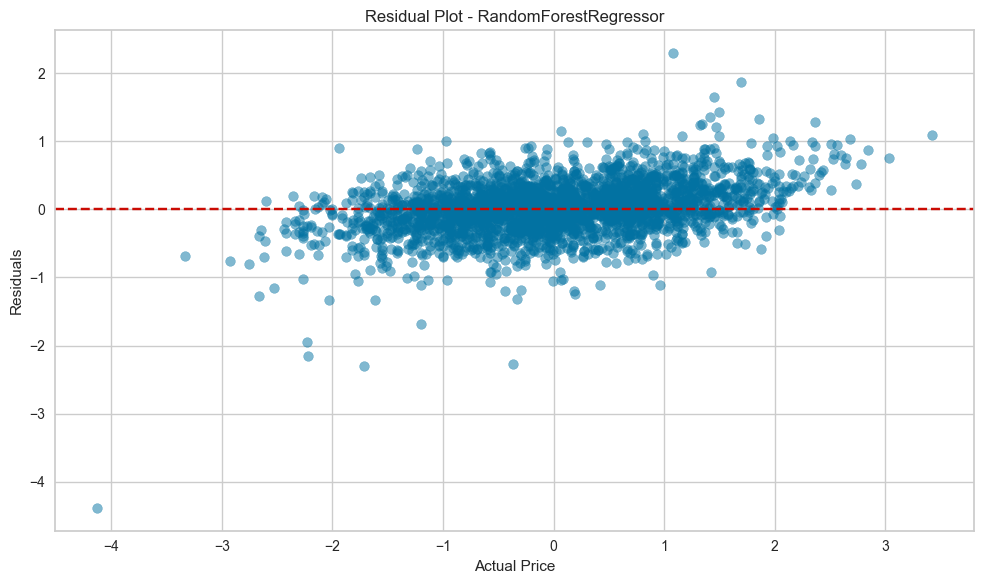

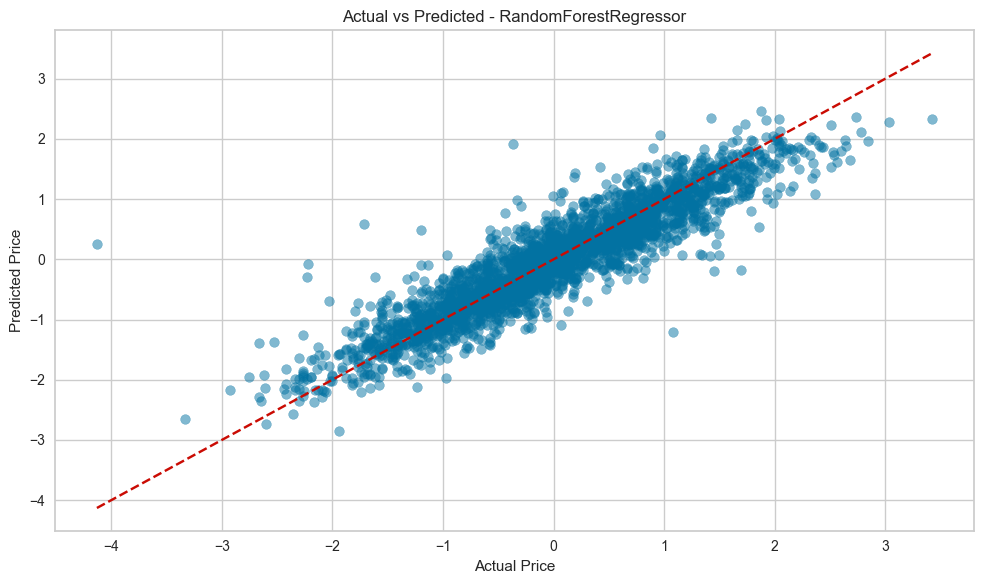

In [91]:
# Tune each of the top models
tuned_models = []
for i, model in enumerate(best_models):   
    model_name = model.__class__.__name__ 
    print(f"\nTuning {model_name}...")    
                                          
    # Log the base model name             
    log(f"top_model_{i+1}", model_name)   
    
    # Tune the model
    tuned_model = tune_model(
        model,
        optimize='RMSE',
        n_iter=10,
        search_library='optuna',
    )
    
    tuned_models.append(tuned_model)
    
    # Evaluate on validation set
    pred_holdout = predict_model(tuned_model, data=val_data)
    val_rmse = np.sqrt(mean_squared_error(pred_holdout[target], pred_holdout['prediction_label']))
    val_r2 = r2_score(pred_holdout[target], pred_holdout['prediction_label'])
    
    # Log validation metrics
    mlflow.log_metric(f"val_rmse_{model_name}", val_rmse)
    mlflow.log_metric(f"val_r2_{model_name}", val_r2)
    
    # Create and log residual plot
    plt.figure(figsize=(10, 6))
    residuals = pred_holdout[target] - pred_holdout['prediction_label']
    plt.scatter(pred_holdout[target], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Actual Price')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {model_name}')
    plt.tight_layout()
    plt.savefig(f"residuals_{model_name}.png")
    mlflow.log_artifact(f"residuals_{model_name}.png")
    
    # Create and log actual vs predicted plot
    plt.figure(figsize=(10, 6))
    plt.scatter(pred_holdout[target], pred_holdout['prediction_label'], alpha=0.5)
    plt.plot([pred_holdout[target].min(), pred_holdout[target].max()], 
             [pred_holdout[target].min(), pred_holdout[target].max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.tight_layout()
    plt.savefig(f"actual_vs_predicted_{model_name}.png")
    mlflow.log_artifact(f"actual_vs_predicted_{model_name}.png")

In [92]:
# Select the best model based on validation RMSE
best_idx = np.argmin([
    np.sqrt(mean_squared_error(
        predict_model(model, data=val_data)[target], 
        predict_model(model, data=val_data)['prediction_label']
    )) 
    for model in tuned_models
])

best_model = tuned_models[best_idx]
best_model_name = best_model.__class__.__name__ 

In [93]:
# Log the final best model
log("best_model", best_model_name)
final_model = finalize_model(best_model)


# Save the model with PyCaret (this also logs to MLflow)
save_model(final_model, 'housing_price_prediction')

model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
registered_model = mlflow.register_model(
    model_uri=model_uri,
    name="housing_price_prediction"
)

'best_model: CatBoostRegressor'

Transformation Pipeline and Model Successfully Saved


Registered model 'housing_price_prediction' already exists. Creating a new version of this model...
Created version '10' of model 'housing_price_prediction'.


In [106]:
def predict(input_data):
    """
    Predict the original property price based on input data.

    Args:
        input_data: Dictionary or tuple of dictionaries containing property features
        
    Returns:
        Predicted property price(s) in original scale ($)
    """
    # Convert input data to DataFrame
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    elif isinstance(input_data, tuple):
        input_df = pd.DataFrame(list(input_data))
    else:
        input_df = pd.DataFrame(input_data)
    
    # Apply necessary preprocessing to match the model's expected features
    processed_df = preprocess_for_prediction(input_df)
    
    # Generate predictions using the PyCaret model
    prediction_df = predict_model(final_model, data=processed_df)
    
    # Extract the transformed predictions
    predicted_transformed_values = prediction_df["prediction_label"].values
    print("predicted_transformed", predicted_transformed_values)
    
    # Inverse-transform to get original price
    original_prices = [inverse_transform_price(val) for val in predicted_transformed_values]
    
    # Return single value or list based on input
    if len(original_prices) == 1:
        return original_prices[0]
    else:
        return original_prices


def preprocess_for_prediction(df):
    """
    Apply all necessary preprocessing steps to prepare data for prediction.

    Args:
        df: DataFrame with raw input features
        
    Returns:
        DataFrame with all features required by the model
    """
    processed = df.copy()
    
    # 1. Property Type encoding
    if "Type" in processed.columns:
        # Map text property types to codes if needed
        type_mapping = {"House": "h", "Unit/Apartment": "u", "Townhouse": "t"}
        if not processed["Type"].isin(["h", "u", "t"]).all():
            processed["Type"] = processed["Type"].map(lambda x: type_mapping.get(x, x))
        
        # Create one-hot encoded features
        processed["PropType_House"] = (processed["Type"] == "h").astype(int)
        processed["PropType_Townhouse"] = (processed["Type"] == "t").astype(int)
        processed["PropType_Unit/Apartment"] = (processed["Type"] == "u").astype(int)
        processed = processed.drop("Type", axis=1)
    
    # 2. Method encoding
    if "Method" in processed.columns:
        # Create one-hot encoded Method features
        method_columns = ["Method_PI", "Method_S", "Method_SA", "Method_SP", "Method_VB"]
        for col in method_columns:
            method_code = col.split("_")[1]
            processed[col] = (processed["Method"] == method_code).astype(int)
        processed = processed.drop("Method", axis=1)
    
    # 3. Suburb encoding
    if "Suburb" in processed.columns:
        # Use the suburb_to_rank_dict from the transformer
        suburb_ranks = transform_suburb.encoder.suburb_to_rank_dict
        processed["Suburb_PriceRank"] = processed["Suburb"].map(
            suburb_ranks, na_action='ignore')
        # Fill missing values with median rank
        if processed["Suburb_PriceRank"].isna().any():
            median_rank = np.median(list(suburb_ranks.values()))
            processed["Suburb_PriceRank"] = processed["Suburb_PriceRank"].fillna(median_rank)
        processed = processed.drop("Suburb", axis=1)
    
    # 4. Seller encoding
    if "Seller" in processed.columns:
        # Create one-hot encoded Seller features
        seller_cols = [c for c in df.columns if c.startswith("Seller_")]
        common_sellers = ["Barry", "Biggin", "Brad", "Buxton", "Fletchers", "Gary", 
                         "Greg", "Harcourts", "Hodges", "Jas", "Jellis", "Kay", 
                         "Love", "Marshall", "McGrath", "Miles", "Nelson", "Noel", 
                         "RT", "Raine", "Ray", "Stockdale", "Sweeney", "Village", 
                         "Williams", "Woodards", "YPA", "hockingstuart"]
        
        # Initialize all seller columns to 0
        for seller in common_sellers:
            processed[f"Seller_{seller}"] = 0
        
        # Set the appropriate column to 1 or "Other" if not in common sellers
        for idx, seller in enumerate(processed["Seller"]):
            if seller in common_sellers:
                processed.loc[idx, f"Seller_{seller}"] = 1
            else:
                processed.loc[idx, "Seller_Other"] = 1
                
        processed = processed.drop("Seller", axis=1)
    
    # 5. Direction features if needed
    if "Direction" in processed.columns:
        direction_cols = ["Direction_N", "Direction_S", "Direction_E", "Direction_W"]
        for dir_col in direction_cols:
            dir_code = dir_col.split("_")[1]
            processed[dir_col] = (processed["Direction"] == dir_code).astype(int)
        processed = processed.drop("Direction", axis=1)
    
    # 6. Numerical transformations
    # Apply Box-Cox transformations to numeric features
    if "Landsize" in processed.columns:
        processed["Landsize_Transformed"] = box_cox_transform(
            processed["Landsize"], 
            boxcox_store["landsize_lambda"], 
            boxcox_store.get("landsize_offset", 0)
        )
    
    if "BuildingArea" in processed.columns:
        processed["BuildingArea_Transformed"] = box_cox_transform(
            processed["BuildingArea"], 
            boxcox_store["building_area_lambda"], 
            boxcox_store.get("building_area_offset", 0)
        )
    
    if "Distance" in processed.columns:
        processed["Distance_Transformed"] = box_cox_transform(
            processed["Distance"], 
            boxcox_store["distance_lambda"], 
            boxcox_store.get("distance_offset", 0)
        )
    
    if "Rooms" in processed.columns:
        processed["Rooms_Transformed"] = box_cox_transform(
            processed["Rooms"], 
            boxcox_store["rooms_lambda"], 
            boxcox_store.get("rooms_offset", 0)
        )
    
    if "Bathroom" in processed.columns:
        processed["Bathroom_Transformed"] = box_cox_transform(
            processed["Bathroom"], 
            boxcox_store["bathroom_lambda"], 
            boxcox_store.get("bathroom_offset", 0)
        )
    
    if "Car" in processed.columns:
        processed["Car_Transformed"] = box_cox_transform(
            processed["Car"], 
            boxcox_store["car_lambda"], 
            boxcox_store.get("car_offset", 0)
        )
    
    if "PropertyAge" in processed.columns:
        processed["PropertyAge_Transformed"] = box_cox_transform(
            processed["PropertyAge"], 
            boxcox_store["propertyage_lambda"], 
            boxcox_store.get("propertyage_offset", 0)
        )
    
    # Convert boolean values to integers
    bool_columns = processed.select_dtypes(include=['bool']).columns
    for col in bool_columns:
        processed[col] = processed[col].astype(int)
    
    # 7. Add any missing columns required by the model with default values (0)
    required_columns = ['PropType_House', 'PropType_Townhouse', 'PropType_Unit/Apartment', 
                        'Method_PI', 'Method_S', 'Method_SA', 'Method_SP', 'Method_VB', 
                        'Suburb_PriceRank', 'Seller_Barry', 'Seller_Biggin', 'Seller_Brad', 
                        'Seller_Buxton', 'Seller_Fletchers', 'Seller_Gary', 'Seller_Greg', 
                        'Seller_Harcourts', 'Seller_Hodges', 'Seller_Jas', 'Seller_Jellis', 
                        'Seller_Kay', 'Seller_Love', 'Seller_Marshall', 'Seller_McGrath', 
                        'Seller_Miles', 'Seller_Nelson', 'Seller_Noel', 'Seller_Other', 
                        'Seller_RT', 'Seller_Raine', 'Seller_Ray', 'Seller_Stockdale', 
                        'Seller_Sweeney', 'Seller_Village', 'Seller_Williams', 'Seller_Woodards', 
                        'Seller_YPA', 'Seller_hockingstuart', 'Landsize_Transformed', 
                        'BuildingArea_Transformed', 'Distance_Transformed', 'Rooms_Transformed', 
                        'Bathroom_Transformed', 'Car_Transformed', 'PropertyAge_Transformed']
    
    for col in required_columns:
        if col not in processed.columns:
            processed[col] = 0    
    return processed


def box_cox_transform(values, lambda_val, offset=0):
    """Apply Box-Cox transformation to a series of values"""
    values = pd.to_numeric(values, errors='coerce')
    # Handle NaNs
    values = values.fillna(values.median())

    # Apply offset if needed
    values_offset = values + offset
    
    # Apply transformation
    if abs(lambda_val) < 1e-10:  # lambda is close to zero
        return np.log(values_offset)
    else:
        return ((values_offset ** lambda_val) - 1) / lambda_val


def inverse_transform_price(transformed_value):
    """
    Inverse-transform a price value using the stored PowerTransformer.

    Args:
        transformed_value: Transformed price value
        
    Returns:
        Original price value
    """
    # Get the offset
    offset = boxcox_store.get("price_offset", 0)
    
    # Get the transformer from boxcox_store
    if "price_transformer" in boxcox_store:
        pt = boxcox_store["price_transformer"]
        
        # Reshape for scikit-learn
        value_reshaped = np.array([transformed_value]).reshape(-1, 1)
        
        # Use the transformer's built-in inverse_transform method
        original_with_offset = pt.inverse_transform(value_reshaped)[0][0]
        
        # Remove the offset
        original_price = original_with_offset - offset
        
        return original_price
    else:
        # Fallback to manual implementation if transformer isn't available
        print("Warning: PowerTransformer not found, using fallback method")
        lambda_val = boxcox_store["price_lambda"]
        
        if abs(lambda_val) < 1e-10:  # lambda is close to zero
            x_original = np.exp(transformed_value)
        else:
            x_original = np.power(lambda_val * transformed_value + 1, 1/lambda_val)
        
        return x_original - offset

In [107]:
input_data = (
    {
        "Suburb": "Reservoir",
        "Rooms": 3,
        "Type": "House",
        "Method": "S",
        "Seller": "Ray",
        "Distance": 11.2,
        "Bathroom": 1.0,
        "Car": 2,
        "Landsize": 556.0,
        "BuildingArea": 120.0,
        "PropertyAge": 50,
        "Direction": "N",
        "LandSizeNotOwned": False,
    },
)

predict(input_data)

predicted_transformed [0.27014148]


1052204.5495033467

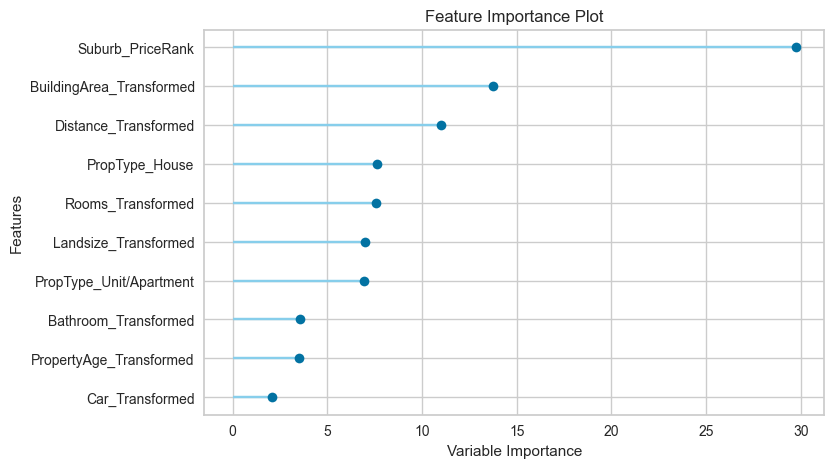

In [96]:
# Feature importance for the best model (if available)
plt.figure(figsize=(12, 8))
importance_fig = plot_model(final_model, plot='feature', save=True)
importance_fig = plot_model(final_model, plot='feature')
mlflow.log_artifact('Feature Importance.png')

In [97]:
# Log the final model's pipeline steps
pipeline_steps = []
for step in final_model.steps:
    step_name = step[0]
    step_estimator = step[1].__class__.__name__
    pipeline_steps.append(f"{step_name}: {step_estimator}")

log("model_pipeline", " → ".join(pipeline_steps))

'model_pipeline: numerical_imputer: TransformerWrapper → categorical_imputer: TransformerWrapper → clean_column_names: TransformerWrapper → actual_estimator: CatBoostRegressor'

In [98]:
# Log hyperparameters of the final model
try:
    final_estimator = final_model.steps[-1][1]
    for param, value in final_estimator.get_params().items():
        if not param.startswith('_'):
            try:
                # Only log simple types that can be serialized
                if isinstance(value, (int, float, str, bool)) or value is None:
                    log(f"param_{param}", value)
            except:
                pass
except:
    print("Could not log all hyperparameters")

'param_loss_function: RMSE'

'param_border_count: 254'

'param_verbose: False'

'param_task_type: CPU'

'param_random_state: 42'

### Sub task 3 - Save the model with BentoML

In [99]:
# Add these imports at the top of your file
import bentoml
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import mlflow

# After you've finalized your model (around line 150)
# Save the model with PyCaret (this also logs to MLflow)
save_model(final_model, "final_housing_price_model")

# Save the model to BentoML
# First, get the preprocessing pipeline and model separately
model_pipeline = final_model

# Save to BentoML with appropriate signatures
bento_model = bentoml.sklearn.save_model(
    "housing_price_model",
    model_pipeline,
    signatures={
        "predict": {
            "batchable": True,
            "batch_dim": 0,
        },
    },
    custom_objects={
        "feature_names": feature_cols,
        "target_name": target,
        "model_type": best_model_name,
        "boxcox_store": boxcox_store,
        "major_sellers": major_sellers,
        "suburb_to_rank_dict": transform_suburb.encoder.suburb_to_rank_dict,
    },
    metadata={
        "description": "Housing price prediction model trained with PyCaret",
        "model_framework": "PyCaret + " + best_model_name,
        "dataset_size": len(train_data) + len(val_data),
        "feature_count": len(feature_cols),
    }
)

print(f"Model saved to BentoML: {bento_model}")
print(f"Model tag: {bento_model.tag}")


Transformation Pipeline and Model Successfully Saved
Model saved to BentoML: Model(tag="housing_price_model:aqngnthu5otpzuue")
Model tag: housing_price_model:aqngnthu5otpzuue


## Task 3 - Build and deploy a front-end web application with real-time prediction.
- Source codes are working flawlessly, very organised and with detailed comments providing explanation for complex steps.
- Codes are well structured and follows good programming practices. 
- ML application was deployed and generated real-time predictions for single and batch request.

### Sub task 1 - Build a BentoML service (look at service.py)

### Sub task 2 - Deploy to BentoCloud

In [100]:
!bentoml models get housing_price_model

name: housing_price_model
version: aqngnthu5otpzuue
module: bentoml.sklearn
labels: {}
options: {}
metadata:
  description: Housing price prediction model trained with PyCaret
  model_framework: PyCaret + CatBoostRegressor
  dataset_size: 13423
  feature_count: 50
context:
  framework_name: sklearn
  framework_versions:
    scikit-learn: 1.4.2
  bentoml_version: 1.4.1
  python_version: 3.10.15
signatures:
  predict:
    batchable: true
    batch_dim:
    - 0
    - 0
api_version: v1
creation_time: '2025-02-27T09:12:49.512039+00:00'



In [101]:
!bentoml models push housing_price_model

╭──────────────────────────────────────────────────────────────────────────────╮
│    0:00:00 Fetching model repository "housing_price_model" .                 │
╭──────────────────────────────────────────────────────────────────────────────╮
│    0:00:00 Fetching model repository "housing_price_model" .                 │
╭──────────────────────────────────────────────────────────────────────────────╮
│    0:00:00 Fetching model repository "housing_price_model" ..                │
╭──────────────────────────────────────────────────────────────────────────────╮
│  Try fetching model "housing_price_model:aqngnthu5otpzuue" from remote mod…  │
╭──────────────────────────────────────────────────────────────────────────────╮
│  Try fetching model "housing_price_model:aqngnthu5otpzuue" from remote mod…  │
╭──────────────────────────────────────────────────────────────────────────────╮
│  Try fetching model "housing_price_model:aqngnthu5otpzuue" from remote mod…  │
╭───────────────────────────

In [102]:
!bentoml deploy service

building bento from service ...
INFO: Locking PyPI package versions.
INFO: Locking packages for x86_64-manylinux_2_36. Pass `--platform` option to specify the platform.
🍱 Built bento housing_price_prediction:cgqmr5hu5o3ntuue
╭──────────────────────────────────────────────────────────────────────────────╮
│    0:00:00 Fetching model repository "housing_price_model" .                 │
╭──────────────────────────────────────────────────────────────────────────────╮
│    0:00:00 Fetching model repository "housing_price_model" .                 │
╭──────────────────────────────────────────────────────────────────────────────╮
│    0:00:00 Fetching model repository "housing_price_model" ..                │
╭──────────────────────────────────────────────────────────────────────────────╮
│  Try fetching model "housing_price_model:aqngnthu5otpzuue" from remote mod…  │
╭──────────────────────────────────────────────────────────────────────────────╮
│  Try fetching model "housing_price_model:aqn

In [104]:
!python service/test.py

Result: {'prediction': 1052204.5495033467, 'prediction_transformed': 0.2701414844481741, 'currency': 'AUD', 'input_features': {'Suburb': 'Reservoir', 'Rooms': 3, 'Type': 'House', 'Method': 'S', 'Seller': 'Ray', 'Distance': 11.2, 'Bathroom': 1.0, 'Car': 2, 'Landsize': 556.0, 'BuildingArea': 120.0, 'PropertyAge': 50, 'Direction': 'N', 'LandSizeNotOwned': False}, 'model_info': {'model_type': 'CatBoostRegressor', 'features_used': 57}}


### Sub task 3 - Next.js deployment